# 03 Tselluloositehase konflikt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from estnltk import Text
import re

In [2]:
#konflikt = 'Haabersti hõberemmelgas'
#data = pd.read_excel('remmelgas/KÕIK TEKSTID_Haabersti_hoberemmelgas.xlsx', engine='openpyxl')

In [3]:
konflikt = 'Tselluloositehas'
data = pd.read_excel('1019_tselluloositehas.xlsx', engine='openpyxl')

In [4]:
data.shape

(1019, 7)

In [6]:
data.columns

Index(['#', 'title', 'text', 'subject', 'date', 'link', 'code'], dtype='object')

## 1. Andmete töötlemine

In [7]:
date = data['date'].to_list()

In [8]:
# Artikli kuupäeva teisendamine

kuupäevad = []
aastad = []
kuud = []
päevad = []
aasta_kuud =[]
for d in date:
    match = re.search(r'\d{4}\-\d{2}\-\d{2}', d)
    if match:
        kuupäev = match[0][0:10]
        aasta = match[0][0:4]
        kuu = match[0][5:7]
        päev = match[0][8:10]
        aasta_kuu = match[0][0:7]
    kuupäevad.append(kuupäev) 
    aastad.append(aasta)
    kuud.append(kuu)
    päevad.append(päev)
    aasta_kuud.append(aasta_kuu)

In [9]:
# Tunnuste lisamine andmestikku

data['kuupäev']=kuupäevad
data['aasta']=aastad
data['kuu']=kuud
data['päev']=päevad
data['aasta_kuu']=aasta_kuud

In [10]:
# Mittevajalike tunnuste eemaldamine

del data['date']

In [11]:
data.shape

(1019, 11)

In [12]:
data

,#,title,text,subject,link,code,kuupäev,aasta,kuu,päev,aasta_kuu
0,1,"Kohtla-Järve veerele planeeritav tselluloositehas annaks põlevkivikaevuritele töö ja tuleviku, aga mida saaks teised?","Vaata siit, millest Maalehe värskes numbris veel juttu! Kunagise kaevanduslinnaku Kohtla-Nõmme koolimaja saalis on mitukümmend inimest kuulamas VKG juhtide tehase ehitamise plaani. Meeleolu on asjalik, arutlev.Kõige tähtsama mehe Ahti Asmanni suust kõlab kõige tähtsamana: “See on siinsete inimeste endi otsustada, kas tehas siia tuleb!” Ka teises ja kolmandas sõnastuses. Mõte jääb samaks. Sarnaseid avalikke arutelusid hakkab hulgi olema, lisatakse.Kuigi otsesõnu seda keegi kohtumisel koolisaalis välja ei ütle, on põlevkivikeemikuil rohepöörde tõttu vesi ahjus. Keegi täpselt ei tea, millal poliitikud põlevkiviga toimetamisele kriipsu peale tõmbavad. Üheks võimaluseks ongi nüüd biotooted ehk tselluloosid, mille tooraineks puit. VKG väljaõppinud töötajad, keskmise palgaga nii umbes 1700 eurot, vajavad tööd ka homme, vaevalt et kõik väikeettevõtjaks hakkavad.Kohalikul rahval on jälle omad suured mured, mis kohtumisel kõlamas.",Maaleht,https://maaleht.delfi.ee/artikkel/94526643/kohtla-jarve-veerele-planeeritav-tselluloositehas-annaks-polevkivikaevuritele-too-ja-tuleviku-aga-mida-saaks-teised,2,2021-09-08,2021,09,08,2021-09
1,2,Kliimaeesmärgid panevad suure trahvi ähvardusega Eesti metsa langetamisele piirid ette,"• Vaidluses, kui palju võib aastas puid raiuda, muutub määravaks metsa võime süsinikku talletada.• Liiga hoogsalt kirvega toimetades võib mets muutuda süsiniku sidujast CO2 vallandajaks.• Kui mets ei seo loodetud määral CO2, tuleks riigil osta kvooti, mis võib maksta aastas sadu miljoneid eurosid. Mitu keskkonnaministrit on juba alla andnud. Vaidlus küsimuse üle, kui palju oleks paras Eestis aastas metsa raiuda, on üks poliitiliselt tulisemaid kartuleid üldse. Ühel pool on metsa kasutav majandus: puidutööstuse eri harud, energiatootmine jne. Neile näib, et Eestis on raieküpset metsa päris palju, mida kinnitab ka statistika. Peaaegu 40% metsa on rohkem kui 60 aastat vana. Mõistlik oleks ju kasutada loodusvara ära enne, kui see ise pikali kukub ja ära kõduneb? Teisel pool on keskkonnakaitsjad, aga ka metsa tähtsaks pidav rahvas.",Eesti Päevaleht,https://epl.delfi.ee/artikkel/94506799/kliimaeesmargid-panevad-suure-trahvi-ahvardusega-eesti-metsa-langetamisele-piirid-ette,2,2021-09-05,2021,09,05,2021-09
2,3,Kristina Kallas: Ratase teine valitsus on veel hullem kui Reformierakond,"Erakonna Eesti 200 juht Kristina Kallas toetab samasooliste abielu ja pole nõus EKRE-ga koostööd tegema isegi siis, kui see aitaks Tallinnas Keskerakonda kukutada. Eesti 200 toetuse üle valimiskünnise tõstnud erakonnajuht räägib intervjuus nii Eesti 200 plaanidest kohalikeks valimisteks kui ka sellest, miks loeb ta Poola ajalehti.",Eesti Päevaleht,https://epl.delfi.ee/uudised/kristina-kallas-ratase-teine-valitsus-on-veel-hullem-kui-reformierakond?id=91378209,2,2020-10-27,2020,10,27,2020-10
3,4,Kirju karjääriga ekssuusatajast Kaspar Kokkast on saanud Isamaa suursponsor,"Lahke finantseering parteile näib iseenesest üdini mõistetav: Kokk saab alates 2013. aastast nimetada end erakonna liikmeks, aastast 2018 lausa Isamaa Tartu piirkonna esimeheks ning aastaringi eest kaasati ta ka partei eestseisuse hulka. Rahalisi annetusi on endine murdmaasuusataja teinud Isamaale tihtipeale mitmes jaos: meelissummadena torkavad silma just 5000-eurosed ülekanded, ent erakondade rahastuse järelevalve logiraamatus võib kohata tema nime taga ka 3000-/4000-/6000-euroseid rahaportse. Miks avas mees oma rahakotirauad partei hüvanguks kolm aastat peale liitumist? Kas ettevõtja planeerib pisitasa vahetada taas elukutset ning suunduda täiskohaga poliitikasse?",Delfi,https://www.delfi.ee/news/paevauudised/eesti/kirju-karjaariga-ekssuusatajast-kaspar-kokkast-on-saanud-isamaa-suursponsor?id=90822727,2,2020-08-26,2020,08,26,2020-08
4,5,"Marju Lauristin: ajakirjandus naeruvääristas tartlasi, kes tse

## 2. Väljaanded

In [13]:
jaotus1 = data['subject'].value_counts(ascending = False)
tabel1 = pd.DataFrame({'Väljaande nimi':jaotus1.index, 'Artikleid':jaotus1.values})
tabel1['Osakaal, %'] = round((tabel1['Artikleid'] / 
                      tabel1['Artikleid'].sum() )* 100, 1)
tabel1_1 = tabel1.style.set_caption(konflikt + ": vaadeldud artikleid väljaannete kaupa")
tabel1.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel1_Väljaanded.xlsx") 

INFO:utils.py:159: NumExpr defaulting to 8 threads.


In [14]:
tabel1_1

,Väljaande nimi,Artikleid,"Osakaal, %"
0,ERR,325,31.900000
1,postimees,201,19.700000
2,tartupostimees,174,17.100000
3,maaleht,76,7.500000
4,eestiekspress,61,6.000000
5,Delfi,34,3.300000
6,meiemaa,23,2.300000
7,Eesti Ekspress,18,1.800000
8,lp,18,1.800000
9,Maaleht,14,1.400000


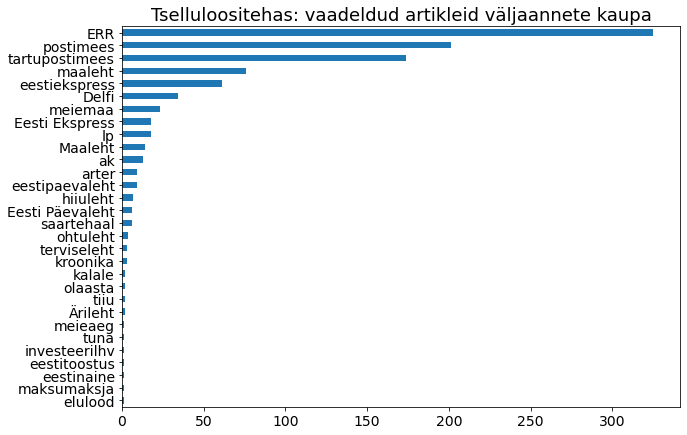

In [15]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title(konflikt + ": vaadeldud artikleid väljaannete kaupa", size=18)
data['subject'].value_counts(ascending = True).plot(ax=ax, kind='barh', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis1_Väljaanded.png")
plt.show()

## 3. Sõnapilvede loomine

In [16]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

## 3.1 Nimi- ja omadussõnad

### 3.1.1 Nimi- ja omadussõnad artiklite pealkirjades

EstNLTK vahenditega vaadeldakse uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja  omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

In [17]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad.append(sona[0][0])

nimi_omadus_words = ' '.join(map(str, nimi_omadus_sonad))

100%|█████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:05<00:00, 195.74it/s]


Tselluloositehas: pealkirjades nimisõnu ja omadussõnu sõnapilves:  3314


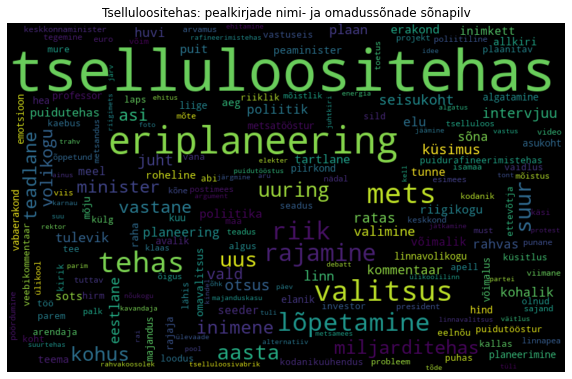

In [18]:
wordcloud_nimi_omadus = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade nimi- ja omadussõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis2_Pealkirjad_nimi_omadus_sonapilv.png')
plt.axis("off")
print(konflikt + ": pealkirjades nimisõnu ja omadussõnu sõnapilves: ", len(nimi_omadus_sonad))

### 3.1.2 Nimi- ja omadussõnade esinemissagedus artiklite pealkirjades

In [19]:
jaotus2 =pd.DataFrame(nimi_omadus_sonad, columns=['sõna'])
tabel2 = jaotus2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel2['osakaal %']= (tabel2['esinemissagedus']/len(nimi_omadus_sonad)*100)
tabel2_1 = tabel2.style.set_caption(konflikt + ": pealkirjade nimi- ja omadussõnade TOP 10")
tabel2.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel2_Pealkirjad_nimi_omadus_TOP_10.xlsx") 

In [20]:
tabel2_1

,sõna,esinemissagedus,osakaal %
1191,tselluloositehas,276,8.328304
154,eriplaneering,87,2.625226
1308,valitsus,46,1.388051
632,mets,45,1.357876
1150,tehas,44,1.327701
579,lõpetamine,34,1.025951
975,riik,32,0.965600
942,rajamine,31,0.935425
1071,suur,26,0.784550
1276,uus,24,0.724200


### 3.1.3 Nimi- ja omadussõnade kasutamine artiklite tekstides

In [21]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad1.append(sona[0][0])

nimi_omadus_words1 = ' '.join(map(str, nimi_omadus_sonad1))

100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [07:38<00:00,  2.22it/s]


Tselluloositehas: tekstides nimisõnu ja omadussõnu sõnapilves  290716


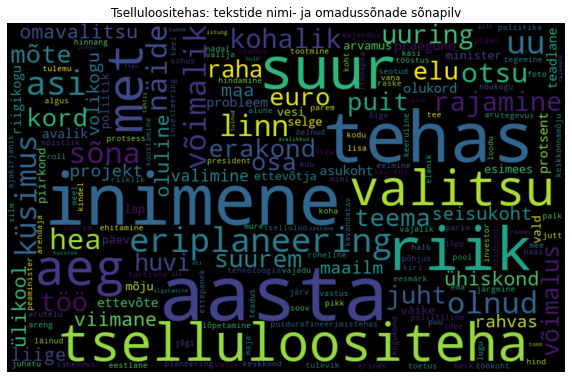

In [22]:
wordcloud_nimi_omadus1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus1, interpolation='bilinear')
plt.title(konflikt + ": tekstide nimi- ja omadussõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis3_Tekstid_nimi_omadus_sonapilv.png')
plt.axis("off")
print(konflikt + ": tekstides nimisõnu ja omadussõnu sõnapilves ", len(nimi_omadus_sonad1))

### 3.1.4 Nimi- ja omadussõnade esinemissagedus artiklite tekstides

In [23]:
jaotus3 =pd.DataFrame(nimi_omadus_sonad1, columns=['sõna'])
tabel3 = jaotus3.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel3['osakaal %']= (tabel3['esinemissagedus']/len(nimi_omadus_sonad1)*100)
tabel3_1 = tabel3.style.set_caption(konflikt + ": tekstide nimi- ja omadussõnade TOP 10")
tabel3.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel3_Tekstid_nimi_omadus_TOP_10.xlsx") 

In [24]:
tabel3_1

,sõna,esinemissagedus,osakaal %
392,aasta,3966,1.364218
6261,inimene,3397,1.168494
25447,tehas,3313,1.139600
21722,riik,2299,0.790806
23946,suur,2208,0.759504
26510,tselluloositehas,2033,0.699308
541,aeg,1837,0.631888
14792,mets,1825,0.627760
28479,valitsus,1766,0.607466
3873,eriplaneering,1650,0.567564


## 3.2 Verbid

### 3.2.1 Verbid artiklite pealkirjades

100%|█████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:05<00:00, 200.27it/s]


Tselluloositehas: verbe sõnapilves  1338


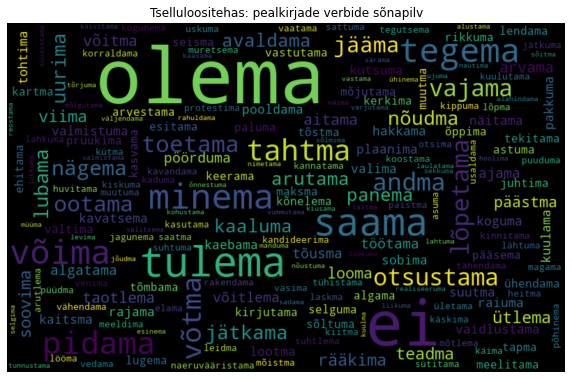

In [25]:
verb_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad.append(sona[0][0])

verb_words = ' '.join(map(str, verb_sonad))

wordcloud_verb = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade verbide sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis4_Pealkirjad_verbid_sonapilv.png')
plt.axis("off")
print(konflikt + ": verbe sõnapilves ", len(verb_sonad))

### 3.2.2 Verbide esinemissagedus artiklite pealkirjades

In [26]:
jaotus4 =pd.DataFrame(verb_sonad, columns=['sõna'])
tabel4 = jaotus4.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel4['osakaal %']= (tabel4['esinemissagedus']/len(verb_sonad)*100)
tabel4_1 = tabel4.style.set_caption(konflikt + ": pealkirjade verbide TOP 10")
tabel4.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel4_Pealkirjad_verbid_TOP_10.xlsx")

In [27]:
tabel4_1

,sõna,esinemissagedus,osakaal %
183,olema,212,15.844544
19,ei,133,9.940209
283,tulema,42,3.139013
234,saama,36,2.690583
158,minema,30,2.242152
332,võima,28,2.092676
274,tegema,28,2.092676
195,pidama,25,1.868460
268,tahtma,22,1.644245
337,võtma,20,1.494768


### 3.2.3 Verbid artiklite tekstides

100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [07:51<00:00,  2.16it/s]


Tselluloositehas: verbe sõnapilves:  166762


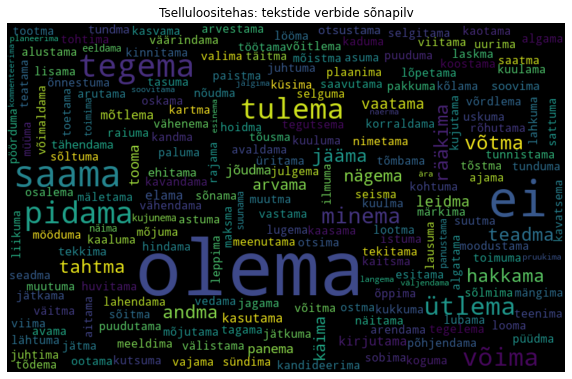

In [28]:
verb_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad1.append(sona[0][0])

verb_words1 = ' '.join(map(str, verb_sonad1))

wordcloud_verb1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb1, interpolation='bilinear')
plt.title(konflikt + ": tekstide verbide sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis5_Tekstid_verbid_sonapilv.png')
plt.axis("off")
print(konflikt + ": verbe sõnapilves: ", len(verb_sonad1))

### 3.2.4 Verbide esinemissagedus artiklite tekstides

In [29]:
jaotus5 =pd.DataFrame(verb_sonad1, columns=['sõna'])
tabel5 = jaotus5.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel5['osakaal %']= (tabel5['esinemissagedus']/len(verb_sonad1)*100)
tabel5_1 = tabel5.style.set_caption(konflikt + ": tekstide verbide TOP 10")
tabel5.to_excel("tulemused_" + konflikt +"/" + konflikt +  " tabel5_Tekstid_verbid_TOP_10.xlsx")

In [30]:
tabel5_1

,sõna,esinemissagedus,osakaal %
1350,olema,42025,25.200585
176,ei,12348,7.404565
1767,saama,5740,3.442031
2069,tegema,4423,2.652283
1456,pidama,4103,2.460393
2170,tulema,3599,2.158166
2553,ütlema,2750,1.649057
2468,võima,2727,1.635265
1172,minema,2042,1.224500
2485,võtma,1694,1.015819


# 4. Meediakajastus ajalisel skaalal

In [31]:
jaotus6 = data['aasta'].value_counts().sort_index()
tabel6 = pd.DataFrame({'Aasta':jaotus6.index, 'Artikleid':jaotus6.values})
tabel6['Osakaal, %'] = round((tabel6['Artikleid'] / 
                      tabel6['Artikleid'].sum() )* 100, 1)
tabel6_1 = tabel6.style.set_caption(konflikt + ": vaadeldud artikleid aastate lõikes")
tabel6.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel6_Aastate_lõikes.xlsx") 

In [32]:
tabel6_1

,Aasta,Artikleid,"Osakaal, %"
0,2015,1,0.100000
1,2017,107,10.500000
2,2018,701,68.800000
3,2019,98,9.600000
4,2020,55,5.400000
5,2021,49,4.800000
6,2022,8,0.800000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


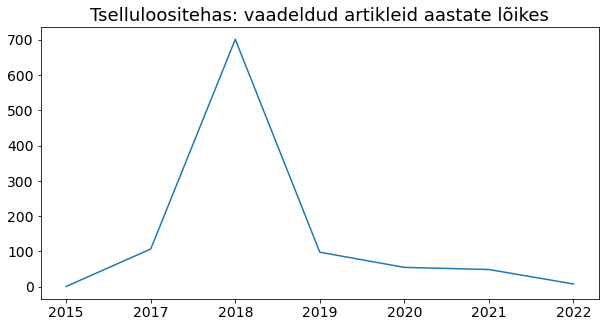

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title(konflikt + ": vaadeldud artikleid aastate lõikes", size=18)
data['aasta'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis6_Aastate_lõikes.png")
plt.show()

In [34]:
jaotus7 = data['aasta_kuu'].value_counts().sort_index()
tabel7 = pd.DataFrame({'Aasta':jaotus7.index, 'Artikleid':jaotus7.values})
tabel7['Osakaal, %'] = round((tabel7['Artikleid'] / 
                      tabel7['Artikleid'].sum() )* 100, 1)
tabel7_1 = tabel7.style.set_caption(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes")
tabel7.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_Aastate_kuude_lõikes.xlsx") 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


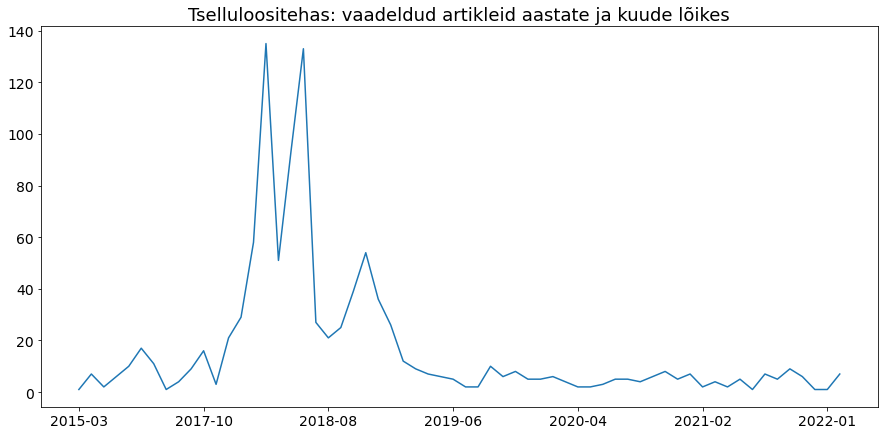

In [35]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes", size=18)
data['aasta_kuu'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_Aastate_kuude_lõikes.png")
plt.show()

# 5. Nimed

In [36]:
# Loome uue nimeüksuste tuvastaja 
from estnltk.taggers import NerTagger
ner_tagger = NerTagger()
# Milliseid kihte ner_tagger vajab?
ner_tagger.input_layers

('morph_analysis',)

In [37]:
tekst = data['text'].to_list()

In [38]:
# Otsitakse tekstist nimesid

nimed_texts = []
nimed_labels = []
from estnltk import Text

for k in tekst:
    t= Text(k).tag_layer('morph_analysis')
    # lisame nimeüksuste märgenduse
    ner_tagger.tag(t)
    # leia nimeüksuste liigid
    entity_labels = t.ner[['nertag']]
    # leia nimeüksuste tekstijupid
    entity_texts = [ne.enclosing_text for ne in t.ner]
    # leia nimeüksuste asukohad
    entity_spans = [(ne.start, ne.end) for ne in t.ner]

    # väljastab tuvastatud nimeüksused koos nende asukohtade, tekstijuppide ja liikidega:
    for ne_phrase, ne_label, ne_span in zip(entity_texts, entity_labels, entity_spans):
        print( ne_span, ne_phrase, ne_label )
    nimed_texts.append(entity_texts)
    nimed_labels.append(entity_labels)

(21, 28) Maalehe ['ORG']
(83, 95) Kohtla-Nõmme ['LOC']
(145, 148) VKG ['ORG']
(231, 243) Ahti Asmanni ['PER']
(388, 394) Eestis ['LOC']
(563, 569) Eestis ['LOC']
(9, 14) Eesti ['LOC']
(24, 39) Kristina Kallas ['PER']
(80, 87) EKRE-ga ['ORG']
(131, 140) Tallinnas ['LOC']
(141, 153) Keskerakonda ['ORG']
(164, 169) Eesti ['LOC']
(244, 249) Eesti ['LOC']
(317, 322) Poola ['LOC']
(144, 150) Isamaa ['ORG']
(151, 156) Tartu ['LOC']
(290, 298) Isamaale ['ORG']
(46, 61) Marju Lauristin ['PER']
(105, 114) Lääne Elu ['ORG']
(137, 146) Lauristin ['PER']
(625, 631) Tartus ['LOC']
(723, 728) NIMBY ['PER']
(1052, 1060) Tartusse ['LOC']
(1082, 1090) Emajõkke ['LOC']
(1095, 1100) Eesti ['LOC']
(1467, 1472) NIMBY ['PER']
(1482, 1487) NIMBY ['PER']
(1620, 1626) Emajõe ['LOC']
(1719, 1734) Tartu ülikoolis ['ORG']
(2150, 2159) Lauristin ['PER']
(0, 5) TARTU ['PER']
(17, 28) Tartu valla ['LOC']
(90, 102) Tauno Kangro ['PER']
(142, 146) Äksi ['LOC']
(250, 259) Tartumaal ['LOC']
(295, 301) Eestis ['LOC']
(507

(20, 33) Janek Mäggiga ['PER']
(75, 87) Indrek Vainu ['PER']
(95, 104) Maalehele ['ORG']
(156, 161) Tartu ['LOC']
(187, 199) Indrek Vainu ['PER']
(264, 272) Eestisse ['LOC']
(372, 376) SVEN ['PER']
(377, 382) ARBET ['PER']
(480, 485) Tartu ['LOC']
(1171, 1181) Mati Polli ['PER']
(1182, 1185) RMK ['ORG']
(1262, 1272) Aadu Polli ['PER']
(1278, 1293) Margus Kohavaga ['PER']
(1303, 1313) Mati Polli ['PER']
(1587, 1592) Sampo ['LOC']
(1644, 1661) Est-For Invest OÜ ['ORG']
(1915, 1930) Siim Kiisleriga ['PER']
(2039, 2046) Kiisler ['PER']
(2124, 2134) Kiislerile ['PER']
(2239, 2251) Vabaerakonna ['ORG']
(2312, 2321) Kiisleril ['PER']
(2424, 2435) Janek Mäggi ['PER']
(3682, 3696) Graanul Invest ['ORG']
(3700, 3705) Eesti ['LOC']
(3869, 3880) Janek Mäggi ['PER']
(3916, 3921) Mäggi ['PER']
(4217, 4222) Mäggi ['PER']
(4465, 4470) Mäggi ['PER']
(4494, 4507) Indrek Vainut ['PER']
(4941, 4953) Tartu linnal ['LOC']
(4983, 4988) Tartu ['LOC']
(5125, 5137) Tartu linnal ['LOC']
(5200, 5212) Tartu linnal

(0, 4) Maal ['LOC']
(8, 14) Eestis ['LOC']
(85, 96) Janek Mäggi ['PER']
(244, 250) Emajõe ['LOC']
(16, 21) Eesti ['LOC']
(35, 38) EMA ['ORG']
(92, 100) Est-Fori ['ORG']
(635, 641) Tartus ['LOC']
(647, 656) Tabiveres ['LOC']
(685, 691) Emajõe ['LOC']
(710, 718) Tabivere ['LOC']
(1175, 1188) Ida-Virumaale ['LOC']
(1234, 1237) EMA ['PER']
(1283, 1291) Eestimaa ['LOC']
(1456, 1462) Emajõe ['LOC']
(1510, 1516) Eestis ['LOC']
(1551, 1566) Est-Fori tehase ['ORG']
(1582, 1595) Margus Kohava ['PER']
(1620, 1634) Estonian Celli ['ORG']
(1643, 1648) Kunda ['LOC']
(1755, 1760) Eesti ['LOC']
(2161, 2166) Kunda ['LOC']
(2409, 2412) EMA ['PER']
(2901, 2907) Eestis ['LOC']
(12, 23) Jüri Ratase ['PER']
(210, 215) Ratas ['PER']
(272, 281) Tartumaal ['LOC']
(416, 422) Emajõe ['LOC']
(861, 866) Ratas ['PER']
(1111, 1119) Eestisse ['LOC']
(1293, 1298) Ratas ['PER']
(112, 118) Isamaa ['ORG']
(160, 171) Keskerakond ['ORG']
(207, 218) Mailis Reps ['PER']
(311, 322) Jüri Ratase ['PER']
(773, 787) Urmas Reinsal

(253, 261) Isamaale ['ORG']
(265, 279) Keskerakonnale ['ORG']
(325, 332) Pikhofi ['PER']
(899, 905) Emajõe ['LOC']
(1277, 1283) Isamaa ['ORG']
(1292, 1297) IRL-i ['ORG']
(1306, 1325) Helir Valdor Seeder ['PER']
(1409, 1412) IRL ['ORG']
(1510, 1522) Helju Pikhof ['PER']
(1557, 1563) Seeder ['PER']
(1648, 1653) Tartu ['LOC']
(1789, 1795) Seeder ['PER']
(1863, 1869) Seeder ['PER']
(1895, 1907) Keskerakonna ['ORG']
(1946, 1957) Mailis Reps ['PER']
(1968, 1981) Keskerakonnas ['ORG']
(6, 11) Soome ['LOC']
(305, 317) Lappeenranta ['LOC']
(396, 402) Soomes ['LOC']
(410, 414) Arvo ['PER']
(889, 893) Arvo ['PER']
(905, 917) Lappeenranta ['LOC']
(1140, 1152) Lappeenranta ['LOC']
(1207, 1213) Saimaa ['LOC']
(1290, 1296) Eestis ['LOC']
(1614, 1620) Emajõe ['LOC']
(1674, 1678) Arvo ['PER']
(1680, 1692) Lappeenranta ['LOC']
(1806, 1818) Lappeenranta ['LOC']
(2139, 2143) Arvo ['PER']
(2200, 2204) Arvo ['PER']
(2348, 2353) Rauma ['LOC']
(2395, 2399) Arvo ['PER']
(2736, 2742) Raumal ['LOC']
(2999, 3011)

(12, 31) Helir-Valdor Seeder ['PER']
(408, 413) Eesti ['LOC']
(422, 427) Eesti ['LOC']
(485, 490) Eesti ['LOC']
(613, 618) Eesti ['LOC']
(646, 653) Eestile ['LOC']
(668, 674) Seeder ['PER']
(956, 962) Isamaa ['ORG']
(993, 998) Delfi ['ORG']
(1007, 1014) Seederi ['PER']
(1040, 1052) HELIR-VALDOR ['PER']
(1053, 1060) SEEDERI ['PER']
(1097, 1108) Viljandisse ['LOC']
(1117, 1125) Eestisse ['LOC']
(1438, 1443) Eesti ['LOC']
(1444, 1446) EL ['ORG']
(2147, 2151) IRLi ['ORG']
(2392, 2403) Jüri Ratase ['PER']
(2457, 2463) Eestit ['LOC']
(2492, 2495) IRL ['ORG']
(2608, 2613) Eesti ['LOC']
(2888, 2893) Eesti ['LOC']
(2954, 2961) Venemaa ['LOC']
(2998, 3000) EL ['ORG']
(3364, 3368) IRLi ['ORG']
(3469, 3474) Eesti ['LOC']
(3502, 3509) Eestile ['LOC']
(3559, 3563) IRLi ['ORG']
(3797, 3807) Eesti riik ['LOC']
(4307, 4312) Eesti ['LOC']
(4982, 4988) Eestis ['LOC']
(5176, 5181) Eesti ['LOC']
(5294, 5299) Eesti ['LOC']
(5421, 5426) Eesti ['LOC']
(5474, 5480) Eestit ['LOC']
(5489, 5497) Euroopat ['LOC']


(161, 167) Emajõe ['LOC']
(208, 216) Emajõele ['LOC']
(220, 234) Peipsi järvele ['LOC']
(237, 240) ENN ['PER']
(241, 246) LOIGU ['PER']
(633, 648) Soome Äänekoski ['ORG']
(1393, 1406) Eesti jõgesid ['LOC']
(1441, 1453) Peipsi järve ['LOC']
(1664, 1673) Peipsisse ['LOC']
(2141, 2147) Emajõe ['LOC']
(3105, 3113) Emajõele ['LOC']
(3321, 3327) Eestis ['LOC']
(3491, 3494) BHT ['ORG']
(3525, 3539) Eesti jõgedele ['LOC']
(3552, 3560) Emajõele ['LOC']
(3588, 3600) Peipsi järve ['LOC']
(3712, 3719) Emajõge ['LOC']
(3867, 3870) BHT ['ORG']
(3928, 3939) Tartu linna ['LOC']
(4324, 4329) Eesti ['LOC']
(4351, 4357) Emajõe ['LOC']
(4379, 4393) Peipsi järvele ['LOC']
(4394, 4401) Kavastu ['LOC']
(4698, 4704) Emajõe ['LOC']
(4787, 4801) Peipsi järvest ['LOC']
(4817, 4827) Narva jões ['LOC']
(4851, 4861) Vasknarvas ['LOC']
(4907, 4919) Pihkva järve ['LOC']
(4963, 4975) Peipsi järve ['LOC']
(5061, 5068) Emajõgi ['LOC']
(5429, 5440) Tartu linna ['LOC']
(5509, 5517) Emajõele ['LOC']
(5591, 5597) Emajõe ['L

(6, 11) Tartu ['LOC']
(60, 72) Eestis linnu ['LOC']
(182, 188) Soomes ['LOC']
(189, 199) Äänekoskis ['LOC']
(238, 246) Eestisse ['LOC']
(261, 274) Mustvee valda ['LOC']
(454, 463) Maalehest ['ORG']
(583, 595) Peipsi järve ['LOC']
(602, 615) Mustvee valla ['LOC']
(627, 639) Jüri Morozov ['PER']
(679, 687) Eestisse ['LOC']
(702, 715) Mustvee valda ['LOC']
(733, 740) Eestist ['LOC']
(824, 831) Rootsis ['LOC']
(833, 839) Soomes ['LOC']
(916, 923) Morozov ['PER']
(1142, 1152) Lämmijärve ['LOC']
(1159, 1173) Setomaa vallas ['LOC']
(1197, 1211) Rein Järvelill ['PER']
(1259, 1266) Setomaa ['LOC']
(1345, 1354) Järvelill ['PER']
(1611, 1616) Valga ['LOC']
(1628, 1640) Margus Lepik ['PER']
(1956, 1961) Lepik ['PER']
(2040, 2045) Pärnu ['LOC']
(2046, 2055) Pärnumaal ['LOC']
(2133, 2152) Pärnu linnavolikogu ['ORG']
(2161, 2175) Andres Metsoja ['PER']
(2190, 2195) Pärnu ['LOC']
(2504, 2514) Tartumaale ['LOC']
(2547, 2554) Metsoja ['PER']
(2595, 2600) Eesti ['LOC']
(2703, 2708) Pärnu ['LOC']
(2718, 2

(56, 61) Tartu ['LOC']
(370, 375) Klaas ['ORG']
(419, 424) Tartu ['LOC']
(520, 525) Tartu ['LOC']
(573, 578) Tartu ['LOC']
(618, 623) Klaas ['PER']
(768, 773) Tartu ['LOC']
(783, 788) Klaas ['PER']
(971, 976) Tartu ['LOC']
(1111, 1122) Tartu linna ['LOC']
(1316, 1321) Klaas ['PER']
(1327, 1344) Eesti Päevalehele ['ORG']
(1364, 1369) Tartu ['LOC']
(1479, 1484) Klaas ['PER']
(1577, 1583) Emajõe ['LOC']
(1587, 1593) Peipsi ['LOC']
(1686, 1706) The Baltic Times’ile ['ORG']
(1731, 1736) Klaas ['PER']
(1758, 1763) Tartu ['LOC']
(31, 37) Eestis ['LOC']
(81, 86) Eesti ['LOC']
(161, 169) Eestisse ['LOC']
(213, 218) Tartu ['LOC']
(314, 319) Eesti ['LOC']
(1, 12) Luunja vald ['LOC']
(134, 142) Anderson ['PER']
(143, 150) Delfile ['ORG']
(153, 166) Tartu linnaga ['LOC']
(308, 316) Anderson ['PER']
(913, 921) Anderson ['PER']
(1373, 1381) Anderson ['PER']
(1383, 1388) Tartu ['LOC']
(1400, 1404) Elva ['LOC']
(1408, 1414) Kastre ['LOC']
(20, 31) Jaak Aabilt ['PER']
(73, 78) Tartu ['LOC']
(126, 129) A

(0, 5) Eesti ['LOC']
(137, 146) Tartumaal ['LOC']
(147, 152) Rõngu ['LOC']
(172, 178) Otepää ['LOC']
(182, 188) Kanepi ['LOC']
(221, 226) Eesti ['LOC']
(290, 295) Tartu ['LOC']
(297, 302) Valga ['LOC']
(304, 309) Põlva ['LOC']
(313, 317) Võru ['LOC']
(524, 535) Lõuna-Eesti ['LOC']
(738, 767) Riigimetsa Majandamise Keskus ['ORG']
(769, 772) RMK ['ORG']
(996, 1002) Peeter ['PER']
(1003, 1012) Kroonberg ['PER']
(1064, 1075) Ekspressile ['ORG']
(1092, 1108) Peeter Kroonberg ['PER']
(1110, 1119) Kroonberg ['PER']
(1380, 1389) Kroonberg ['PER']
(1488, 1495) Excelis ['LOC']
(1572, 1578) Peeter ['PER']
(1579, 1588) Kroonberg ['PER']
(1616, 1621) Eesti ['LOC']
(1721, 1724) RMK ['ORG']
(1742, 1753) Kagu-Eestis ['LOC']
(1852, 1864) Kagu-Eestist ['LOC']
(1989, 1995) Eestis ['LOC']
(2063, 2069) Otepää ['LOC']
(2142, 2158) Peeter Kroonberg ['PER']
(2438, 2449) Ekspressiga ['ORG']
(3215, 3225) Valgamaalt ['LOC']
(3226, 3236) Paluperast ['LOC']
(3647, 3650) RMK ['ORG']
(3973, 3976) RMK ['ORG']
(4066, 

(18, 25) Maalehe ['ORG']
(68, 71) RMK ['ORG']
(188, 198) Aadu Polli ['PER']
(202, 208) Margus ['PER']
(209, 215) Kohava ['PER']
(278, 281) ERR ['ORG']
(301, 318) Est-For Invest OÜ ['ORG']
(511, 540) Riigimetsa Majandamise Keskus ['ORG']
(542, 545) RMK ['ORG']
(905, 908) RMK ['ORG']
(959, 965) Emajõe ['LOC']
(1043, 1062) OÜga Est-For Invest ['ORG']
(1085, 1098) Margus Kohava ['PER']
(1102, 1114) Aadu Polliga ['PER']
(1172, 1175) RMK ['ORG']
(1288, 1303) Est-For Investi ['ORG']
(1621, 1624) RMK ['ORG']
(1735, 1750) Est-For Investi ['ORG']
(1761, 1767) Kohava ['PER']
(1771, 1776) Polli ['PER']
(1782, 1785) RMK ['ORG']
(1803, 1815) Aigar Kallas ['PER']
(1912, 1915) RMK ['ORG']
(2235, 2251) Estonian Celliga ['ORG']
(2253, 2258) Aigar ['PER']
(2259, 2265) Kallas ['PER']
(2428, 2431) RMK ['ORG']
(2449, 2461) Aigar Kallas ['PER']
(2755, 2758) RMK ['ORG']
(2855, 2867) Aigar Kallas ['PER']
(2904, 2907) RMK ['ORG']
(2980, 2996) Est-For Investil ['ORG']
(3091, 3097) Kallas ['PER']
(3322, 3338) Est

(0, 10) Tartumaale ['LOC']
(173, 179) Tartus ['LOC']
(234, 244) Tallinnast ['LOC']
(279, 290) Rail Baltic ['PER']
(489, 501) Rail Balticu ['PER']
(528, 534) Eestis ['LOC']
(589, 604) Euroopa Liiduga ['ORG']
(721, 726) Eesti ['LOC']
(776, 788) Rail Balticu ['PER']
(956, 961) Eesti ['LOC']
(1198, 1207) Tartumaal ['LOC']
(1208, 1214) Emajõe ['LOC']
(1257, 1264) Emajõge ['LOC']
(1351, 1360) Toomemäel ['LOC']
(1405, 1410) Eesti ['LOC']
(1435, 1447) Martin Luiga ['PER']
(1451, 1466) Linda-Mari Väli ['PER']
(1486, 1496) Postimehes ['ORG']
(1575, 1584) Toomemäel ['LOC']
(1606, 1612) Tartus ['LOC']
(1615, 1619) Väli ['PER']
(1626, 1635) Maalehele ['ORG']
(1866, 1872) Emajõe ['LOC']
(1928, 1938) Aadu Polli ['PER']
(1942, 1955) Margus Kohava ['PER']
(2067, 2075) Emajõele ['LOC']
(2135, 2149) Est-For Invest ['ORG']
(2167, 2180) Margus Kohava ['PER']
(2184, 2194) Aadu Polli ['PER']
(2232, 2238) Emajõe ['LOC']
(2375, 2390) Est-For Investi ['ORG']
(2407, 2417) Aadu Polli ['PER']
(2595, 2601) Emajõe [

(350, 355) Pärnu ['LOC']
(357, 365) Viljandi ['LOC']
(367, 373) Jõgeva ['LOC']
(375, 380) Tartu ['LOC']
(385, 399) Põlva maakonda ['LOC']
(472, 491) Est-For valitsusele ['ORG']
(534, 540) Tartu- ['LOC']
(544, 555) Viljandimaa ['LOC']
(581, 589) Eestisse ['LOC']
(656, 668) Tiit Oidjärv ['PER']
(676, 682) ERRile ['ORG']
(983, 1004) Keskkonnaministeerium ['ORG']
(1226, 1233) Oidjärv ['PER']
(1286, 1292) Tartu- ['LOC']
(1296, 1307) Viljandimaa ['LOC']
(1310, 1323) Tiit Oidjärve ['PER']
(1369, 1375) Tartu- ['LOC']
(1379, 1390) Viljandimaa ['LOC']
(1684, 1699) Est-For Investi ['ORG']
(1715, 1728) Margus Kohava ['PER']
(1987, 1993) Kohava ['PER']
(2014, 2020) Tartus ['LOC']
(2044, 2050) Kohava ['PER']
(2054, 2069) Est-For Investi ['ORG']
(2091, 2101) Aadu Polli ['PER']
(2202, 2208) Kohava ['PER']
(2302, 2314) Tiit Oidjärv ['PER']
(2900, 2914) Est-For Invest ['ORG']
(82, 97) Est-For Investi ['ORG']
(133, 139) Emajõe ['LOC']
(218, 230) Mihhail Korb ['PER']
(319, 327) Viljandi ['LOC']
(332, 354)

(12, 17) Eesti ['LOC']
(73, 78) Eesti ['LOC']
(138, 147) Postimees ['ORG']
(148, 167) Scanpix Kaasaegsete ['ORG']
(227, 233) Eestil ['LOC']
(489, 513) Eesti Teaduste Akadeemia ['ORG']
(796, 809) Tarmo Soomere ['PER']
(811, 835) Eesti Teaduste Akadeemia ['ORG']
(867, 880) Ando Leppiman ['PER']
(882, 891) Majandus- ['ORG']
(895, 923) Kommunikatsiooniministeerium ['ORG']
(956, 961) Eesti ['LOC']
(978, 991) Margus Kohava ['PER']
(993, 1010) EST-FOR Invest OÜ ['ORG']
(1083, 1095) Kaupo Heinma ['PER']
(1097, 1118) Keskkonnaministeerium ['ORG']
(1257, 1270) Per Engstrand ['ORG']
(1272, 1291) Kesk-Rootsi Ülikool ['ORG']
(1464, 1475) Virve Sõber ['ORG']
(1479, 1489) Kuno Kasak ['PER']
(1491, 1504) Tartu Ülikool ['ORG']
(1508, 1526) Eesti Looduse Fond ['ORG']
(1606, 1620) Raul Rosenvald ['PER']
(1622, 1638) Eesti Maaülikool ['ORG']
(1693, 1702) Mait Lang ['PER']
(1704, 1720) Eesti Maaülikool ['ORG']
(1724, 1744) Tartu Observatoorium ['ORG']
(1813, 1823) Ülo Mander ['PER']
(1825, 1838) Tartu Ülik

(0, 5) Tartu ['LOC']
(32, 37) Tartu ['LOC']
(80, 88) ERR Eile ['ORG']
(96, 100) ERRi ['ORG']
(112, 117) Tartu ['LOC']
(230, 241) Tartu linna ['LOC']
(418, 429) Tartu linna ['LOC']
(1286, 1291) Tartu ['LOC']
(1331, 1336) Tartu ['LOC']
(1430, 1442) Urmas Klaasi ['PER']
(2623, 2636) Aivar Riisalu ['PER']
(2697, 2704) Ansipit ['PER']
(2712, 2727) Reformierakonda ['ORG']
(2867, 2879) Tartu linnal ['LOC']
(2962, 2975) Aivar Riisalu ['PER']
(3073, 3079) Tartus ['LOC']
(3150, 3155) Tartu ['LOC']
(0, 3) RMK ['ORG']
(54, 57) RMK ['ORG']
(124, 133) Arne Ader ['PER']
(173, 185) Siim Kiisler ['PER']
(215, 232) Eesti Metsa Abiks ['ORG']
(256, 270) Est-For Invest ['ORG']
(396, 404) Kiisleri ['PER']
(782, 787) Eesti ['LOC']
(965, 972) Eestile ['LOC']
(1042, 1049) Kiisler ['PER']
(1102, 1105) EMA ['PER']
(1191, 1211) Tallinna halduskohus ['ORG']
(1360, 1375) EMA halduskohtu ['ORG']
(1416, 1423) Kiisler ['PER']
(2047, 2054) Kiisler ['PER']
(0, 7) Emajõgi ['PER']
(24, 33) Postimees ['ORG']
(34, 41) Scanp

(0, 14) Tartu ülikooli ['ORG']
(50, 72) Tartu linnavalitsuselt ['ORG']
(338, 348) Tartu linn ['LOC']
(773, 783) Tartu linn ['LOC']
(846, 856) Tartu linn ['LOC']
(932, 942) Tartu linn ['LOC']
(1010, 1021) Asko Lõhmus ['PER']
(1032, 1044) Urmas Klaasi ['PER']
(1511, 1516) Klaas ['PER']
(1717, 1722) Tartu ['LOC']
(1777, 1782) Klaas ['PER']
(1829, 1834) Tartu ['LOC']
(1845, 1858) Eesti riigile ['LOC']
(1873, 1878) Tartu ['LOC']
(1905, 1915) Tartu linn ['LOC']
(1940, 1945) Tartu ['LOC']
(1954, 1959) Eesti ['LOC']
(1976, 1985) Cambridge ['LOC']
(1990, 2015) Oxford Ühendkuningriikide ['LOC']
(2041, 2046) Tartu ['LOC']
(2095, 2104) Cambridge ['LOC']
(0, 13) ERR Novaatori ['ORG']
(33, 44) Marju Himma ['PER']
(45, 58) ERR Novaatori ['ORG']
(78, 89) Marju Himma ['PER']
(106, 115) Siim Lõvi ['PER']
(116, 119) ERR ['ORG']
(199, 212) ERR Novaatori ['ORG']
(247, 258) Marju Himma ['PER']
(422, 434) Põhja-Koreas ['LOC']
(514, 520) Eestis ['LOC']
(627, 641) Rail Balticule ['PER']
(768, 779) Tiit Ojasoo 

(20, 26) Samost ['PER']
(30, 38) Ruussaar ['PER']
(59, 71) Anvar Samost ['PER']
(106, 109) RMK ['ORG']
(113, 121) Est-Fori ['ORG']
(400, 406) RMK-le ['ORG']
(416, 421) Eesti ['LOC']
(521, 524) RMK ['ORG']
(558, 564) Samost ['PER']
(566, 573) Samosti ['PER']
(793, 814) Ameerika Ühendriikide ['LOC']
(836, 854) Narva Elektrijaamu ['ORG']
(883, 886) NRG ['ORG']
(972, 977) Eesti ['LOC']
(1066, 1072) Samost ['PER']
(1074, 1081) Samosti ['PER']
(1091, 1094) RMK ['ORG']
(1098, 1106) Est-Fori ['ORG']
(1259, 1262) RMK ['ORG']
(1397, 1403) Samost ['PER']
(1405, 1413) Ruussaar ['PER']
(1475, 1480) Eesti ['LOC']
(1528, 1542) Graanul Invest ['PER']
(1685, 1700) Skandinaaviasse ['LOC']
(1704, 1716) Valgevenesse ['LOC']
(1775, 1783) Ruussaar ['PER']
(1785, 1792) Samosti ['PER']
(2105, 2110) Eesti ['LOC']
(2431, 2437) Samost ['PER']
(2439, 2448) Ruussaare ['PER']
(2750, 2756) Eestis ['LOC']
(2766, 2771) EL-is ['LOC']
(3077, 3083) Eestis ['LOC']
(3166, 3174) Ruussaar ['PER']
(3183, 3189) Eestis ['LOC']


(0, 5) Tartu ['LOC']
(15, 26) Urmas Klaas ['PER']
(28, 33) Tartu ['LOC']
(218, 230) Urmas Klaasi ['PER']
(281, 287) Eestis ['LOC']
(304, 311) Tartule ['LOC']
(365, 380) Tartu Postimees ['ORG']
(403, 408) Tartu ['LOC']
(478, 492) Est-For Invest ['ORG']
(0, 11) Keskerakond ['ORG']
(89, 99) Jüri Ratas ['PER']
(162, 168) Ratase ['PER']
(201, 210) Stenbocki ['ORG']
(237, 250) Toomas Sildam ['PER']
(400, 411) Keskerakond ['ORG']
(593, 604) Keskerakond ['ORG']
(754, 769) Reformierakonna ['ORG']
(786, 798) Keskerakonna ['ORG']
(848, 863) Reformierakonna ['ORG']
(1315, 1320) IRL-i ['ORG']
(1382, 1387) IRL-i ['ORG']
(1577, 1582) Eesti ['LOC']
(1648, 1658) Haigekassa ['ORG']
(1893, 1898) Eesti ['LOC']
(1945, 1956) Keskerakond ['ORG']
(2184, 2187) EPL ['ORG']
(2216, 2234) Jevgeni Ossinovski ['PER']
(2318, 2338) Jevgeni Ossinovskiga ['PER']
(2567, 2573) Eestis ['LOC']
(3191, 3206) Reformierakonna ['ORG']
(3468, 3473) Eesti ['LOC']
(3544, 3549) IRL-i ['ORG']
(3553, 3565) Keskerakonna ['ORG']
(4199, 

(0, 5) Eesti ['LOC']
(25, 33) Saaremaa ['LOC']
(43, 51) Helsingi ['LOC']
(76, 81) Tartu ['LOC']
(131, 143) Rail Balticu ['PER']
(190, 195) ERR-i ['ORG']
(229, 246) Turu-uuringute AS ['ORG']
(467, 472) Tartu ['LOC']
(574, 579) Eesti ['LOC']
(1078, 1083) Eesti ['LOC']
(1093, 1101) Saaremaa ['LOC']
(1124, 1128) Muhu ['PER']
(1266, 1271) Eesti ['LOC']
(1289, 1306) Tallinna-Helsingi ['LOC']
(1435, 1447) Rail Balticu ['PER']
(1575, 1580) Eesti ['LOC']
(1694, 1702) Saaremaa ['LOC']
(1746, 1757) Lääne-Eesti ['LOC']
(1813, 1824) Lääne-Eesti ['LOC']
(1910, 1915) Eesti ['LOC']
(2057, 2065) Saaremaa ['LOC']
(2122, 2139) Tallinna-Helsingi ['LOC']
(2222, 2230) Ida-Viru ['LOC']
(2249, 2260) Lääne-Eesti ['LOC']
(2290, 2298) Tallinna ['LOC']
(2389, 2400) Kesk-Eestis ['LOC']
(2428, 2443) Rail Balticusse ['PER']
(2483, 2494) Kesk-Eestis ['LOC']
(2523, 2535) Lääne-Eestis ['LOC']
(2594, 2603) Tallinnas ['LOC']
(2622, 2634) Ida-Virumaal ['LOC']
(2651, 2663) Rail Balticu ['PER']
(2684, 2693) Tallinnas ['LOC'

(0, 5) Tartu ['LOC']
(42, 57) Marju Lauristin ['PER']
(245, 255) Lauristini ['PER']
(423, 428) Tartu ['LOC']
(582, 591) Lauristin ['PER']
(592, 599) ERR-ile ['ORG']
(772, 775) SDE ['ORG']
(1124, 1131) Tartule ['LOC']
(1275, 1280) Tartu ['LOC']
(1301, 1311) Lauristini ['PER']
(1333, 1342) Lauristin ['PER']
(1380, 1385) Tartu ['LOC']
(1448, 1454) ERR.ee ['PER']
(1497, 1508) Tartu linna ['LOC']
(1676, 1685) Lauristin ['PER']
(1706, 1716) Lauristini ['PER']
(1838, 1844) Emajõe ['LOC']
(1852, 1861) Tartumaal ['LOC']
(1995, 2002) Tartule ['LOC']
(2006, 2014) Emajõele ['LOC']
(2044, 2053) Lauristin ['PER']
(2114, 2122) Emajõkke ['LOC']
(2126, 2131) Tartu ['LOC']
(2154, 2160) Emajõe ['LOC']
(2217, 2223) Peipsi ['LOC']
(2359, 2369) Lauristini ['PER']
(2384, 2389) Tartu ['LOC']
(2434, 2439) Tartu ['LOC']
(2507, 2516) Euroopast ['LOC']
(2597, 2602) Eesti ['LOC']
(2788, 2795) Soomest ['LOC']
(2938, 2947) Lauristin ['PER']
(2996, 3005) Lauristin ['PER']
(3213, 3218) Eesti ['LOC']
(80, 90) Jüri Rata

(22, 30) Jaak Aab ['PER']
(41, 46) Tartu ['LOC']
(229, 234) Tartu ['LOC']
(382, 390) Jaak Aab ['PER']
(570, 573) Aab ['PER']
(729, 739) Tartu linn ['LOC']
(1001, 1008) Tartust ['LOC']
(1483, 1487) Aabi ['PER']
(1682, 1687) Tartu ['LOC']
(1862, 1865) Aab ['PER']
(104, 109) Tartu ['LOC']
(135, 141) Eestit ['LOC']
(189, 194) Eesti ['LOC']
(486, 504) Teaduste Akadeemia ['ORG']
(535, 545) Ülo Mander ['PER']
(631, 637) Tartus ['LOC']
(922, 929) Manderi ['PER']
(964, 978) Urmas Varblane ['PER']
(1005, 1013) Est-Fori ['ORG']
(1034, 1042) Sillamäe ['LOC']
(1044, 1049) Pärnu ['LOC']
(1063, 1073) Narva jõgi ['LOC']
(1121, 1131) Aadu Polli ['PER']
(1145, 1152) Tartule ['LOC']
(1410, 1425) Marju Lauristin ['PER']
(1483, 1488) Tartu ['LOC']
(1515, 1528) Tartu ülikool ['ORG']
(1656, 1664) Tartusse ['LOC']
(1694, 1706) Emajõe linna ['LOC']
(1717, 1722) Tartu ['LOC']
(1928, 1940) Tiit Oidjärv ['PER']
(2106, 2112) Tartut ['LOC']
(32, 35) SDE ['ORG']
(45, 63) Jevgeni Ossinovski ['PER']
(132, 137) Tartu [

(36, 47) Ülle Madise ['PER']
(149, 171) riigikogu ja valitsuse ['ORG']
(255, 268) Toomas Sildam ['PER']
(436, 454) Euroopa Parlamendi ['ORG']
(755, 769) europarlamendi ['ORG']
(875, 883) Tallinna ['LOC']
(1196, 1214) Euroopa Parlamendi ['ORG']
(1433, 1451) Euroopa Parlamendi ['ORG']
(1919, 1930) Eesti riigi ['LOC']
(1988, 1995) Soomega ['LOC']
(2006, 2014) Saaremaa ['LOC']
(2401, 2409) Euroopas ['LOC']
(3258, 3262) ERJK ['ORG']
(3272, 3284) Ardo Ojasalu ['PER']
(3300, 3306) Eestis ['LOC']
(3505, 3520) Holger Roonemaa ['PER']
(3546, 3551) ERR-i ['ORG']
(3562, 3567) Eesti ['LOC']
(3742, 3747) Eesti ['LOC']
(3761, 3766) Eesti ['LOC']
(4942, 4953) Facebook’is ['LOC']
(5003, 5009) ERJK-l ['ORG']
(5069, 5074) Eesti ['LOC']
(5615, 5620) Eesti ['LOC']
(5751, 5762) Jüri Ratase ['PER']
(6807, 6812) Eesti ['LOC']
(6813, 6838) Apostlik-Õigeusu Kirikule ['ORG']
(6856, 6891) Eesti Evangeelse Luterliku Kirikule ['ORG']
(7504, 7509) Eesti ['LOC']
(8952, 8972) Aga Niguliste kiriku ['ORG']
(10286, 10297

(39, 52) Vilja Kiisler ['PER']
(41, 64) ERR Tartu linnavalitsus ['ORG']
(150, 164) Tartu maakonda ['LOC']
(258, 270) Urmas Klaasi ['PER']
(284, 289) Tartu ['LOC']
(663, 668) Klaas ['PER']
(901, 915) Tartu maakonda ['LOC']
(938, 952) Tartu maakonna ['LOC']
(956, 967) Tartu linna ['LOC']
(1239, 1245) Emajõe ['LOC']
(1249, 1255) Peipsi ['LOC']
(1284, 1297) Tartu maakond ['LOC']
(1345, 1364) Tartu Linnavalitsus ['ORG']
(1914, 1933) Tartu Linnavolikogu ['ORG']
(12, 22) Jüri Ratas ['PER']
(39, 44) Tartu ['LOC']
(238, 244) Ratase ['PER']
(269, 288) Tartu linnavolikogu ['ORG']
(577, 582) Tartu ['LOC']
(1201, 1210) Aadu Must ['PER']
(1221, 1233) Keskerakonna ['ORG']
(1234, 1239) Tartu ['LOC']
(1290, 1295) Tartu ['LOC']
(1601, 1612) Tartu linna ['LOC']
(1693, 1709) Reformierakonnal ['ORG']
(1734, 1740) IRL-il ['ORG']
(1742, 1748) EKRE-l ['ORG']
(1769, 1774) Tartu ['LOC']
(1941, 1955) Tartu-Tallinna ['LOC']
(2020, 2025) Tartu ['LOC']
(2029, 2036) Tallinn ['LOC']
(2150, 2165) Eesti vabariigi ['LOC

(0, 26) Kaheksast Tartumaa vallast ['LOC']
(41, 52) Tartu linna ['LOC']
(147, 156) Elva vald ['LOC']
(282, 287) Tartu ['LOC']
(298, 304) Emajõe ['LOC']
(341, 353) Kantar Emori ['PER']
(418, 446) Tartumaa omavalitsuste liidu ['ORG']
(501, 512) Tartu linna ['LOC']
(602, 612) Tartu vald ['LOC']
(622, 627) Tartu ['LOC']
(663, 672) Elva vald ['LOC']
(820, 834) Tartu maakonna ['LOC']
(842, 847) Eesti ['LOC']
(1220, 1238) Elva vallavolikogu ['ORG']
(1250, 1263) Peeter Laasik ['PER']
(1713, 1716) Nõo ['PER']
(1729, 1751) Tartumaa omavalitsuste ['ORG']
(1763, 1778) Rain Sangernebo ['PER']
(2027, 2032) Tartu ['LOC']
(2042, 2053) Urmas Klaas ['PER']
(2067, 2077) Jüri Ratas ['PER']
(0, 11) Alar Karise ['PER']
(83, 91) Tartusse ['LOC']
(93, 113) Eesti Rahva Muuseumi ['ORG']
(115, 118) ERM ['ORG']
(168, 176) Karisele ['PER']
(277, 290) Toomas Sildam ['PER']
(347, 361) Tartu Ülikooli ['ORG']
(408, 422) Tartu Ülikooli ['ORG']
(467, 472) Eesti ['LOC']
(473, 487) Rahva Muuseumi ['ORG']
(829, 834) Tartu 

(87, 108) Rein Sikk Vikerraadio ['ORG']
(148, 153) Eesti ['LOC']
(277, 290) Lõuna-Eestist ['LOC']
(524, 533) Tammsaare ['PER']
(616, 624) Kivirähk ['PER']
(1423, 1431) Tartusse ['LOC']
(1433, 1441) Põlvasse ['LOC']
(1445, 1450) Valga ['LOC']
(1483, 1488) Eesti ['LOC']
(1666, 1669) Aru ['LOC']
(1953, 1961) Kivirähk ['PER']
(624, 636) Artes Terrae ['PER']
(709, 719) OÜ Skepast ['ORG']
(722, 728) Puhkim ['PER']
(972, 991) OÜ Keskkonnaprojekt ['ORG']
(1024, 1036) Artes Terrae ['PER']
(1077, 1086) Mart Hiob ['PER']
(1250, 1257) Skepast ['LOC']
(1260, 1267) Puhkimi ['PER']
(1700, 1704) Hiob ['PER']
(1959, 1976) Osaühingu Skepast ['PER']
(1979, 1985) Puhkim ['PER']
(2001, 2015) Hendrik Puhkim ['PER']
(2485, 2491) Puhkim ['PER']
(2550, 2562) Tiit Oidjärv ['PER']
(2574, 2581) Skepast ['PER']
(2584, 2590) Puhkim ['PER']
(2832, 2839) Oidjärv ['PER']
(2883, 2895) Tiit Oidjärv ['PER']
(3351, 3358) Oidjärv ['PER']
(3360, 3369) Mart Hiob ['PER']
(3623, 3641) AS Infragate Eesti ['ORG']
(52, 60) Tartum

(198, 204) Invest ['PER']
(297, 311) Est-For Invest ['ORG']
(357, 371) Tartu Ülikooli ['ORG']
(395, 408) Tartu Ülikool ['ORG']
(435, 449) Tartu Ülikooli ['ORG']
(451, 468) Eesti Maaülikooli ['ORG']
(472, 496) Tallinna Tehnikaülikooli ['ORG']
(661, 669) Est-Fori ['ORG']
(679, 693) Tartu ülikooli ['ORG']
(1169, 1174) Eesti ['LOC']
(1283, 1297) Tartu Ülikooli ['ORG']
(1305, 1316) Virve Sõber ['ORG']
(1449, 1463) Tartu Ülikooli ['ORG']
(1542, 1555) Margit Sutrop ['PER']
(1560, 1572) Toomas Asser ['PER']
(1577, 1592) Tartu Ülikoolil ['ORG']
(1647, 1661) Tartu Ülikooli ['ORG']
(1695, 1709) Tartu Ülikooli ['ORG']
(1862, 1872) Volli Kalm ['ORG']
(2046, 2052) Sutrop ['PER']
(2064, 2077) Mirko Ojakivi ['PER']
(2084, 2099) Toomas Asserilt ['PER']
(2215, 2227) Toomas Asser ['PER']
(2498, 2512) Est-For Invest ['ORG']
(2695, 2706) Maaülikooli ['ORG']
(2751, 2762) Henn Korjus ['PER']
(2841, 2848) Est-For ['ORG']
(3218, 3224) Korjus ['PER']
(3254, 3270) Tartu Ülikoolita ['ORG']
(3437, 3450) Tartu Ülik

(348, 361) Dom Perignoni ['PER']
(387, 393) Maslow ['PER']
(1827, 1834) Eestile ['LOC']
(1853, 1864) Rail Baltic ['PER']
(2277, 2290) Yellowstone’i ['LOC']
(2529, 2535) Haanja ['LOC']
(2547, 2560) Uus-Tallinnat ['LOC']
(2985, 2993) Viljandi ['LOC']
(3221, 3226) Tartu ['LOC']
(3758, 3765) Hiiumaa ['LOC']
(3790, 3804) Aaliyah Ohakim ['PER']
(3816, 3828) Lääne-Kanepi ['LOC']
(3845, 3859) Roger O’Connor ['PER']
(3871, 3876) Eesti ['LOC']
(3896, 3913) Parwaiz Tabatabai ['PER']
(3947, 3960) AS TrioSalmon ['ORG']
(3978, 3995) Ianthe Østergaard ['PER']
(4007, 4040) SA Vana-Ida-Eesti regionaalhaigla ['ORG']
(4053, 4067) Sigwald Sommer ['PER']
(4079, 4084) Eesti ['LOC']
(98, 102) Meky ['ORG']
(164, 179) Graanul Investi ['ORG']
(192, 201) Peep Pitk ['PER']
(344, 353) Peep Pitk ['PER']
(363, 374) Vikerraadio ['ORG']
(1171, 1175) Pitk ['PER']
(1418, 1433) Graanul Investi ['ORG']
(1488, 1491) USA ['LOC']
(1517, 1534) Sweetwater Energy ['ORG']
(1567, 1572) Pitki ['PER']
(1825, 1830) USA-s ['LOC']
(18

(0, 8) Eestisse ['LOC']
(48, 63) Est-For Investi ['PER']
(78, 83) Tartu ['LOC']
(204, 218) Est-For Invest ['ORG']
(342, 356) Est-For Invest ['ORG']
(452, 457) Eesti ['LOC']
(533, 538) Eesti ['LOC']
(598, 613) Est-For Investi ['PER']
(627, 642) Est-For Investi ['PER']
(733, 738) Tartu ['LOC']
(1035, 1046) Suur-Emajõe ['LOC']
(1147, 1153) Eestis ['LOC']
(1199, 1211) Ida-Virumaad ['LOC']
(1216, 1225) Pärnumaad ['LOC']
(1299, 1307) Tartumaa ['LOC']
(1359, 1370) Suur-Emajõe ['LOC']
(1498, 1513) Est-For Investi ['PER']
(1535, 1540) Eesti ['LOC']
(1823, 1834) Baltikumist ['LOC']
(1997, 2004) Eestist ['LOC']
(2045, 2050) Eesti ['LOC']
(2191, 2211) Kesk- ja Lõuna-Eesti ['LOC']
(2217, 2227) Põhja-Läti ['LOC']
(2239, 2253) Est-For Invest ['PER']
(2874, 2888) Tartu maakonda ['LOC']
(2914, 2928) Tartu maakonna ['LOC']
(2932, 2943) Tartu linna ['LOC']
(2965, 2980) Est-For Investi ['PER']
(3012, 3026) Est-For Invest ['PER']
(3116, 3127) Tartu linna ['LOC']
(3189, 3195) Tartus ['LOC']
(3199, 3211) Lõu

(22, 40) Jevgeni Ossinovski ['PER']
(212, 221) Urve Palo ['PER']
(379, 383) EKRE ['ORG']
(410, 416) Palolt ['PER']
(613, 617) Palo ['PER']
(657, 664) Eestist ['LOC']
(729, 734) Eesti ['LOC']
(905, 910) Eesti ['LOC']
(921, 940) Puidutööstuse Liidu ['ORG']
(1214, 1221) Eestist ['LOC']
(1237, 1241) Palo ['PER']
(1448, 1456) Eestisse ['LOC']
(1890, 1899) Arno Sild ['PER']
(1967, 1973) Lätist ['LOC']
(2003, 2007) Palo ['PER']
(2282, 2287) Eesti ['LOC']
(2423, 2429) Eestis ['LOC']
(2568, 2573) Soome ['LOC']
(2578, 2584) Rootsi ['LOC']
(2603, 2610) Eestist ['LOC']
(2633, 2639) Eestis ['LOC']
(2843, 2850) Eestist ['LOC']
(3069, 3078) Urve Palo ['PER']
(3157, 3168) Postimehega ['ORG']
(3220, 3225) Tartu ['LOC']
(3236, 3245) Urve Palo ['PER']
(3252, 3263) Postimehele ['ORG']
(3346, 3351) Eesti ['LOC']
(3533, 3537) Palo ['PER']
(3755, 3760) Eesti ['LOC']
(26, 37) Janek Mäggi ['PER']
(145, 175) Sotsiaaldemokraatliku Erakonna ['ORG']
(184, 202) Jevgeni Ossinovski ['PER']
(252, 260) Tartusse ['LOC']

(0, 15) Reformierakonna ['ORG']
(24, 35) Kaja Kallas ['PER']
(42, 47) Tartu ['LOC']
(147, 155) Eestisse ['LOC']
(371, 379) Eestisse ['LOC']
(654, 660) Kallas ['PER']
(661, 668) ERR-ile ['ORG']
(977, 983) Kallas ['PER']
(1150, 1157) Kallase ['PER']
(1430, 1436) Kallas ['PER']
(1438, 1445) Kallase ['PER']
(1464, 1469) Tartu ['LOC']
(1479, 1490) Urmas Klaas ['PER']
(1559, 1566) Kallase ['PER']
(1580, 1585) Klaas ['PER']
(1627, 1638) Urmas Klaas ['PER']
(1711, 1718) Kallase ['PER']
(1872, 1878) Kallas ['PER']
(1885, 1904) Helir-Valdor Seeder ['PER']
(1928, 1935) ERR-ile ['ORG']
(1940, 1945) IRL-i ['ORG']
(2019, 2024) Tartu ['LOC']
(2112, 2130) Jevgeni Ossinovski ['PER']
(2182, 2187) Tartu ['LOC']
(2285, 2296) Jüri Ratase ['PER']
(2393, 2401) Est-Fori ['ORG']
(2419, 2429) Aadu Polli ['PER']
(2433, 2446) Margus Kohava ['PER']
(2498, 2506) Tabivere ['LOC']
(0, 19) Tartu vallavolikogu ['ORG']
(31, 43) Vahur Poolak ['PER']
(54, 73) Tartu vallavolikogu ['ORG']
(229, 241) Vahur Poolak ['PER']
(24

(13, 19) Emajõe ['LOC']
(105, 110) Tartu ['LOC']
(348, 359) Karel Hanni ['PER']
(369, 376) ERR-ile ['ORG']
(520, 548) Riigi Tugiteenuste Keskusega ['ORG']
(634, 639) Hanni ['PER']
(674, 691) Skepast&Puhkim OÜ ['ORG']
(806, 811) Tartu ['LOC']
(890, 901) Karel Hanni ['PER']
(1324, 1330) Emajõe ['LOC']
(1343, 1348) Tartu ['LOC']
(1352, 1372) Viljandi maakondades ['LOC']
(12, 25) Andrus Karnau ['PER']
(68, 78) Jüri Ratas ['PER']
(115, 123) Est-Fori ['ORG']
(184, 190) Raadio ['ORG']
(254, 259) Ratas ['PER']
(490, 495) Ratas ['PER']
(599, 610) Keskerakond ['ORG']
(736, 742) Karnau ['PER']
(799, 807) Est-Fori ['ORG']
(869, 879) Tartumaale ['LOC']
(907, 920) Ahto Lobjakas ['PER']
(1193, 1203) Jüri Ratas ['PER']
(1428, 1436) Lobjakas ['PER']
(0, 14) Mihkel Pärnoja ['PER']
(75, 78) ERR ['ORG']
(230, 240) Mart Laari ['PER']
(242, 252) Isamaaliit ['ORG']
(334, 342) Eestisse ['LOC']
(395, 401) Kundat ['LOC']
(468, 482) Mihkel Pärnoja ['PER']
(484, 492) Mõõdukad ['ORG']
(579, 588) Pärnojale ['PER']


(0, 20) Tallinna halduskohus ['ORG']
(30, 41) Tartu linna ['LOC']
(105, 113) Viljandi ['LOC']
(117, 132) Tartu maakonnas ['LOC']
(315, 327) Tartu linnal ['LOC']
(364, 374) Tartu linn ['LOC']
(624, 635) Tartu linna ['LOC']
(746, 758) Tartu linnas ['LOC']
(1158, 1170) Tartu linnal ['LOC']
(1281, 1293) Tartu linnal ['LOC']
(1490, 1501) Tartu linna ['LOC']
(1800, 1819) Tartu linnavalitsus ['ORG']
(1853, 1858) Tartu ['LOC']
(1873, 1893) Tallinna halduskohtu ['ORG']
(1962, 1973) Jüri Mölder ['PER']
(2009, 2030) Tallinnas halduskohus ['ORG']
(2430, 2437) Mölderi ['PER']
(2457, 2467) Tartu linn ['LOC']
(2681, 2702) MTÜ Eesti Metsa Abiks ['ORG']
(2706, 2728) MTÜ Emajõe Kaitseselts ['ORG']
(2863, 2887) Tallinna ringkonnakohtus ['ORG']
(13, 19) Emajõe ['LOC']
(31, 51) Tallinna halduskohus ['ORG']
(89, 100) Tartu linna ['LOC']
(164, 173) Viljandi- ['LOC']
(177, 186) Tartumaal ['LOC']
(0, 12) Madis Hindre ['PER']
(33, 45) Jüri Mölderi ['PER']
(0, 12) Anvar Samost ['PER']
(16, 29) Toomas Sildam ['PE

(62, 76) Lõuna-Eestisse ['LOC']
(185, 190) Tartu ['LOC']
(637, 649) Heljo Pikhof ['PER']
(651, 658) Pikhofi ['PER']
(976, 982) Emajõe ['LOC']
(1304, 1310) Pikhof ['PER']
(1312, 1324) Keskerakonna ['ORG']
(1346, 1357) Jüri Ratase ['PER']
(1439, 1453) Lõuna-Eestisse ['LOC']
(1566, 1577) Janek Mäggi ['PER']
(1666, 1671) Ratas ['PER']
(1691, 1697) Ratase ['PER']
(1887, 1892) Ratas ['PER']
(0, 9) Tabiveres ['LOC']
(13, 22) Tabiveres ['LOC']
(48, 57) Tabiveres ['LOC']
(174, 183) Tabiveres ['LOC']
(193, 198) ERR-i ['ORG']
(211, 221) Heleri All ['PER']
(501, 506) Tõnis ['PER']
(621, 629) Emajõest ['LOC']
(645, 650) Maria ['PER']
(675, 682) Eestile ['LOC']
(854, 860) Eestis ['LOC']
(1016, 1019) Eve ['PER']
(1072, 1110) Isamaa ja Sotsiaaldemokraatlik Erakond ['ORG']
(1229, 1240) Janek Mäggi ['PER']
(1608, 1618) Aadu Polli ['PER']
(1622, 1635) Margus Kohava ['PER']
(1781, 1787) Tartu- ['LOC']
(1791, 1803) Viljandimaad ['LOC']
(2058, 2069) Tartu linna ['LOC']
(2200, 2206) Emajõe ['LOC']
(2298, 230

(50, 64) Est-For Invest ['PER']
(195, 200) Tartu ['LOC']
(210, 222) Urmas Klaasi ['PER']
(275, 282) Tartust ['LOC']
(290, 302) Madis Hindre ['PER']
(0, 5) Tartu ['LOC']
(20, 34) Tartu ülikooli ['ORG']
(45, 55) Ülo Mander ['PER']
(100, 108) Eestisse ['LOC']
(256, 261) Tartu ['LOC']
(450, 455) Eesti ['LOC']
(472, 477) Eesti ['LOC']
(552, 557) Eesti ['LOC']
(694, 709) Eesti Vabariigi ['LOC']
(786, 794) Eestisse ['LOC']
(841, 846) Tartu ['LOC']
(855, 861) Emajõe ['LOC']
(865, 871) Peipsi ['LOC']
(1227, 1234) Eestile ['LOC']
(1248, 1255) Manderi ['PER']
(1591, 1597) Eestis ['LOC']
(0, 5) Eesti ['LOC']
(188, 196) Eestisse ['LOC']
(295, 307) Skandinaavia ['LOC']
(442, 457) Skandinaaviasse ['LOC']
(484, 496) Henrik Välja ['PER']
(591, 604) Damon Centola ['PER']
(645, 666) Pennsylvania ülikooli ['ORG']
(973, 980) Cantola ['PER']
(1135, 1144) Saksamaal ['LOC']
(1209, 1216) Cantola ['LOC']
(1776, 1788) Alternatiivi ['PER']
(2648, 2670) Ameerika Ühendriikides ['LOC']
(2746, 2752) Eestis ['LOC']
(3

(0, 5) Eesti ['LOC']
(46, 58) Henrik Välja ['PER']
(86, 97) Vikerraadio ['ORG']
(114, 119) Eesti ['LOC']
(279, 285) Eestis ['LOC']
(540, 545) Eesti ['LOC']
(575, 588) Skandinaavias ['LOC']
(870, 885) Skandinaaviasse ['LOC']
(887, 899) Skandinaavia ['LOC']
(920, 925) Eesti ['LOC']
(1180, 1193) Skandinaavias ['LOC']
(1354, 1359) Eesti ['LOC']
(1422, 1434) Skandinaavia ['LOC']
(1467, 1474) Eestist ['LOC']
(1512, 1517) Eesti ['LOC']
(1841, 1854) Skandinaavias ['LOC']
(2014, 2026) Skandinaavia ['LOC']
(2054, 2060) Eestis ['LOC']
(2117, 2132) Skandinaaviasse ['LOC']
(2386, 2394) Eestisse ['LOC']
(2769, 2781) Skandinaavia ['LOC']
(2790, 2803) Skandinaavias ['LOC']
(3199, 3203) IKEA ['ORG']
(3207, 3212) Neste ['ORG']
(3352, 3357) Neste ['ORG']
(3589, 3599) Soome riik ['LOC']
(4046, 4069) Skandinaavia riikidesse ['LOC']
(4418, 4426) Eestisse ['LOC']
(4525, 4530) Neste ['ORG']
(4534, 4538) IKEA ['ORG']
(5158, 5164) Eestis ['LOC']
(5542, 5548) Eestis ['LOC']
(5598, 5611) Skandinaavias ['LOC']
(56

(14, 26) Hans H. Luik ['PER']
(47, 63) Kersti Kaljulaid ['PER']
(338, 356) Kersti Kaljulaidil ['PER']
(369, 381) Üheslaulmise ['LOC']
(702, 706) Luik ['PER']
(822, 838) Kersti Kaljulaid ['PER']
(1036, 1041) Eesti ['LOC']
(1073, 1077) Luik ['PER']
(1494, 1498) Luik ['PER']
(181, 188) ERR-ile ['ORG']
(215, 226) Janek Mäggi ['PER']
(622, 636) Lõuna-Eestisse ['LOC']
(660, 675) Est-For Investi ['ORG']
(691, 704) Margus Kohava ['PER']
(733, 740) Est-For ['ORG']
(997, 1003) Kohava ['PER']
(1009, 1017) ERR-ile. ['ORG']
(1061, 1066) Tartu ['LOC']
(1132, 1137) Mäggi ['PER']
(1159, 1170) Postimehele ['ORG']
(1326, 1334) Eestisse ['LOC']
(1431, 1436) Mäggi ['PER']
(0, 9) Riigikogu ['ORG']
(16, 31) Marko Pomerants ['PER']
(33, 39) Isamaa ['ORG']
(46, 74) Eesti Energia keskkonnapäeva ['ORG']
(145, 165) Tartu ja Lõuna-Eesti ['LOC']
(261, 271) Pomerantsi ['PER']
(300, 311) Ida-Virumaa ['LOC']
(418, 428) Tartu linn ['LOC']
(432, 443) Lõuna-Eesti ['LOC']
(478, 491) Ida-Virumaale ['LOC']
(522, 535) Tartu

(0, 14) Est-For Invest ['ORG']
(135, 150) Est-For Investi ['ORG']
(166, 176) Aadu Polli ['PER']
(595, 605) Kikka küla ['LOC']
(640, 646) Räpina ['LOC']
(648, 655) Setomaa ['LOC']
(659, 668) Võru vald ['LOC']
(763, 773) Lämmijärve ['LOC']
(860, 865) Polli ['PER']
(915, 925) Kikka küla ['LOC']
(1105, 1114) Lämmijärv ['LOC']
(1404, 1409) Polli ['PER']
(1704, 1718) Rein Järvelill ['PER']
(1779, 1789) Raul Kudre ['PER']
(1811, 1826) Est-For Investi ['ORG']
(1978, 1990) Räpina, Võru ['LOC']
(1994, 2007) Setomaa valla ['LOC']
(2236, 2245) Järvelill ['PER']
(2342, 2355) Setomaa valla ['LOC']
(2444, 2453) Järvelill ['PER']
(2602, 2612) Võru valla ['LOC']
(2624, 2638) Kalmer Puusepp ['PER']
(2652, 2662) Jüri Ratas ['PER']
(2861, 2868) Est-For ['ORG']
(2902, 2910) Eestimaa ['LOC']
(3245, 3250) Ratas ['PER']
(3308, 3316) Eestisse ['LOC']
(3509, 3520) Janek Mäggi ['PER']
(3562, 3570) Eestisse ['LOC']
(49, 63) Est-For Invest ['ORG']
(95, 105) Pärnumaale ['LOC']
(106, 118) Saarde valda ['LOC']
(134, 

(32, 37) Pärnu ['LOC']
(73, 86) Indrek Tarand ['PER']
(93, 100) ERR-ile ['ORG']
(144, 161) Euroopa Komisjoni ['ORG']
(379, 385) Eestis ['LOC']
(1079, 1084) Pärnu ['LOC']
(1231, 1236) Pärnu ['LOC']
(1515, 1520) Pärnu ['LOC']
(1522, 1526) Võru ['LOC']
(1531, 1536) Narva ['LOC']
(1611, 1622) Eesti riigi ['LOC']
(1662, 1677) Eesti Vabariigi ['LOC']
(1734, 1752) Euroopa Parlamendi ['ORG']
(1782, 1789) Holland ['LOC']
(1791, 1797) Kreeka ['LOC']
(1802, 1810) Portugal ['LOC']
(1881, 1896) Euroopa Liidule ['LOC']
(2512, 2519) Euroopa ['LOC']
(2633, 2640) Euroopa ['LOC']
(3186, 3197) Saarde vald ['LOC']
(3202, 3213) Viru-Nigula ['LOC']
(3957, 3966) Einsteini ['PER']
(4303, 4308) Eesti ['LOC']
(4719, 4727) Twitteri ['ORG']
(5040, 5058) Euroopa Parlamenti ['ORG']
(5244, 5261) Euroopa Komisjoni ['ORG']
(5401, 5411) Riigikokku ['ORG']
(5564, 5574) Riigikokku ['ORG']
(5623, 5628) Eesti ['LOC']
(5797, 5805) Euroopas ['LOC']
(5830, 5836) Eestis ['LOC']
(0, 11) Viru-Nigula ['LOC']
(84, 99) Est-For Inve

(0, 5) ERR-i ['ORG']
(23, 36) Toomas Sildam ['PER']
(360, 374) Est-For Invest ['PER']
(481, 495) Toomas Sildami ['PER']
(505, 513) Est-Fori ['ORG']
(802, 814) Andrus Ansip ['PER']
(816, 827) Jüri Ratase ['PER']
(876, 882) Sildam ['PER']
(925, 932) Sildami ['PER']
(1303, 1309) Sildam ['PER']
(1356, 1384) Sotsiaaldemokraatlik Erakond ['ORG']
(1437, 1448) Keskerakond ['ORG']
(1575, 1581) Isamaa ['ORG']
(1639, 1651) Siim Kiisler ['PER']
(1743, 1749) Sildam ['PER']
(1882, 1900) Euroopa Parlamendi ['ORG']
(2168, 2174) Sildam ['PER']
(2228, 2234) Eestis ['LOC']
(0, 5) Eesti ['LOC']
(145, 154) Mati Sepp ['PER']
(172, 183) Lõuna-Eesti ['LOC']
(336, 348) Lõuna-Eestis ['LOC']
(569, 581) Lääne-Eestis ['LOC']
(700, 705) Soome ['LOC']
(887, 892) Eesti ['LOC']
(1005, 1018) Lääne-Eestist ['LOC']
(1385, 1391) Eestis ['LOC']
(1516, 1523) Soomega ['LOC']
(1684, 1690) Eestis ['LOC']
(1819, 1841) Lõuna-Eesti piirkonnas ['LOC']
(1891, 1897) Emajõe ['LOC']
(1959, 1983) Eesti Teaduste Akadeemia ['ORG']
(1994,

(66, 93) Finest Bay Area Development ['ORG']
(94, 105) Oy Valitsus ['ORG']
(160, 177) Tallinna-Helsingi ['LOC']
(331, 336) Janek ['PER']
(337, 342) Mäggi ['PER']
(349, 356) ERR-ile ['ORG']
(705, 710) Mäggi ['PER']
(783, 792) Soraineni ['PER']
(927, 932) Eesti ['LOC']
(942, 947) Soome ['LOC']
(1052, 1082) Finest Bay Area Development Oy ['ORG']
(1433, 1438) Mäggi ['PER']
(1474, 1479) Mäggi ['PER']
(1532, 1540) Est-Fori ['ORG']
(1590, 1595) Eesti ['LOC']
(1678, 1684) Eestis ['LOC']
(2109, 2114) Mäggi ['PER']
(2125, 2135) Finest Bay ['PER']
(2136, 2140) Area ['LOC']
(2298, 2303) Soome ['LOC']
(2485, 2490) Mäggi ['PER']
(2676, 2683) Eestile ['LOC']
(2687, 2694) Soomele ['LOC']
(2956, 2966) Finest Bay ['PER']
(2967, 2971) Area ['LOC']
(3021, 3032) FinEst Link ['PER']
(3076, 3084) Helsingi ['LOC']
(3088, 3101) Tallinna linn ['LOC']
(3103, 3108) Eesti ['LOC']
(3112, 3117) Soome ['LOC']
(3148, 3153) Harju ['LOC']
(3157, 3174) Uusimaa maakonnad ['LOC']
(3205, 3243) Dubaist Finest Bay Area Develo

(213, 226) Maia Tammjärv ['PER']
(232, 242) Müürilehes ['ORG']
(262, 279) Kristiina Ehiniga ['PER']
(289, 300) Kristiinaga ['PER']
(322, 328) Tartus ['LOC']
(569, 578) Kristiina ['PER']
(959, 967) Tartusse ['LOC']
(1084, 1090) Raplat ['LOC']
(1132, 1138) Tartut ['LOC']
(1186, 1192) Tartut ['LOC']
(1308, 1313) Rapla ['LOC']
(1414, 1419) Rapla ['LOC']
(1448, 1453) Tartu ['LOC']
(1489, 1497) Viljandi ['LOC']
(1521, 1530) Viljandis ['LOC']
(1538, 1543) Tartu ['LOC']
(1810, 1828) Viljandi Kristiina ['ORG']
(1849, 1854) Tartu ['LOC']
(1855, 1864) Kristiina ['PER']
(1893, 1911) Viljandi Kristiina ['PER']
(1935, 1940) Tartu ['LOC']
(1971, 1977) Tartus ['LOC']
(3515, 3525) Mohni saar ['LOC']
(3713, 3720) Mohnile ['PER']
(3824, 3831) Tartust ['LOC']
(3931, 3939) Ülikooli ['ORG']
(3943, 3949) Küütri ['ORG']
(4245, 4258) Mohni saarele ['LOC']
(5222, 5237) Mehis Heinsaare ['PER']
(6115, 6127) Kalju Kruusa ['PER']
(6129, 6139) Aare Pilve ['PER']
(6141, 6148) Sommeri ['PER']
(6150, 6159) Heinsaare ['

(26, 35) riigikogu ['ORG']
(223, 232) Venemaaga ['LOC']
(526, 549) Taavi Rõivase valitsuse ['ORG']
(560, 565) Eesti ['LOC']
(1415, 1420) Eesti ['LOC']
(1439, 1442) HIV ['ORG']
(1723, 1735) Vabaerakonna ['ORG']
(1751, 1763) Keskerakonna ['ORG']
(1893, 1927) Eesti Konservatiivse Rahvaerakonna ['ORG']
(1929, 1933) EKRE ['ORG']
(2139, 2142) ÜRO ['ORG']
(2188, 2203) Reformierakonna ['ORG']
(2740, 2750) Riigikogus ['ORG']
(2893, 2903) Riigikogus ['ORG']
(2961, 2971) Riigikogus ['ORG']
(120, 125) Hegel ['PER']
(248, 256) SAPTKist ['ORG']
(304, 328) Martin Luiga Müürilehele ['PER']
(348, 372) Eesti Vabaühenduste Liit ['ORG']
(616, 633) Eesti Metsa Abiks ['ORG']
(721, 734) Martin Luigat ['PER']
(750, 756) Eestis ['LOC']
(1127, 1132) ZA/UM ['ORG']
(1185, 1190) Eesti ['LOC']
(1347, 1352) Luiga ['PER']
(1500, 1505) Luiga ['PER']
(1554, 1563) Müürilehe ['ORG']
(1603, 1608) Luiga ['PER']
(3820, 3844) Eesti Looduskaitse Selts ['ORG']
(5588, 5607) Family and Property ['ORG']
(5609, 5612) TFP ['ORG']
(

(193, 200) Eestile ['LOC']
(314, 332) Tuulepark Hiiumaal ['LOC']
(346, 355) Harjumaal ['LOC']
(374, 383) Tartumaal ['LOC']
(420, 426) Eestis ['LOC']
(621, 626) Eesti ['LOC']
(1125, 1134) Rene Kokk ['PER']
(1136, 1149) Eesti Energia ['ORG']
(1161, 1173) Enefit Green ['ORG']
(1312, 1323) Aavo Kärmas ['PER']
(1601, 1607) Kärmas ['PER']
(2051, 2063) Tiit Oidjärv ['PER']
(2303, 2310) Kärmase ['PER']
(2695, 2701) Kärmas ['PER']
(274, 283) Mati Sepp ['PER']
(285, 290) Eesti ['LOC']
(410, 417) Eestist ['LOC']
(620, 625) Eesti ['LOC']
(734, 748) Lõuna-Eestisse ['LOC']
(1784, 1789) Eesti ['LOC']
(2250, 2256) Eestis ['LOC']
(2378, 2384) Eestis ['LOC']
(2872, 2878) Eestis ['LOC']
(2999, 3002) RMK ['ORG']
(3013, 3018) RMK-s ['ORG']
(3035, 3040) Eesti ['LOC']
(3089, 3092) RMK ['ORG']
(3135, 3140) ERR-i ['ORG']
(3153, 3171) Lääne-Harju vallas ['LOC']
(3179, 3189) Ohtu külas ['LOC']
(3210, 3213) RMK ['ORG']
(3405, 3408) RMK ['ORG']
(3581, 3587) RMK-le ['ORG']
(3697, 3700) RMK ['ORG']
(3805, 3810) RMK-

(166, 177) Rail Baltic ['PER']
(304, 317) Illar Lemetti ['PER']
(425, 431) Meelis ['PER']
(432, 439) Oidsalu ['PER']
(440, 451) Vikerkaares ['ORG']
(549, 562) Illar Lemetti ['PER']
(654, 659) Eesti ['LOC']
(811, 824) Donald Trumpi ['PER']
(889, 913) Ameerika Ühendriikideski ['LOC']
(1277, 1283) Eestis ['LOC']
(1407, 1426) Vabariigi Valitsuse ['ORG']
(1479, 1498) Vabariigi Valitsuse ['ORG']
(1690, 1696) Eestis ['LOC']
(1739, 1744) Eesti ['LOC']
(2048, 2057) Sir Humph ['PER']
(2062, 2069) Appleby ['PER']
(2108, 2128) Sir Humphrey Appleby ['PER']
(2293, 2298) Eesti ['LOC']
(2545, 2551) Eestis ['LOC']
(3119, 3132) Illar Lemetti ['PER']
(3635, 3640) Eesti ['LOC']
(3951, 3956) Eesti ['LOC']
(3983, 3987) NATO ['ORG']
(3992, 4007) Euroopa Liiduga ['ORG']
(4100, 4113) Euroopa Liidu ['ORG']
(5221, 5232) Prokrustese ['ORG']
(5538, 5545) Lemetti ['PER']
(6198, 6204) Eestis ['LOC']
(7429, 7434) Eesti ['LOC']
(10495, 10503) Pyrrhose ['PER']
(10512, 10525) Illar Lemetti ['PER']
(15512, 15519) Lemetti

(37, 45) Ameerika ['LOC']
(206, 228) Ameerika Ühendriikides ['LOC']
(229, 234) Ohios ['LOC']
(242, 251) Epp Annus ['PER']
(288, 303) Eesti Päevalehe ['ORG']
(402, 415) Minneapolises ['LOC']
(436, 439) USA ['LOC']
(609, 618) Bagdadist ['LOC']
(623, 633) Muqdishost ['LOC']
(641, 655) Los Angelesest ['ORG']
(660, 674) Minneapolisest ['LOC']
(1014, 1017) USA ['LOC']
(1192, 1209) Harvardi ülikooli ['ORG']
(1220, 1231) Cornel West ['PER']
(1254, 1259) CNN-i ['ORG']
(1499, 1505) Eestis ['LOC']
(1686, 1691) USA-s ['LOC']
(1720, 1726) Eestis ['LOC']
(2036, 2043) Emajõge ['LOC']
(2149, 2157) Saaremaa ['LOC']
(2217, 2230) George Floydi ['PER']
(2361, 2364) USA ['LOC']
(2543, 2551) Eestisse ['LOC']
(2616, 2629) Ohio osariigi ['LOC']
(2639, 2651) Columbusesse ['LOC']
(2793, 2804) Minneapolis ['LOC']
(2924, 2927) USA ['LOC']
(2965, 2970) Ohios ['LOC']
(3080, 3090) Columbuses ['LOC']
(3450, 3465) Ohio Riigihoone ['ORG']
(3467, 3483) Ohio State House ['ORG']
(3572, 3576) Free ['PER']
(5767, 5775) Amee

(236, 249) Jaak Aaviksoo ['PER']
(503, 506) USA ['LOC']
(5, 8) MTÜ ['ORG']
(9, 14) Eesti ['LOC']
(50, 55) Sakus ['LOC']
(185, 193) Tallinna ['LOC']
(218, 227) Ivar Raig ['PER']
(261, 280) Eesti Kultuuri Koda ['ORG']
(303, 320) Eesti Metsa Abiks ['ORG']
(378, 383) Eesti ['LOC']
(589, 599) Saku Valla ['LOC']
(640, 645) Eesti ['LOC']
(765, 769) Saku ['LOC']
(1022, 1027) Eesti ['LOC']
(1183, 1188) Tartu ['LOC']
(1254, 1259) Eesti ['LOC']
(1330, 1349) Emajõe Elu Hoieldes ['ORG']
(1391, 1396) Tartu ['LOC']
(1481, 1510) EMA-le keskkonnaministeeriumi ['ORG']
(1655, 1660) Eesti ['LOC']
(1802, 1813) Harku järve ['LOC']
(1821, 1829) Lohusalu ['LOC']
(1838, 1844) Kurgja ['LOC']
(1870, 1876) Eestis ['LOC']
(1932, 1962) Riigimetsa Majandamise Keskuse ['ORG']
(1975, 1983) Kuusalus ['LOC']
(1985, 1990) Kosel ['LOC']
(1992, 2000) Suurupis ['LOC']
(2059, 2064) Eesti ['LOC']
(2104, 2117) Keskkonnaamet ['ORG']
(2357, 2362) Eesti ['LOC']
(2491, 2504) Keskkonnaamet ['ORG']
(2796, 2802) Alliku ['PER']
(3076,

(329, 334) Eesti ['LOC']
(569, 580) Maaülikooli ['ORG']
(607, 620) Rein Drenkhan ['PER']
(921, 929) Drenkhan ['PER']
(949, 961) Tõnis Mölder ['PER']
(963, 974) Keskerakond ['ORG']
(1309, 1315) Mölder ['PER']
(1392, 1398) Eestis ['LOC']
(1418, 1426) Drenkhan ['PER']
(1663, 1671) Drenkhan ['PER']
(2184, 2192) Drenkhan ['PER']
(0, 5) Eesti ['LOC']
(142, 147) Soome ['LOC']
(151, 157) Rootsi ['LOC']
(187, 217) ERR-ile keskkonnaministeeriumi ['ORG']
(241, 254) Meelis Seedre ['PER']
(263, 282) Euroopa Komisjonilt ['ORG']
(301, 308) Euroopa ['LOC']
(733, 739) Seedre ['PER']
(1154, 1159) Eesti ['LOC']
(1282, 1288) Seedre ['PER']
(1290, 1296) Seedre ['PER']
(1318, 1324) Eestis ['LOC']
(1539, 1545) Eestis ['LOC']
(1751, 1757) Soomes ['LOC']
(1761, 1768) Rootsis ['LOC']
(1896, 1902) Seedre ['PER']
(1944, 1952) Euroopas ['LOC']
(2108, 2115) Euroopa ['LOC']
(2277, 2283) Seedre ['PER']
(2285, 2291) Seedre ['PER']
(2397, 2403) Eestis ['LOC']
(2675, 2681) Seedre ['PER']
(17, 20) VKG ['ORG']
(48, 61) Lü

(61, 68) LEPAJÕE ['PER']
(79, 106) AKADEEMIA ILMUNUD KIRJUTISE ['ORG']
(303, 309) Eestis ['LOC']
(1254, 1272) Bingeni Hildegardi ['ORG']
(1367, 1372) Eesti ['LOC']
(1865, 1870) Eesti ['LOC']
(1984, 1991) Marsile ['LOC']
(2509, 2511) IT ['ORG']
(2698, 2704) Eestis ['LOC']
(2978, 2984) Süüria ['LOC']
(3296, 3305) Postimees ['ORG']
(3330, 3342) Avatud Eesti ['ORG']
(3463, 3476) Arthur Võõbus ['PER']
(3481, 3499) Adolph von Harnack ['PER']
(3523, 3529) Tartus ['LOC']
(4069, 4081) Aristotelest ['PER']
(6046, 6051) Eesti ['LOC']
(7081, 7095) Suurbritannias ['LOC']
(7885, 7891) Eestil ['LOC']
(7989, 7996) Teaduse ['ORG']
(8133, 8142) Postimehe ['ORG']
(8509, 8514) Eesti ['LOC']
(8638, 8653) Eesti Vabariigi ['LOC']
(8697, 8702) Eesti ['LOC']
(8930, 8942) Rail Balticu ['PER']
(9024, 9030) Emajõe ['LOC']
(9171, 9176) Marju ['PER']
(9177, 9184) Lepajõe ['PER']
(9229, 9243) Tartu Ülikooli ['ORG']
(9348, 9361) Leningradi RÜ ['ORG']
(9432, 9446) Tartu Ülikooli ['ORG']
(9497, 9511) Tartu Ülikooli ['O

(0, 5) Allar ['PER']
(6, 10) Jõks ['PER']
(11, 24) Toomas Tamsar ['PER']
(87, 113) Eesti Tööandjate Keskliidu ['ORG']
(171, 176) Eesti ['LOC']
(286, 303) Turu-uuringute AS ['ORG']
(467, 476) Riigikogu ['ORG']
(599, 611) Taavi Rõivas ['PER']
(654, 663) Riigikogu ['ORG']
(933, 945) Raul Rebase1 ['PER']
(1313, 1318) Eesti ['LOC']
(1514, 1529) Muinas-Eestisse ['LOC']
(1924, 1929) Eesti ['LOC']
(2051, 2056) Eesti ['LOC']
(2302, 2309) Eestile ['LOC']
(3176, 3185) Riigikogu ['ORG']
(4176, 4195) Illimar Pärnamäega2 ['PER']
(4219, 4225) Eestis ['LOC']
(4919, 4928) Riigikogu ['ORG']
(4993, 4995) EL ['ORG']
(5870, 5875) Eesti ['LOC']
(5924, 5929) Eesti ['LOC']
(6028, 6033) Eesti ['LOC']
(6340, 6349) Lääne Elu ['ORG']
(6803, 6819) Taavi Veskimäel3 ['ORG']
(6881, 6890) Riigikogu ['ORG']
(7225, 7234) Postimehe ['ORG']
(7317, 7323) Eestis ['LOC']
(7381, 7392) Raul Rebane ['PER']
(7460, 7469) Postimees ['ORG']
(7501, 7518) Illimar Pärnamägi ['PER']
(7524, 7529) Eesti ['LOC']
(7554, 7563) Postimees ['O

(19, 32) Võsult Tapale ['ORG']
(253, 257) Tapa ['LOC']
(389, 399) Angkor Wat ['PER']
(476, 487) Paul Ariste ['PER']
(541, 547) Ariste ['PER']
(730, 738) Eestisse ['LOC']
(946, 952) Ariste ['ORG']
(1181, 1195) Nõukogude Liit ['LOC']
(1561, 1572) Rail Baltic ['PER']
(1619, 1624) Eesti ['LOC']
(1640, 1645) Tartu ['LOC']
(1683, 1687) Riia ['LOC']
(1703, 1707) Läti ['LOC']
(1748, 1755) Tallinn ['LOC']
(1763, 1775) Rail Balticu ['PER']
(1789, 1796) Eestist ['LOC']
(1814, 1821) Euroopa ['LOC']
(1825, 1832) Soomega ['LOC']
(1912, 1924) Rail Balticu ['PER']
(2009, 2015) Emajõe ['LOC']
(2080, 2085) Eesti ['LOC']
(2123, 2132) Postimehe ['ORG']
(2505, 2512) Eestist ['LOC']
(2527, 2535) Emajõeta ['LOC']
(2638, 2643) Eesti ['LOC']
(2655, 2662) Emajõgi ['LOC']
(2681, 2689) EMA JÕGI ['PER']
(2691, 2696) Eesti ['LOC']
(2996, 3008) Chingachgook ['PER']
(3395, 3404) Tammsaare ['PER']
(3406, 3410) Pärt ['PER']
(3414, 3422) Palusalu ['PER']
(3535, 3543) Itaalias ['LOC']
(3544, 3549) Rooma ['LOC']
(3666, 36

(134, 156) Rakvere lihakombinaadi ['ORG']
(3238, 3243) Nicky ['PER']
(3248, 3252) Vene ['LOC']
(3260, 3270) Nikolai II ['PER']
(3290, 3300) Peterburis ['LOC']
(4265, 4269) AITA ['PER']
(4525, 4548) Tartu Linnaraamatukogus ['ORG']
(4997, 5002) Hiina ['LOC']
(6634, 6650) Viktor E. Frankl ['PER']
(6895, 6903) VALIJALE ['PER']
(6917, 6925) VALIJAGA ['PER']
(6955, 6966) ÕIGE PARTEI ['ORG']
(6973, 6977) SELL ['PER']
(1084, 1098) Tartu ülikooli ['ORG']
(1572, 1576) ÜROs ['ORG']
(1619, 1624) USAga ['LOC']
(2203, 2212) Yana Toom ['ORG']
(2335, 2353) Euroopa Parlamendi ['ORG']
(2361, 2370) Yana Toom ['PER']
(2386, 2401) Reformierakonna ['ORG']
(178, 196) Halliki Harro-Loit ['PER']
(443, 449) Google ['ORG']
(1656, 1661) Tartu ['LOC']
(3100, 3106) Eestis ['LOC']
(3225, 3241) Robert G. Picard ['PER']
(3541, 3547) Eestis ['LOC']
(3576, 3581) ERR – ['ORG']
(3639, 3642) ERR ['ORG']
(4408, 4411) WJS ['ORG']
(4483, 4487) ERRi ['ORG']
(4709, 4713) ERRi ['ORG']
(4727, 4742) Kadri Hinrikuse ['PER']
(5345, 

(51, 55) Tiiu ['PER']
(199, 209) Hollandist ['LOC']
(279, 291) Lõuna-Eestis ['LOC']
(293, 301) Hollandi ['LOC']
(605, 611) Tartus ['LOC']
(665, 670) Eesti ['LOC']
(766, 771) Eesti ['LOC']
(915, 924) Eestimaad ['LOC']
(972, 979) Tartust ['LOC']
(1071, 1079) Emajõele ['LOC']
(1275, 1280) Eesti ['LOC']
(1345, 1350) MILVI ['PER']
(1351, 1357) MALKEN ['PER']
(1358, 1368) TARTUMAALT ['LOC']
(1500, 1514) Nelli Kalikova ['PER']
(1584, 1589) MALLE ['PER']
(1590, 1595) VAINO ['PER']
(1596, 1605) KUKRUSELT ['PER']
(1636, 1640) Tiiu ['PER']
(1753, 1757) Tiiu ['PER']
(1864, 1872) Palusalu ['PER']
(1873, 1880) Pariisi ['LOC']
(2143, 2154) URVE Pildil ['PER']
(2648, 2660) Ajakiri Tiiu ['PER']
(2662, 2667) Ahtri ['ORG']
(2676, 2683) Tallinn ['LOC']
(2750, 2758) Fiskarsi ['LOC']
(2779, 2791) Milvi Malken ['PER']
(2792, 2802) Tartumaalt ['LOC']
(2870, 2876) Emajõe ['LOC']
(2915, 2927) TERJE UGANDI ['PER']
(2929, 2945) ÕHTULEHT/SCANPIX ['ORG']
(1470, 1481) Robert Owen ['PER']
(1500, 1508) Šotimaal ['LOC'

(19, 25) ANDRES ['PER']
(26, 32) TARAND ['PER']
(47, 55) MAAILMAS ['PER']
(56, 64) TOIMUVAT ['PER']
(84, 88) KÜLL ['PER']
(105, 109) ASJU ['PER']
(144, 152) Tarandit ['PER']
(153, 172) Tallinnas Kirjanike ['ORG']
(321, 327) Rootsi ['LOC']
(340, 354) Greta Thunberg ['PER']
(355, 364) New Yorgi ['ORG']
(471, 477) Tarand ['PER']
(638, 649) Antarktikas ['LOC']
(760, 783) Admiral Bellingshauseni ['PER']
(814, 821) Tarandi ['PER']
(832, 838) Julius ['PER']
(908, 919) Antarktikas ['LOC']
(1232, 1253) Antarktika poolsaarel ['LOC']
(1282, 1296) Lõuna-Ameerika ['LOC']
(1361, 1371) Antarktika ['LOC']
(2339, 2349) Antarktika ['LOC']
(2989, 3000) Antarktikas ['LOC']
(3294, 3304) Antarktika ['LOC']
(3312, 3319) Arktika ['LOC']
(3648, 3652) IPCC ['ORG']
(4005, 4013) Arktikas ['LOC']
(4015, 4026) Antarktikas ['LOC']
(4028, 4038) Gröönimaal ['LOC']
(4061, 4068) Kanadas ['LOC']
(4072, 4079) Siberis ['LOC']
(4227, 4238) Indoneesias ['LOC']
(4239, 4250) Bali saarel ['LOC']
(4408, 4415) Eestist ['LOC']
(45

(148, 153) EESTI ['LOC']
(209, 213) SUUR ['PER']
(359, 364) Eesti ['LOC']
(887, 892) Eesti ['LOC']
(1010, 1015) Eesti ['LOC']
(1075, 1088) Margus Kohava ['PER']
(1120, 1128) Ülemiste ['LOC']
(1142, 1151) Dvigateli ['LOC']
(1261, 1273) Mandri-Eesti ['LOC']
(1301, 1308) Imavere ['LOC']
(1407, 1412) Tartu ['LOC']
(1637, 1642) Eesti ['LOC']
(1881, 1886) Eesti ['LOC']
(2087, 2097) Tallinnast ['LOC']
(2123, 2131) Kundasse ['LOC']
(2184, 2194) Tallinnast ['LOC']
(2211, 2222) Tartu külje ['LOC']
(2556, 2562) Kundas ['LOC']
(3293, 3298) Tesla ['PER']
(3317, 3334) Pakri poolsaarele ['LOC']
(4397, 4403) Eestis ['LOC']
(4421, 4428) Soomest ['LOC']
(4444, 4456) Mika Keränen ['PER']
(4513, 4519) Tartus ['LOC']
(4618, 4623) Soome ['LOC']
(4718, 4730) Skandinaavia ['LOC']
(4781, 4787) Kanada ['LOC']
(4791, 4805) Põhja-Ameerika ['LOC']
(5120, 5126) Hiinas ['LOC']
(5134, 5143) Saksamaal ['LOC']
(5145, 5155) Berliinist ['LOC']
(5214, 5229) Lõuna-Ameerikas ['LOC']
(5370, 5379) Stendalis ['LOC']
(5521, 552

(260, 265) RAIVO ['PER']
(269, 273) TAMM ['PER']
(309, 322) Raivo E. Tamm ['PER']
(524, 532) Andropov ['PER']
(544, 553) Tšernenko ['PER']
(612, 616) Tamm ['PER']
(757, 762) Nokia ['LOC']
(769, 782) Jorma Ollilat ['PER']
(795, 812) Connecting People ['PER']
(877, 879) TV ['ORG']
(887, 892) Tamme ['PER']
(949, 955) Allani ['PER']
(1038, 1052) Allanist Tamme ['PER']
(1138, 1143) Eesti ['LOC']
(1245, 1249) Tamm ['PER']
(1454, 1459) Eesti ['LOC']
(1503, 1508) Tamme ['PER']
(1530, 1536) Eestis ['LOC']
(1548, 1565) Kersti Kaljulaidi ['PER']
(1569, 1580) Jüri Ratase ['PER']
(1596, 1610) Raivo E. Tamme ['PER']
(1669, 1675) Ratase ['PER']
(1718, 1728) Kaljulaidi ['PER']
(1858, 1866) BRIGITTE ['PER']
(1867, 1873) MACRON ['PER']
(1970, 1978) Brigitte ['PER']
(2146, 2153) Macroni ['PER']
(2326, 2341) Emmanuel Macron ['PER']
(2466, 2476) Brigitte’i ['PER']
(2517, 2524) Macroni ['PER']
(2578, 2593) François Fillon ['PER']
(2718, 2733) Brigitte Macron ['PER']
(2774, 2785) Prantsusmaa ['LOC']
(2998, 3

(0, 12) Keskerakonna ['ORG']
(13, 18) Tartu ['LOC']
(78, 89) Jaan Tootsi ['PER']
(96, 106) Jaan Toots ['PER']
(126, 138) Keskerakonna ['ORG']
(139, 145) Tartus ['LOC']
(167, 181) Greete Lehepuu ['PER']
(213, 218) Tartu ['LOC']
(219, 231) Keskerakonna ['ORG']
(273, 278) Tartu ['LOC']
(317, 326) Aadu Must ['PER']
(462, 467) Tartu ['LOC']
(468, 480) Keskerakonda ['ORG']
(547, 556) Aadu Must ['PER']
(586, 597) Keskerakond ['ORG']
(598, 604) Tartus ['LOC']
(721, 729) Tartusse ['LOC']
(751, 762) Monica Rand ['PER']
(772, 776) Must ['PER']
(831, 837) Tartus ['LOC']
(928, 938) Aadu Musta ['PER']
(1112, 1116) AADU ['PER']
(1117, 1121) MUST ['PER']
(1174, 1187) Jaan Tootsiga ['PER']
(1271, 1282) Jüri Ratase ['PER']
(1298, 1303) Toots ['PER']
(1391, 1402) Monica Rand ['PER']
(1503, 1513) Jaan Toots ['PER']
(1638, 1648) Rahvaliidu ['ORG']
(1683, 1697) Arnold Rüütlit ['PER']
(1755, 1766) Monica Rand ['PER']
(1848, 1857) Aadu Must ['PER']
(1929, 1934) Tartu ['LOC']
(1971, 1984) Jaan Tootsiga ['PER']

(402, 417) Voces Musicales ['PER']
(25, 30) Tartu ['LOC']
(82, 87) Eesti ['LOC']
(233, 242) Mikk Salu ['PER']
(278, 292) Epler & Lorenz ['ORG']
(300, 305) Tartu ['LOC']
(316, 321) Eesti ['LOC']
(478, 486) Äripäeva ['ORG']
(538, 548) Argo Luude ['PER']
(563, 586) Eesti Keskkonnateenused ['ORG']
(596, 611) Epler & Lorenzi ['ORG']
(647, 659) Janis Lorenz ['PER']
(860, 875) Tartu Postimees ['ORG']
(1362, 1368) Tartus ['LOC']
(1369, 1375) Ravila ['LOC']
(1390, 1406) Tallinna maantee ['LOC']
(1452, 1463) Maaülikooli ['ORG']
(1497, 1505) Tähtvere ['LOC']
(1697, 1712) Epler & Lorenzi ['ORG']
(1740, 1751) Tartu linna ['LOC']
(1872, 1877) Tartu ['LOC']
(1887, 1898) Urmas Klaas ['PER']
(2138, 2144) Lorenz ['PER']
(2317, 2325) Ekspress ['ORG']
(2333, 2337) Argo ['PER']
(2632, 2645) Keskkonnaamet ['ORG']
(2692, 2702) Riina Vaht ['PER']
(2822, 2837) Keskkonnaametil ['ORG']
(3079, 3089) Rain Vääna ['PER']
(3211, 3220) RagnSells ['PER']
(3224, 3247) Eesti Keskkonnateenuste ['ORG']
(3284, 3289) Vääna [

(1, 6) Eesti ['LOC']
(16, 31) Kristina Kallas ['PER']
(150, 159) Mikk Salu ['PER']
(190, 195) Eesti ['LOC']
(349, 354) Eesti ['LOC']
(447, 452) Eesti ['LOC']
(865, 870) Eesti ['LOC']
(1579, 1584) Tartu ['LOC']
(1735, 1740) Tartu ['LOC']
(1784, 1790) Tartus ['LOC']
(2320, 2325) KOV-d ['ORG']
(2403, 2406) KOV ['ORG']
(2788, 2800) Priit Alamäe ['PER']
(2978, 2983) Eesti ['LOC']
(3309, 3315) KOV-lt ['ORG']
(3438, 3443) Eesti ['LOC']
(3707, 3721) Liikuvuse Amet ['ORG']
(3746, 3761) Transpordiameti ['ORG']
(3810, 3815) Eesti ['LOC']
(3902, 3907) Eesti ['LOC']
(4135, 4140) Tartu ['LOC']
(4195, 4202) Eestile ['LOC']
(4410, 4415) Tartu ['LOC']
(4633, 4639) Emajõe ['LOC']
(4675, 4680) Eesti ['LOC']
(4685, 4697) Priit Alamäe ['PER']
(4712, 4724) Priit Alamäe ['PER']
(4806, 4811) Eesti ['LOC']
(5048, 5053) Eesti ['LOC']
(5097, 5111) Priit Alamäele ['PER']
(5182, 5188) Alamäe ['PER']
(5603, 5610) Vändras ['LOC']
(5615, 5624) Tallinnas ['LOC']
(5636, 5642) Narvas ['LOC']
(5647, 5653) Tartus ['LOC']


(1, 11) Tartumaale ['LOC']
(45, 53) Est-Fori ['ORG']
(61, 93) Riigimetsa Majandamise Keskusega ['ORG']
(95, 98) RMK ['ORG']
(240, 250) Mati Polli ['PER']
(267, 272) Polli ['PER']
(316, 320) Aadu ['PER']
(321, 335) Polli Est-Fori ['ORG']
(352, 362) Mati Polli ['PER']
(382, 385) RMK ['ORG']
(547, 561) RMK Est-Forile ['ORG']
(605, 613) Est-Fori ['ORG']
(666, 669) RMK ['ORG']
(720, 730) Est-Foriga ['PER']
(806, 816) Est-Forile ['ORG']
(818, 821) RMK ['ORG']
(1054, 1057) RMK ['ORG']
(1165, 1173) Eestisse ['LOC']
(1187, 1190) RMK ['ORG']
(1284, 1287) RMK ['ORG']
(1469, 1472) RMK ['ORG']
(0, 5) Eesti ['LOC']
(55, 60) Tartu ['LOC']
(222, 237) Graanul Investi ['PER']
(264, 277) Raul Kirjanen ['PER']
(281, 293) Martin Arula ['PER']
(316, 321) ERRis ['ORG']
(325, 334) Äripäevas ['ORG']
(401, 433) Riigimetsa Majandamise Keskusega ['ORG']
(435, 438) RMK ['ORG']
(460, 466) Toftan ['PER']
(470, 484) Graanul Invest ['ORG']
(494, 497) RMK ['ORG']
(523, 526) RMK ['ORG']
(566, 572) Toftan ['PER']
(573, 5

(16, 26) Riigikohtu ['ORG']
(42, 51) Märt Rask ['PER']
(101, 112) Tiit Ojasoo ['PER']
(156, 166) Pangaliidu ['ORG']
(233, 245) Sulev Vedler ['PER']
(281, 286) Eesti ['LOC']
(322, 336) Eesti Vabariik ['LOC']
(531, 536) Eesti ['LOC']
(653, 659) Eestit ['LOC']
(846, 851) Kerro ['PER']
(855, 859) Mang ['ORG']
(1017, 1028) Tiit Ojasoo ['PER']
(1651, 1656) Eesti ['LOC']
(1987, 1998) Res Publica ['ORG']
(3132, 3142) Pangaliidu ['ORG']
(3360, 3365) Eesti ['LOC']
(3580, 3589) Prantsuse ['LOC']
(4058, 4069) Siim Kallas ['PER']
(4097, 4105) VEB Fond ['ORG']
(4107, 4116) Märt Rask ['PER']
(4120, 4129) R-Hooldus ['ORG']
(4203, 4218) Reformierakonda ['ORG']
(4449, 4453) Jüri ['PER']
(4480, 4490) Rummu Jüri ['PER']
(4709, 4720) VEB Fondist ['ORG']
(4727, 4737) Riigikohtu ['ORG']
(4774, 4783) Märt Rask ['PER']
(4813, 4822) VEB Fondi ['ORG']
(4892, 4902) Riigikohtu ['ORG']
(5039, 5045) Kallas ['PER']
(5047, 5051) Rask ['PER']
(5055, 5062) Lipstok ['PER']
(5361, 5383) Suurettevõtjate Liidus ['ORG']
(547

(0, 4) Erki ['PER']
(5, 10) Moora ['LOC']
(158, 177) Tartu linnavolikogu ['ORG']
(411, 422) Urmas Klaas ['PER']
(1833, 1840) Emajõge ['LOC']
(1842, 1849) Peipsit ['LOC']
(1853, 1864) Soome lahte ['LOC']
(1927, 1933) Soomes ['LOC']
(1934, 1944) Äänekoskis ['LOC']
(2004, 2017) Kuhnamo järve ['LOC']
(2019, 2026) Kuhnamo ['PER']
(2030, 2038) Peipsist ['LOC']
(2113, 2119) Peipsi ['LOC']
(2148, 2155) Kuhnamo ['ORG']
(2178, 2186) Peipsist ['LOC']
(2278, 2289) Kapeenkoski ['LOC']
(2340, 2345) Soome ['LOC']
(2476, 2482) Natura ['ORG']
(2545, 2554) Äänekoski ['PER']
(2986, 2991) Soome ['LOC']
(3164, 3173) Kuopiosse ['LOC']
(3196, 3202) Kuopio ['LOC']
(3234, 3240) Kuopio ['LOC']
(3388, 3393) Soome ['LOC']
(3439, 3454) Marju Lauristin ['PER']
(3544, 3558) Giordano Bruno ['PER']
(3604, 3609) Rooma ['LOC']
(3725, 3739) Giordano Bruno ['PER']
(20, 28) Tartusse ['LOC']
(628, 643) Eesti Vabariigi ['LOC']
(1070, 1075) Tartu ['LOC']
(1170, 1175) Eesti ['LOC']
(1262, 1270) Eestisse ['LOC']
(1572, 1585) He

(33, 44) Janek Mäggi ['PER']
(162, 167) Janek ['PER']
(168, 173) Mäggi ['PER']
(582, 587) Mäggi ['PER']
(594, 599) Power ['ORG']
(710, 715) Mäggi ['PER']
(1062, 1068) Eestis ['LOC']
(1198, 1205) Kiisler ['PER']
(1206, 1216) Äripäevast ['ORG']
(1655, 1660) Mäggi ['PER']
(1669, 1683) Tartu ülikooli ['ORG']
(2039, 2043) Kuku ['PER']
(2240, 2256) Kersti Kaljulaid ['PER']
(2305, 2317) Urmas Viilma ['PER']
(2319, 2329) Raivo Vare ['PER']
(2566, 2573) Siimuga ['PER']
(2625, 2631) Kersti ['PER']
(2650, 2655) Soome ['LOC']
(3207, 3220) Vilja Kiisler ['PER']
(3541, 3552) Inna Kramer ['PER']
(3580, 3612) Tallinna Lastehaigla toetusfondi ['ORG']
(4830, 4840) Facebookis ['LOC']
(5073, 5081) Õhtulehe ['ORG']
(5195, 5204) Kadriorgu ['ORG']
(5481, 5487) Eestis ['LOC']
(5821, 5832) Tiit Ojasoo ['PER']
(5954, 5963) Kadriorus ['ORG']
(6315, 6329) Taavi Linnamäe ['PER']
(6349, 6361) Tiit Riisalo ['PER']
(6797, 6809) Ave Alavainu ['PER']
(6819, 6829) Facebookis ['ORG']
(7104, 7119) Anette Helismaa ['PER']


(0, 12) Hispaaniasse ['LOC']
(137, 147) Eestimaalt ['LOC']
(178, 182) KÜLA ['PER']
(183, 187) MUTT ['PER']
(188, 191) AVE ['PER']
(200, 206) TALVEL ['PER']
(216, 229) GOMERA SAAREL ['LOC']
(258, 264) EESTIS ['LOC']
(304, 310) Eestis ['LOC']
(354, 360) Eestis ['LOC']
(575, 587) Hispaaniasse ['LOC']
(588, 590) La ['LOC']
(591, 605) Gomera saarele ['LOC']
(987, 991) Aino ['ORG']
(1123, 1134) La Gomerale ['PER']
(1692, 1696) Imps ['PER']
(1940, 1945) Saksa ['LOC']
(2076, 2095) Naabritädi Angelita ['PER']
(2460, 2468) Angelita ['PER']
(2521, 2527) Eestis ['LOC']
(2543, 2553) Hispaanias ['LOC']
(2692, 2698) Eestis ['LOC']
(2723, 2732) Viljandis ['LOC']
(2748, 2757) Viljandis ['LOC']
(2929, 2947) VilMa tunViljandis ['LOC']
(3049, 3058) Viljandis ['LOC']
(3420, 3424) Imps ['LOC']
(3504, 3512) Eestisse ['LOC']
(3532, 3541) Hispaania ['LOC']
(3587, 3595) Islandil ['LOC']
(3661, 3670) Hispaania ['LOC']
(3779, 3793) MARTIN MILEIKO ['PER']
(3808, 3815) EESTIST ['LOC']
(3839, 3849) HISPAANIAS ['LOC'

(12, 21) Brüsselis ['LOC']
(91, 105) Andrei Hvostov ['PER']
(151, 156) Paide ['LOC']
(278, 286) Viljandi ['ORG']
(424, 432) Aafrikas ['LOC']
(483, 493) Euroopasse ['LOC']
(549, 557) Aafrikas ['LOC']
(608, 621) Euroopa Liitu ['LOC']
(797, 808) Brüsselisse ['LOC']
(818, 832) Angela Merkeli ['PER']
(843, 856) Euroopa Liidu ['ORG']
(1067, 1079) Euroopa Liit ['ORG']
(1170, 1174) ELis ['ORG']
(1226, 1235) Saksamaal ['LOC']
(1274, 1281) Merkeli ['PER']
(1283, 1286) CDU ['ORG']
(1326, 1341) Horst Seehoferi ['PER']
(1343, 1346) CSU ['ORG']
(1379, 1387) Saksamaa ['LOC']
(1442, 1445) ELi ['LOC']
(1498, 1503) Saksa ['LOC']
(1519, 1525) Merkel ['PER']
(1548, 1556) Euroopat ['LOC']
(1597, 1604) Itaalia ['LOC']
(1701, 1708) Austria ['LOC']
(1732, 1738) Roomat ['LOC']
(1742, 1747) Viini ['LOC']
(1961, 1968) Euroopa ['LOC']
(2214, 2222) Euroopas ['LOC']
(2266, 2273) Dublini ['LOC']
(2326, 2333) Itaalia ['LOC']
(2335, 2341) Kreeka ['LOC']
(2343, 2352) Hispaania ['LOC']
(2354, 2359) Malta ['LOC']
(2368, 

(4, 21) Kodanikuliikumise ['ORG']
(22, 27) Eesti ['LOC']
(51, 66) Linda-Mari Väli ['PER']
(74, 84) Facebookis ['LOC']
(101, 115) Raul Kirjaneni ['PER']
(134, 149) Graanul Investi ['ORG']
(233, 245) Pärnu Sadama ['ORG']
(399, 405) Eestis ['LOC']
(422, 436) Graanul Invest ['ORG']
(532, 549) Graanul Investile ['PER']
(650, 664) Graanul Invest ['ORG']
(704, 709) Eesti ['LOC']
(727, 736) Toftaniga ['LOC']
(817, 834) Graanul Investile ['PER']
(842, 857) Graanul Investi ['ORG']
(898, 911) Raul Kirjanen ['PER']
(945, 950) Tartu ['LOC']
(1051, 1055) Väli ['LOC']
(1085, 1088) EMA ['PER']
(1092, 1106) Graanul Invest ['PER']
(1166, 1171) Pärnu ['LOC']
(1209, 1218) Rein Kilk ['PER']
(1222, 1234) Mati Einmann ['PER']
(1236, 1242) Sadama ['PER']
(1257, 1268) Kaspar Kokk ['PER']
(42, 47) Toivo ['PER']
(520, 526) Kehras ['LOC']
(536, 555) Horizon Tselluloosi ['PER']
(559, 569) Paberi AS. ['ORG']
(739, 744) Soome ['LOC']
(763, 771) Tornator ['PER']
(772, 777) Eesti ['LOC']
(926, 934) Tornator ['PER']
(9

(54, 60) Tartut ['LOC']
(86, 91) Eesti ['LOC']
(405, 415) Äänekoskis ['LOC']
(416, 422) Soomes ['LOC']
(625, 634) Viljandi- ['LOC']
(639, 656) Tartumaale Emajõe ['LOC']
(770, 775) Tartu ['LOC']
(919, 925) Emajõe ['LOC']
(932, 941) Peipsisse ['LOC']
(1001, 1014) Euroopa Liidu ['ORG']
(1055, 1060) Eesti ['LOC']
(1080, 1086) Peipsi ['LOC']
(1090, 1096) Emajõe ['LOC']
(1238, 1243) Tartu ['LOC']
(1601, 1606) RMKst ['ORG']
(2006, 2011) Eesti ['LOC']
(2102, 2107) Tartu ['LOC']
(2596, 2601) Tartu ['LOC']
(2870, 2883) OTSI LIITLASI ['PER']
(2958, 2968) Facebookis ['LOC']
(3028, 3033) Tartu ['LOC']
(3060, 3066) Emajõe ['LOC']
(3109, 3117) Tabivere ['LOC']
(3226, 3231) Tartu ['LOC']
(3311, 3322) Tartu linna ['LOC']
(3822, 3827) Tartu ['LOC']
(3971, 3977) Tartut ['LOC']
(3988, 4002) Tartumaa valda ['LOC']
(4008, 4014) VALMIS ['PER']
(4121, 4136) Tartu Postimehe ['ORG']
(4253, 4259) Eestis ['LOC']
(4315, 4321) Tartus ['LOC']
(4331, 4340) Tallinnas ['LOC']
(4454, 4459) Tartu ['LOC']
(4537, 4549) NIM

(27, 32) Eesti ['LOC']
(52, 59) Tallinn ['LOC']
(71, 78) Tallinn ['LOC']
(103, 116) Raul Kirjanen ['PER']
(147, 154) Äripäev ['ORG']
(199, 204) Eesti ['LOC']
(471, 486) Eesti Ekspressi ['ORG']
(910, 918) Valgamaa ['LOC']
(1786, 1795) Sten Ader ['PER']
(1797, 1812) Skad Arhitektid ['ORG']
(1886, 1898) Karin Paulus ['PER']
(1919, 1929) Sten Aderi ['PER']
(2016, 2020) Ader ['PER']
(2081, 2086) Eesti ['LOC']
(2097, 2116) Puidutööstuse Liidu ['ORG']
(2264, 2293) Eesti Ekspressi arhitektuuri- ['ORG']
(2656, 2692) EESTI EKSPRESSI ARHITEKTUURITOIMKOND ['ORG']
(2693, 2699) OTEPÄÄ ['LOC']
(3170, 3181) Sten Aderil ['PER']
(3288, 3293) Aderi ['PER']
(3496, 3507) Edgar Kaare ['PER']
(4614, 4618) Läkk ['PER']
(4641, 4646) FOTOD ['PER']
(4647, 4650) JAN ['PER']
(4651, 4657) HENRIK ['PER']
(4658, 4664) PÄRNIK ['PER']
(4666, 4691) PROJEKTID SKAD ARHITEKTID ['ORG']
(4709, 4716) IMELINE ['PER']
(4718, 4730) Lõuna-Eestis ['LOC']
(4767, 4787) HARMOONIAS LOODUSEGA ['PER']
(4789, 4804) Graanul Investi ['ORG'

(0, 5) Tõnis ['PER']
(6, 11) Palts ['PER']
(821, 826) Eesti ['LOC']
(835, 844) Venemaalt ['LOC']
(909, 921) Andrus Ansip ['PER']
(926, 935) Tõnismäel ['LOC']
(1057, 1062) Ansip ['PER']
(1261, 1268) Venemaa ['LOC']
(1309, 1315) Ansipi ['PER']
(1370, 1374) Läti ['LOC']
(1565, 1576) Hans H.Luik ['PER']
(1615, 1619) Läti ['LOC']
(1642, 1659) Euroopa Komisjoni ['ORG']
(1674, 1695) Valdis Dombrovskisega ['PER']
(1713, 1717) Läti ['LOC']
(1944, 1955) Dombrovskis ['PER']
(1974, 1979) Eesti ['LOC']
(2022, 2028) Lätile ['LOC']
(2513, 2517) Läti ['LOC']
(2521, 2528) Venemaa ['LOC']
(2877, 2882) Eesti ['LOC']
(3176, 3181) Eesti ['LOC']
(3191, 3195) Läti ['LOC']
(3635, 3640) Eesti ['LOC']
(3659, 3663) Läti ['LOC']
(3795, 3815) Eesti Rahva Muuseumi ['ORG']
(3964, 3978) RAIL BALTICUGA ['PER']
(4174, 4185) Rail Baltic ['PER']
(4244, 4253) Baltikumi ['LOC']
(4281, 4293) Rail Balticu ['PER']
(4416, 4421) Eesti ['LOC']
(4488, 4495) Eestist ['LOC']
(4496, 4503) Lätisse ['LOC']
(4505, 4509) Läti ['LOC']
(4

(71, 76) Eesti ['LOC']
(98, 108) Keiu Virro ['PER']
(205, 218) Daniel Vaarik ['PER']
(230, 240) Eero Epner ['PER']
(254, 266) Madis Ligema ['PER']
(680, 686) Levila ['PER']
(722, 738) Daniel Vaarikult ['PER']
(784, 802) Levilat Stockmanni ['ORG']
(863, 870) Eestile ['LOC']
(1078, 1089) Eero Epneri ['ORG']
(1287, 1294) Levilat ['PER']
(2277, 2287) Eero Epner ['PER']
(2291, 2303) Madis Ligema ['PER']
(2356, 2366) Peale Eero ['PER']
(2390, 2399) Mari Mets ['PER']
(2480, 2492) Triin Rennit ['PER']
(2510, 2523) Kristel Eplik ['PER']
(2565, 2575) Janek Murd ['PER']
(2725, 2738) Daniel Vaarik ['PER']
(2750, 2760) Eero Epner ['PER']
(2774, 2786) Madis Ligema ['PER']
(3200, 3206) Levila ['PER']
(3242, 3258) Daniel Vaarikult ['PER']
(3304, 3322) Levilat Stock-Oled ['ORG']
(3344, 3362) Levilat Stockmanni ['ORG']
(3423, 3430) Eestile ['LOC']
(3638, 3649) Eero Epneri ['ORG']
(3847, 3854) Levilat ['PER']
(4895, 4905) Eero Epner ['PER']
(4909, 4921) Madis Ligema ['PER']
(4974, 4984) Peale Eero ['PER'

(301, 311) Raimo Poom ['PER']
(418, 424) Eestis ['LOC']
(593, 599) Eestis ['LOC']
(868, 873) Eesti ['LOC']
(1898, 1903) Eesti ['LOC']
(1915, 1919) EL-i ['ORG']
(2579, 2584) Eesti ['LOC']
(2699, 2704) Eesti ['LOC']
(2857, 2859) CO ['ORG']
(4993, 5007) Euroopa Liidus ['LOC']
(5086, 5093) Eestile ['LOC']
(5448, 5453) Eesti ['LOC']
(6441, 6446) Eesti ['LOC']
(7234, 7239) Eesti ['LOC']
(7290, 7293) CO2 ['ORG']
(7301, 7306) Eesti ['LOC']
(7628, 7644) Euroopa Komisjon ['ORG']
(7794, 7801) Eestile ['LOC']
(7861, 7878) Euroopa Komisjoni ['ORG']
(8104, 8110) LULUCF ['PER']
(8556, 8572) Euroopa Komisjon ['ORG']
(8706, 8711) EL-is ['LOC']
(8712, 8720) LULUCF-i ['ORG']
(8766, 8770) EL-i ['LOC']
(8868, 8873) Eesti ['LOC']
(8950, 8964) Eesti LULUCF-i ['ORG']
(9630, 9638) LULUCF-i ['ORG']
(10090, 10102) Ida-Virumaal ['LOC']
(10137, 10154) Viru Keemia Grupp ['ORG']
(10156, 10159) VKG ['ORG']
(10402, 10412) Tartumaale ['LOC']
(10533, 10536) VKG ['ORG']
(10724, 10733) Brüsselis ['LOC']
(10789, 10795) Ees

(23, 37) Kristiina Ehin ['PER']
(270, 284) Kristiina Ehin ['PER']
(490, 503) Tartu Raekoja ['ORG']
(518, 524) Pierre ['PER']
(656, 671) Kristiina Ehini ['PER']
(1135, 1149) Kristiina Ehin ['PER']
(1194, 1203) Facebooki ['PER']
(1315, 1321) Tartus ['LOC']
(1343, 1347) Ehin ['PER']
(2404, 2409) Tartu ['LOC']
(2955, 2972) Balthasar Russowi ['PER']
(2983, 2995) Läti Henriku ['ORG']
(3006, 3022) Christian Kelchi ['PER']
(3050, 3065) Kristiina Ehini ['PER']
(3195, 3204) Google’is ['LOC']
(4586, 4594) Läänemaa ['LOC']
(5278, 5283) Eesti ['LOC']
(5618, 5631) Rahva Häälest ['ORG']
(5657, 5662) Lenin ['PER']
(5696, 5702) Lenini ['ORG']
(5740, 5756) David Vseviovile ['ORG']
(6206, 6218) Rapla linnas ['LOC']
(6439, 6454) Sõbralt Sõbrale ['ORG']
(6487, 6492) Rõuge ['LOC']
(6499, 6505) Lembit ['PER']
(6567, 6572) Rõuge ['LOC']
(6765, 6775) LõunaEesti ['LOC']
(8205, 8219) Tartu ülikooli ['ORG']
(8420, 8439) Meelis Friedenthali ['PER']
(8443, 8455) Atko Remmeli ['PER']
(8464, 8471) Euroopa ['LOC']
(85

(138, 152) Kristiina Ehin ['PER']
(199, 213) Kristiina Ehin ['PER']
(283, 294) Silver Sepp ['PER']
(393, 402) Kristiina ['PER']
(466, 474) Tartusse ['LOC']
(482, 489) Silveri ['PER']
(604, 613) Kristiina ['PER']
(705, 710) Tartu ['LOC']
(711, 717) Jakobi ['LOC']
(1022, 1030) Tartusse ['LOC']
(1056, 1060) Ehin ['PER']
(1188, 1197) Kristiina ['PER']
(1199, 1207) Silveril ['PER']
(1291, 1297) Silver ['PER']
(1400, 1409) Kristiina ['PER']
(1785, 1794) Kristiina ['PER']
(2321, 2330) Kristiina ['PER']
(2651, 2660) Kristiina ['PER']
(3154, 3163) Kristiina ['PER']
(3399, 3411) Rail Balticu ['PER']
(3462, 3467) Eesti ['LOC']
(3548, 3557) Kristiina ['PER']
(3577, 3583) Silver ['PER']
(3585, 3594) Kristiina ['PER']
(3794, 3805) Andres Ehin ['PER']
(3831, 3840) Ly Seppel ['PER']
(4043, 4054) Kristiinaga ['PER']
(4100, 4109) Kristiina ['PER']
(4132, 4139) Venemaa ['LOC']
(4193, 4202) Kristiina ['PER']
(4838, 4849) Rail Baltic ['PER']
(4951, 4960) Kristiina ['PER']
(5183, 5187) EKRE ['ORG']
(5279, 5

(1399, 1406) Koidula ['LOC']
(1427, 1432) Tartu ['LOC']
(1939, 1944) Mäksa ['LOC']
(2539, 2544) Tartu ['LOC']
(2695, 2702) Ihastes ['LOC']
(2732, 2738) Tartus ['LOC']
(2742, 2753) Lõuna-Eesti ['LOC']
(2878, 2883) Tartu ['LOC']
(3018, 3027) Kroonuaia ['ORG']
(3243, 3262) Tartu linnavolikogu ['ORG']
(208, 217) Urve Palo ['PER']
(241, 258) Ingrid Veidenberg ['PER']
(347, 356) Urve Palo ['PER']
(658, 662) Palo ['PER']
(682, 714) Sotsiaaldemokraatlikus Erakonnas ['ORG']
(868, 874) Eestis ['LOC']
(1007, 1012) LP-le ['ORG']
(1019, 1028) Urve Palo ['PER']
(1593, 1610) Reformierakonnaga ['ORG']
(2858, 2868) Euroopasse ['LOC']
(2994, 3005) Indrek Saar ['PER']
(3234, 3248) Indrek Saarega ['PER']
(3883, 3897) Indrek Saarega ['PER']
(4068, 4077) Jüri Pihl ['PER']
(4287, 4291) Palo ['PER']
(4448, 4457) Jüri Pihl ['PER']
(4652, 4662) Jüri Pihli ['PER']
(4686, 4696) Jüri Pihli ['PER']
(5415, 5420) Pihli ['PER']
(5453, 5458) Pihli ['PER']
(5684, 5716) Sotsiaaldemokraatlikus Erakonnas ['ORG']
(5759, 577

(4, 9) Eesti ['LOC']
(28, 43) Oleg Ossinovski ['PER']
(77, 82) Lätis ['LOC']
(121, 127) Leedus ['LOC']
(280, 282) LP ['ORG']
(296, 305) Tbilisist ['LOC']
(336, 343) Tbilisi ['LOC']
(344, 350) Hillsi ['LOC']
(654, 659) Eesti ['LOC']
(686, 701) Oleg Ossinovski ['PER']
(730, 745) Marcel Vichmann ['PER']
(772, 784) Kaamos Grupp ['PER']
(801, 816) Kaido Jõelehega ['PER']
(832, 842) Ossinovski ['PER']
(846, 854) Vichmann ['PER']
(922, 932) Ossinovski ['PER']
(946, 953) Jõeleht ['PER']
(983, 997) Gruusias külas ['LOC']
(999, 1005) Olegil ['PER']
(1154, 1168) Tbilisi Hillsi ['LOC']
(1190, 1210) Anastassia Udalovale ['PER']
(1217, 1219) LP ['ORG']
(1239, 1246) Olegiga ['PER']
(1447, 1453) Leedus ['LOC']
(1476, 1489) Skinest Raili ['ORG']
(1519, 1526) Kaunase ['LOC']
(1608, 1615) Venemaa ['LOC']
(1627, 1642) Vladimir Putini ['PER']
(1741, 1746) Putin ['PER']
(1770, 1792) Eesti kaitsepolitseilt ['ORG']
(1871, 1879) Putiniga ['PER']
(1964, 1969) Eesti ['LOC']
(2012, 2025) Urmas Paetilt ['PER']
(20

(119, 134) Margus Mikomägi ['PER']
(147, 163) Majandusgeograaf ['ORG']
(177, 190) Garri Raagmaa ['PER']
(605, 618) Donald Trumpi ['PER']
(1069, 1081) Paul Krugman ['PER']
(1324, 1334) Londonisse ['LOC']
(1339, 1350) Tallinnasse ['LOC']
(1716, 1722) Eestis ['LOC']
(1770, 1779) Ameerikas ['LOC']
(2057, 2066) Detroidis ['LOC']
(2071, 2083) Newcastle’is ['LOC']
(2210, 2216) Eestis ['LOC']
(2438, 2446) Euroopas ['LOC']
(2481, 2488) Euroopa ['LOC']
(2548, 2562) Lääne-Euroopas ['LOC']
(2854, 2861) Moskvas ['LOC']
(2961, 2968) N Liidu ['ORG']
(3063, 3076) Peter Dickeni ['PER']
(3090, 3098) Euroopas ['LOC']
(3104, 3113) Venemaaga ['LOC']
(3117, 3126) Ukrainaga ['LOC']
(3210, 3227) Eesti Kalevipojad ['ORG']
(3359, 3363) Läti ['LOC']
(3842, 3847) Norra ['LOC']
(3871, 3878) Peruust ['LOC']
(3896, 3905) Vietnamis ['LOC']
(3928, 3939) Ameerikasse ['LOC']
(3978, 3983) Hiina ['LOC']
(4013, 4024) Kuressaarde ['LOC']
(4068, 4075) Hiinast ['LOC']
(4081, 4091) Euroopasse ['LOC']
(4328, 4335) Hiinast ['LOC

(250, 266) Annika A. Koppel ['PER']
(312, 323) Krista Kaer ['PER']
(815, 828) Tauno Vahteri ['PER']
(1120, 1133) Eesti Raamatu ['ORG']
(1144, 1157) Tiit Treimuth ['PER']
(1373, 1381) Treimuth ['PER']
(1654, 1660) Eestis ['LOC']
(1706, 1711) Lätis ['LOC']
(1716, 1722) Leedus ['LOC']
(1848, 1860) Krista Kaera ['PER']
(2244, 2255) Krista Kaer ['PER']
(2605, 2616) Krista Kaer ['PER']
(2621, 2633) Tauno Vahter ['PER']
(3697, 3702) Taani ['LOC']
(3706, 3711) Soome ['LOC']
(3782, 3794) Tauno Vahter ['PER']
(3828, 3839) Krista Kaer ['PER']
(4445, 4451) Eestis ['LOC']
(4546, 4559) Tiit Treimuth ['PER']
(4726, 4734) Treimuth ['PER']
(5448, 5459) Põhjamaades ['LOC']
(5848, 5860) Tauno Vahter ['PER']
(6087, 6098) Krista Kaer ['PER']
(6192, 6204) Harry Potter ['PER']
(6252, 6266) J. K. Rowlingu ['PER']
(6282, 6296) David Vseviovi ['PER']
(6323, 6335) Juta Kivimäe ['PER']
(6349, 6360) Ilmar Taska ['PER']
(6436, 6452) Indrek Rohtmetsa ['PER']
(6463, 6477) Jaan Kaplinski ['PER']
(6495, 6508) Elo Selir

(254, 278) Säästva Eesti Instituudi ['ORG']
(280, 283) SEI ['ORG']
(644, 647) SEI ['ORG']
(872, 877) Eesti ['LOC']
(1005, 1017) Rail Balticu ['PER']
(1175, 1189) Est-For Invest ['ORG']
(1208, 1211) SEI ['ORG']
(1819, 1829) Ain Alvela ['PER']
(152, 157) Eesti ['LOC']
(182, 192) Facebookis ['LOC']
(553, 565) Siim Kiisler ['PER']
(836, 839) EMA ['ORG']
(840, 866) Tallinna Ringkonnakohtusse ['ORG']
(927, 936) Nursipalu ['PER']
(974, 991) EMA Riigikohtusse ['ORG']
(18, 25) Maalehe ['ORG']
(68, 71) RMK ['ORG']
(188, 198) Ain Alvela ['PER']
(313, 342) Riigimetsa Majandamise Keskus ['ORG']
(344, 347) RMK ['ORG']
(707, 710) RMK ['ORG']
(761, 767) Emajõe ['LOC']
(845, 864) OÜga Est-For Invest ['ORG']
(887, 900) Margus Kohava ['PER']
(904, 916) Aadu Polliga ['PER']
(974, 977) RMK ['ORG']
(1090, 1105) Est-For Investi ['ORG']
(1423, 1426) RMK ['ORG']
(1537, 1552) Est-For Investi ['ORG']
(1563, 1569) Kohava ['PER']
(1573, 1578) Polli ['PER']
(1584, 1587) RMK ['ORG']
(1605, 1617) Aigar Kallas ['PER']

(19, 40) Eesti Rahva Muuseumis ['ORG']
(640, 648) Eestisse ['LOC']
(847, 852) Eesti ['LOC']
(862, 873) Välis-Eesti ['LOC']
(943, 957) Rein Taagepera ['PER']
(975, 985) New Yorgis ['ORG']
(997, 1013) Kersti Kaljulaid ['PER']
(1108, 1113) Eesti ['LOC']
(1129, 1134) Eesti ['LOC']
(1338, 1343) Eesti ['LOC']
(2084, 2087) RMK ['ORG']
(2351, 2363) Rail Balticu ['PER']
(2422, 2427) EV100 ['ORG']
(2461, 2466) Eesti ['LOC']
(2623, 2628) Eesti ['LOC']
(3234, 3240) Andres ['PER']
(3241, 3246) Eilat ['PER']
(44, 55) Richard III ['PER']
(99, 105) Eestis ['LOC']
(163, 175) Rail Balticu ['PER']
(808, 811) ETV ['ORG']
(1818, 1824) Eestis ['LOC']
(1882, 1895) Shakespeare’i ['PER']
(2209, 2219) Jan Teevet ['PER']
(2230, 2235) Paide ['LOC']
(2265, 2279) Alain Badiou’d ['PER']
(2896, 2902) Margus ['PER']
(2903, 2911) Mikomägi ['PER']
(17, 22) Tartu ['LOC']
(111, 116) Tartu ['LOC']
(120, 140) Viljandi maakondades ['LOC']
(213, 223) Ain Alvela ['PER']
(425, 430) Tartu ['LOC']
(434, 452) Viljandi maakonnas ['

(103, 109) Eestit ['LOC']
(111, 118) Maalehe ['ORG']
(270, 280) Argo Ideon ['PER']
(303, 310) Lennart ['PER']
(311, 315) Meri ['PER']
(326, 330) ARGO ['PER']
(331, 336) IDEON ['PER']
(404, 416) Lennart Meri ['PER']
(515, 525) IGNAR FJUK ['PER']
(716, 726) Eesti riik ['LOC']
(1254, 1259) Tartu ['LOC']
(1858, 1863) MAILI ['PER']
(1864, 1872) METSSALU ['PER']
(2018, 2024) Raplas ['LOC']
(2213, 2219) Raplas ['LOC']
(2845, 2855) IGNAR FJUK ['PER']
(2883, 2895) Lennart Meri ['PER']
(2948, 2953) Maili ['PER']
(3062, 3067) MAILI ['PER']
(3068, 3076) METSSALU ['PER']
(3213, 3217) ARGO ['PER']
(3218, 3223) IDEON ['PER']
(3260, 3265) MAILI ['PER']
(3266, 3274) METSSALU ['PER']
(3454, 3459) Rapla ['LOC']
(3555, 3561) MARGUS ['PER']
(3562, 3570) MIKOMÄGI ['PER']
(3793, 3797) ARGO ['PER']
(3798, 3803) IDEON ['PER']
(3850, 3861) RASMUS PUUR ['PER']
(4696, 4706) IKE VOLKOV ['PER']
(4867, 4872) Eesti ['LOC']
(4896, 4903) Järvist ['PER']
(4905, 4917) Arvo Pärdist ['PER']
(4983, 4988) Eesti ['LOC']
(5062

(0, 6) Eestis ['LOC']
(169, 175) Eestis ['LOC']
(251, 262) Rail Baltic ['PER']
(286, 300) Rail Balticuta ['PER']
(892, 897) Eesti ['LOC']
(1037, 1042) Eesti ['LOC']
(1138, 1144) Eestit ['LOC']
(1316, 1321) Eesti ['LOC']
(1637, 1642) Eesti ['LOC']
(1762, 1767) Eesti ['LOC']
(2116, 2121) Eesti ['LOC']
(2465, 2470) Eesti ['LOC']
(2636, 2641) Eesti ['LOC']
(2679, 2682) RMK ['ORG']
(2755, 2760) Eesti ['LOC']
(2864, 2869) Eesti ['LOC']
(2988, 2993) Eesti ['LOC']
(3310, 3315) Eesti ['LOC']
(3578, 3583) Eesti ['LOC']
(0, 13) Arnold Rüütli ['PER']
(392, 402) Pärnu jõgi ['LOC']
(806, 812) Rüütel ['PER']
(944, 950) Eestis ['LOC']
(1021, 1027) Rüütli ['PER']
(45, 52) Emajões ['LOC']
(124, 181) Rein Raudvere rein.raudvere@maaleht.ee Keskkonnaagentuuri ['PER']
(215, 220) Tartu ['LOC']
(251, 257) Emajõe ['LOC']
(427, 440) Emajões Tartu ['LOC']
(478, 481) DDT ['ORG']
(550, 558) Emajõest ['LOC']
(701, 719) Kristiina Kebbinau ['PER']
(732, 737) Tartu ['LOC']
(798, 805) Kavastu ['LOC']
(819, 825) Emajõe 

(0, 19) Eesti Erametsaliidu ['ORG']
(54, 69) Andres Talijärv ['PER']
(218, 234) Kristiina Viiron ['PER']
(1325, 1330) Eesti ['LOC']
(3449, 3465) Andres Talijärve ['PER']
(3475, 3480) Sakus ['LOC']
(4486, 4493) Karulas ['LOC']
(5481, 5486) Eesti ['LOC']
(5881, 5887) Eestis ['LOC']
(6400, 6405) ILMAR ['PER']
(6406, 6412) SAABAS ['PER']
(6413, 6428) Andres Talijärv ['PER']
(6559, 6568) Talijärve ['ORG']
(84, 89) Tartu ['LOC']
(151, 155) Võru ['LOC']
(173, 181) Väimelas ['LOC']
(357, 366) Eestimaal ['LOC']
(491, 504) Ida-Virumaale ['LOC']
(544, 552) Eestimaa ['LOC']
(632, 637) Paide ['LOC']
(1633, 1644) Lõuna-Eesti ['LOC']
(1985, 1993) Toftanis ['LOC']
(1998, 2006) Barruses ['LOC']
(2033, 2040) Võrumaa ['LOC']
(2098, 2114) Robert Lepiksoni ['PER']
(2232, 2241) Euroliidu ['ORG']
(2319, 2329) Koidulasse ['LOC']
(2714, 2726) Lõuna-Eestis ['LOC']
(3514, 3527) Eestimaa küla ['LOC']
(3538, 3546) Väimelat ['PER']
(3727, 3732) Tartu ['LOC']
(3975, 3983) Põlvasse ['LOC']
(4011, 4018) Väimela ['LOC'

(30, 44) Üllar Saaremäe ['PER']
(111, 120) Rein Sikk ['PER']
(159, 174) Rakvere Teatrit ['ORG']
(221, 236) Üllar Saaremäel ['PER']
(331, 341) Neerutisse ['LOC']
(343, 358) Lummav McMurphy ['PER']
(431, 439) Saaremäe ['PER']
(557, 565) Saaremäe ['PER']
(613, 624) Ketlin Kütt ['PER']
(1065, 1070) Eesti ['LOC']
(1845, 1859) Rakvere teatri ['ORG']
(2057, 2067) Neerutisse ['LOC']
(2114, 2121) Kadrina ['LOC']
(2144, 2155) Kaitseliitu ['ORG']
(2274, 2278) Rõõm ['LOC']
(2535, 2544) Isamaasse ['ORG']
(3257, 3268) Juhan Liivi ['PER']
(3272, 3283) Ernst Ennot ['PER']
(3652, 3667) Juhan Viidingut ['PER']
(3803, 3814) Lõuna-Eesti ['LOC']
(4615, 4627) Doris Kareva ['PER']
(4631, 4645) Juhan Viidingu ['PER']
(4681, 4691) Ida-Virust ['LOC']
(5026, 5038) Ander Ildiga ['PER']
(5090, 5096) Ildide ['PER']
(5227, 5235) Saaremäe ['PER']
(5344, 5355) Toomas Kall ['PER']
(5655, 5662) Kadrina ['LOC']
(5888, 5903) Rakvere teatrit ['ORG']
(5983, 5990) Kadrina ['LOC']
(6234, 6241) Kadrina ['LOC']
(6307, 6316) Tam

(0, 12) Rainer Kuuba ['PER']
(33, 41) Maalehes ['ORG']
(558, 571) Euroopa Liidu ['ORG']
(627, 635) Eestisse ['LOC']
(733, 738) Kuuba ['PER']
(1798, 1804) Eestis ['LOC']
(1817, 1824) Emajõgi ['LOC']
(1829, 1839) Pärnu jõgi ['LOC']
(1862, 1872) Harry Liiv ['PER']
(13, 28) Est-For Investi ['ORG']
(35, 48) Margus Kohava ['PER']
(52, 62) Aadu Polli ['PER']
(258, 274) Kristiina Viiron ['PER']
(338, 348) Heinz Valk ['PER']
(773, 786) Margus Kohava ['PER']
(1210, 1223) Margus Kohava ['PER']
(1227, 1237) Aadu Polli ['PER']
(1401, 1414) Margus Kohava ['PER']
(1418, 1428) Aadu Polli ['PER']
(1807, 1820) Margus Kohava ['PER']
(1824, 1834) Aadu Polli ['PER']
(2004, 2014) Raivo Vare ['PER']
(2018, 2027) Ando Jukk ['PER']
(2038, 2053) Est-For Investi ['ORG']
(2079, 2097) Eestimaa Rohelised ['ORG']
(2222, 2230) Valgamaa ['LOC']
(2240, 2250) Kalev Härk ['PER']
(2258, 2266) Est-Fori ['ORG']
(2281, 2291) Valgamaale ['LOC']
(2321, 2327) Kohava ['PER']
(2331, 2336) Polli ['PER']
(2440, 2452) Suure Emajõe [

(68, 73) Eesti ['LOC']
(93, 106) Ingrid Rüütel ['PER']
(118, 127) Maalehele ['ORG']
(219, 228) Rein Sikk ['PER']
(319, 334) Eesti Vabariigi ['LOC']
(778, 785) Euroopa ['LOC']
(811, 823) Prantsusmaal ['LOC']
(825, 833) Iirimaal ['LOC']
(837, 845) Islandil ['LOC']
(911, 919) Euroopas ['LOC']
(1387, 1396) Christian ['PER']
(1397, 1407) Hieronymus ['PER']
(1408, 1423) Justus Schlegel ['PER']
(2314, 2319) Eesti ['LOC']
(2703, 2709) Siberi ['LOC']
(2999, 3007) Venemaal ['LOC']
(3020, 3026) Eestis ['LOC']
(3064, 3073) Ameerikas ['LOC']
(3192, 3203) Ameerikasse ['LOC']
(3267, 3273) Eestis ['LOC']
(3381, 3387) Eestis ['LOC']
(3660, 3667) Venemaa ['LOC']
(4038, 4047) Ukrainast ['LOC']
(4298, 4305) Hiinast ['LOC']
(4307, 4314) Indiast ['LOC']
(4417, 4423) Eestis ['LOC']
(4452, 4458) Eestis ['LOC']
(4892, 4902) Kaljulaidi ['PER']
(4911, 4917) Narvas ['LOC']
(4989, 4994) Narva ['LOC']
(4998, 5008) IdaVirumaa ['LOC']
(5024, 5030) Putini ['PER']
(5060, 5066) Eestis ['LOC']
(5164, 5177) Eesti riigiga 

(217, 232) Margus Mikomägi ['PER']
(357, 367) Pragmatism ['PER']
(570, 576) Teater ['ORG']
(619, 629) Paul Pinna ['PER']
(775, 789) Osvald Tooming ['PER']
(844, 856) Jaan Tooming ['PER']
(959, 967) Saksamaa ['LOC']
(971, 986) Nõukogude Liidu ['LOC']
(1283, 1297) Osvald Tooming ['PER']
(1386, 1400) Osvald Tooming ['PER']
(1685, 1692) Tooming ['PER']
(1708, 1715) Platoni ['ORG']
(1852, 1867) Osvald Toominga ['PER']
(1966, 1978) Aristotelest ['PER']
(2048, 2060) Aristotelese ['PER']
(2264, 2271) Tooming ['PER']
(2392, 2406) Osvald Tooming ['PER']
(2562, 2569) Osvaldi ['PER']
(2609, 2614) Eesti ['LOC']
(2615, 2634) Looduskaitse Seltsi ['ORG']
(2672, 2684) Hando Runnel ['PER']
(2856, 2861) Eesti ['LOC']
(2883, 2888) Eesti ['LOC']
(3579, 3588) Vilsandil ['LOC']
(3733, 3749) Eesti Vabariigis ['LOC']
(3856, 3867) Kaja Kallas ['PER']
(4001, 4012) Jüri Ratase ['PER']
(4131, 4145) Kaja Kallasest ['PER']
(4381, 4393) Kaja Kallase ['PER']
(4681, 4693) Rail Balticu ['PER']
(4783, 4795) Rail Balticu 

(4, 15) Kaja Kallas ['PER']
(25, 40) Reformierakonna ['ORG']
(195, 212) Reformierakonnale ['ORG']
(379, 394) Eesti Päevaleht ['ORG']
(465, 472) Kallase ['PER']
(609, 616) Kallase ['PER']
(697, 709) Jüri Ratasel ['PER']
(932, 938) Kallas ['PER']
(942, 947) Eesti ['LOC']
(1041, 1049) Ratasega ['PER']
(1147, 1153) Kallas ['PER']
(1157, 1172) Reformierakonna ['ORG']
(1246, 1254) Kallasel ['PER']
(1412, 1427) Reformierakonna ['ORG']
(1495, 1505) Brüsselist ['LOC']
(1529, 1534) Eesti ['LOC']
(1604, 1610) Kallas ['PER']
(1664, 1669) Ratas ['PER']
(1811, 1822) Kaja Kallas ['PER']
(1945, 1950) Põlva ['LOC']
(1954, 1974) Valga sünnitushaigla ['ORG']
(2019, 2025) Kallas ['PER']
(2110, 2125) Reformierakonna ['ORG']
(0, 5) Tartu ['LOC']
(142, 147) Eesti ['LOC']
(447, 450) EKP ['ORG']
(737, 744) Eestile ['LOC']
(769, 784) Nõukogude Liidu ['ORG']
(880, 891) Gustav Naan ['PER']
(1020, 1037) Nõukogude Liidust ['LOC']
(1092, 1098) Emajõe ['LOC']
(1309, 1315) Kremli ['ORG']
(1386, 1398) Pribaltikumi ['LO

(20, 29) Postimees ['ORG']
(51, 57) Rootsi ['LOC']
(81, 99) Saare- ja Hiiumaal ['LOC']
(192, 202) Stockholmi ['LOC']
(221, 227) Rootsi ['LOC']
(247, 267) Svenska Cellulosa AB ['ORG']
(269, 272) SCA ['ORG']
(404, 424) Forestum Group AB-le ['ORG']
(446, 464) Forestum Estate OÜ ['ORG']
(485, 494) Saaremaal ['LOC']
(498, 506) Hiiumaal ['LOC']
(548, 569) Forestum Estate OÜ-le ['ORG']
(618, 623) Hiiu- ['LOC']
(628, 637) Saaremaal ['LOC']
(647, 667) GreenGold Management ['PER']
(685, 691) Rootsi ['LOC']
(695, 700) Leedu ['LOC']
(779, 785) Eestis ['LOC']
(832, 841) Postimehe ['ORG']
(880, 909) Meie Maale GreenGoldi Hiiumaa ['ORG']
(919, 928) Aira Toss ['PER']
(931, 940) GreenGold ['PER']
(961, 967) Leedus ['LOC']
(988, 997) Saaremaal ['LOC']
(1088, 1094) Eestis ['LOC']
(1096, 1101) Lätis ['LOC']
(1103, 1109) Leedus ['LOC']
(1113, 1122) Rumeenias ['LOC']
(1282, 1291) GreenGold ['PER']
(1411, 1417) Rootsi ['LOC']
(1532, 1542) GreenGoldi ['PER']
(1687, 1694) Leedust ['LOC']
(1815, 1819) Toss ['PE

(1, 6) Eesti ['LOC']
(28, 38) Bill Gates ['PER']
(117, 130) Kaido Jõeleht ['PER']
(132, 145) Kaido Jõeleht ['PER']
(188, 201) Lennart Ruuda ['PER']
(215, 220) Eesti ['LOC']
(279, 291) Kaamos Grupp ['PER']
(299, 312) Kaido Jõeleht ['PER']
(331, 342) Postimehele ['ORG']
(361, 368) Venemaa ['LOC']
(720, 741) Kaamos Investeeringud ['PER']
(745, 762) Kaamos Kinnisvara ['ORG']
(1128, 1133) Eesti ['LOC']
(1557, 1568) Eesti riigi ['LOC']
(1879, 1884) Eesti ['LOC']
(2124, 2129) Eesti ['LOC']
(2224, 2234) Sylvesteri ['PER']
(2346, 2361) Albert Uustulnd ['PER']
(3001, 3006) Eesti ['LOC']
(3043, 3051) Tallinna ['LOC']
(3221, 3230) Est-Foris ['ORG']
(3245, 3253) Tartusse ['LOC']
(3648, 3654) Tartut ['LOC']
(3856, 3861) Eesti ['LOC']
(4956, 4966) Valgevenes ['LOC']
(5613, 5621) Venemaal ['LOC']
(5713, 5727) Arhangelskisse ['LOC']
(5752, 5759) Venemaa ['LOC']
(6167, 6175) Venemaal ['LOC']
(7551, 7556) Eesti ['LOC']
(7658, 7668) Bill Gates ['PER']
(7729, 7735) Eestis ['LOC']
(8106, 8121) Kaido Jõelehe

(0, 10) Puiduliidu ['ORG']
(16, 28) Henrik Välja ['PER']
(105, 112) Soomest ['LOC']
(138, 142) Läti ['LOC']
(178, 189) Reet Pärgma ['PER']
(199, 204) Harry ['PER']
(210, 226) BNSija Postimehe ['ORG']
(250, 255) Eesti ['LOC']
(296, 302) Henrik ['PER']
(316, 320) Kuku ['PER']
(357, 362) Eesti ['LOC']
(505, 512) Soomest ['LOC']
(532, 537) Eesti ['LOC']
(615, 621) Eestis ['LOC']
(883, 888) Eesti ['LOC']
(1026, 1033) Eestist ['LOC']
(1086, 1091) Eesti ['LOC']
(1317, 1325) Tallinna ['LOC']
(1329, 1335) Tartut ['LOC']
(1384, 1395) Kesk-Eestis ['LOC']
(1483, 1494) Kagu-Eestis ['LOC']
(1523, 1528) Eesti ['LOC']
(1630, 1637) Rootsis ['LOC']
(1647, 1660) Skandinaavias ['LOC']
(1774, 1779) Eesti ['LOC']
(2064, 2076) Skandinaavia ['LOC']
(2265, 2271) Eestis ['LOC']
(2571, 2576) Eesti ['LOC']
(2799, 2804) Eesti ['LOC']
(2834, 2846) Skandinaavia ['LOC']
(3150, 3155) Eesti ['LOC']
(3206, 3211) Lätis ['LOC']
(3313, 3319) Eestis ['LOC']
(3425, 3430) Eesti ['LOC']
(3671, 3676) Põlva ['LOC']
(3678, 3689) 

(0, 3) RMK ['ORG']
(9, 21) Aigar Kallas ['PER']
(44, 64) INTERVJUU Liina Laks ['ORG']
(74, 75) K ['ORG']
(81, 110) Riigimetsa Majandamise Keskus ['ORG']
(112, 115) RMK ['ORG']
(135, 140) Eesti ['LOC']
(245, 257) Aigar Kallas ['PER']
(323, 326) RMK ['ORG']
(392, 395) RMK ['ORG']
(624, 629) Eesti ['LOC']
(875, 878) RMK ['ORG']
(1071, 1074) RMK ['ORG']
(1198, 1201) RMK ['ORG']
(1711, 1717) RMK-le ['ORG']
(2032, 2040) Eestisse ['LOC']
(2587, 2595) Euroopas ['LOC']
(2663, 2671) Eestisse ['LOC']
(2797, 2805) Euroopas ['LOC']
(2854, 2862) Austrias ['LOC']
(2866, 2875) Saksamaal ['LOC']
(2962, 2965) RMK ['ORG']
(3111, 3114) RMK ['ORG']
(3126, 3148) Isamaa Tartu piirkonna ['ORG']
(3157, 3168) Kaspar Koka ['PER']
(3177, 3189) Terre Ehitus ['ORG']
(3212, 3215) RMK ['ORG']
(3278, 3286) Ida-Viru ['LOC']
(3298, 3312) Terre Ehitusel ['ORG']
(3501, 3509) Eestisse ['LOC']
(3766, 3771) Eesti ['LOC']
(3909, 3912) RMK ['ORG']
(3988, 3994) Eestis ['LOC']
(4720, 4732) Kesk-Euroopa ['LOC']
(5531, 5536) Tartu

(551, 556) Eesti ['LOC']
(2347, 2358) Rail Baltic ['PER']
(2380, 2391) Demokraatia ['ORG']
(53, 84) Henry-Laur Allik Loora-Elisabet ['PER']
(85, 91) Lomp R ['LOC']
(109, 120) Keskerakond ['ORG']
(412, 426) Reformierakond ['ORG']
(430, 441) Keskerakond ['ORG']
(591, 606) Reformierakonna ['ORG']
(615, 627) Kaja Kallase ['PER']
(807, 810) RMK ['ORG']
(923, 929) Kallas ['PER']
(1079, 1086) Kallase ['PER']
(1207, 1214) Euroopa ['LOC']
(1268, 1281) Ida-Virumaale ['LOC']
(1518, 1524) Kallas ['PER']
(1525, 1536) Ida-Virumaa ['LOC']
(1728, 1743) Eesti Energiale ['ORG']
(1876, 1888) Keskerakonna ['ORG']
(1909, 1920) Mailis Reps ['PER']
(2282, 2288) Kallas ['PER']
(2290, 2301) Keskerakond ['ORG']
(2309, 2313) ERJK ['ORG']
(2363, 2374) Keskerakond ['ORG']
(2478, 2482) ERJK ['ORG']
(2517, 2535) Eesti Keskerakonna ['ORG']
(2807, 2819) Mailis Repsi ['PER']
(3098, 3102) Reps ['PER']
(3104, 3108) ERJK ['ORG']
(3141, 3147) Isamaa ['ORG']
(3149, 3161) Keskerakonna ['ORG']
(3165, 3169) EKRE ['ORG']
(3476,

(28, 37) VKG Grupi ['ORG']
(55, 66) Ahti Asmann ['PER']
(315, 324) VKG Grupp ['ORG']
(417, 430) Ida-Virumaale ['LOC']
(431, 445) Lüganuse valda ['LOC']
(627, 633) Asmann ['PER']
(647, 650) VKG ['ORG']
(741, 746) Eesti ['LOC']
(782, 788) Asmann ['PER']
(1018, 1026) Asmannil ['PER']
(1049, 1052) VKG ['ORG']
(1118, 1121) SEB ['ORG']
(1178, 1183) Eesti ['LOC']
(1194, 1201) Ukraina ['LOC']
(1234, 1240) Asmann ['PER']
(1241, 1254) Eesti Raudtee ['ORG']
(1324, 1333) Äripäevas ['ORG']
(1386, 1392) Asmann ['PER']
(1534, 1548) EstFor Investi ['ORG']
(1562, 1570) Tartusse ['LOC']
(1943, 1949) Emajõe ['LOC']
(2136, 2141) Eesti ['LOC']
(2163, 2178) Graanul Investi ['ORG']
(2184, 2198) Raul Kirjaneni ['PER']
(2300, 2308) Imaveres ['LOC']
(2557, 2562) Tartu ['LOC']
(2572, 2584) Urmas Klaasi ['PER']
(2633, 2642) Kirjaneni ['PER']
(2840, 2852) Ida-Virumaal ['LOC']
(3052, 3057) Eesti ['LOC']
(3355, 3363) Lüganuse ['LOC']
(3705, 3722) Ida-Viru maakonna ['LOC']
(4664, 4669) Eesti ['LOC']
(4800, 4808) Erik

(89, 103) Est-For Invest ['ORG']
(153, 165) Aimar Varula ['PER']
(167, 178) Arvo Türner ['PER']
(180, 195) Heiki Vahermets ['PER']
(197, 209) Peedo Pihlak ['PER']
(211, 222) Toomas Mets ['PER']
(226, 239) Virko Lepmets ['PER']
(241, 253) OÜ Combiwood ['ORG']
(256, 267) Peeter Mänd ['PER']
(280, 293) Kaido Jõeleht ['PER']
(295, 307) Kaamos Group ['ORG']
(310, 321) Jüri Külvik ['PER']
(323, 335) Lemeks Grupp ['ORG']
(338, 348) Mati Polli ['PER']
(350, 362) Tristafan OÜ ['ORG']
(367, 378) Tiit Nilson ['PER']
(380, 388) Woodwell ['ORG']
(391, 404) Margus Kohava ['PER']
(472, 480) Eestisse ['LOC']
(550, 556) Soomes ['LOC']
(561, 568) Rootsis ['LOC']
(665, 671) Kohava ['PER']
(799, 805) Eestis ['LOC']
(849, 855) Kohava ['PER']
(928, 933) Eesti ['LOC']
(1033, 1039) Kohava ['PER']
(1054, 1059) Eesti ['LOC']
(1111, 1114) SKT ['ORG']
(1559, 1565) Kohava ['PER']
(1891, 1897) Kohava ['PER']
(1999, 2006) Eestist ['LOC']
(881, 890) Pomerants ['PER']
(1434, 1452) Marko Pomerantsilt ['PER']
(2115, 212

(1, 17) Keskkonnaühendus ['ORG']
(18, 23) Eesti ['LOC']
(42, 65) Tallinna halduskohtusse ['ORG']
(121, 136) Est-For Investi ['ORG']
(16, 21) Eesti ['LOC']
(61, 84) Tallinna halduskohtusse ['ORG']
(150, 164) Est-For Invest ['ORG']
(0, 24) ESMATÄHTIS LISANDVÄÄRTUS ['ORG']
(39, 50) Jüri Külvik ['PER']
(226, 239) Andres Reimer ['PER']
(347, 359) Lemeks Grupi ['ORG']
(377, 388) Jüri Külvik ['PER']
(459, 465) Eestis ['LOC']
(498, 509) Jõgevamaale ['LOC']
(551, 558) Külviku ['PER']
(850, 855) Eesti ['LOC']
(882, 892) Põhjamaade ['LOC']
(911, 925) Lõuna-Eestisse ['LOC']
(975, 982) Külviku ['PER']
(1024, 1030) Brexit ['PER']
(1056, 1066) Inglismaal ['LOC']
(1155, 1165) Inglismaal ['LOC']
(1169, 1183) Põhja-Iirimaal ['LOC']
(1384, 1392) Londonis ['LOC']
(1585, 1601) Suurbritanniasse ['LOC']
(1693, 1701) Hiinasse ['LOC']
(1860, 1864) Riia ['LOC']
(1886, 1894) Hiinasse ['LOC']
(1925, 1931) Lätist ['LOC']
(1933, 1940) Leedust ['LOC']
(1942, 1955) Prantsusmaalt ['LOC']
(1957, 1967) Saksamaalt ['LOC'

(111, 120) Akadeemia ['ORG']
(134, 145) Toomas Kiho ['PER']
(238, 243) Eesti ['LOC']
(377, 393) Eesti Vabariigis ['LOC']
(543, 548) Eesti ['LOC']
(564, 570) Eestit ['LOC']
(571, 578) Eestina ['LOC']
(627, 632) Eesti ['LOC']
(719, 729) Postimehes ['ORG']
(730, 740) Jaak Valge ['PER']
(744, 759) Aimar Altosaare ['PER']
(822, 827) Eesti ['LOC']
(1025, 1030) Eesti ['LOC']
(1817, 1822) Eesti ['LOC']
(2008, 2013) Eesti ['LOC']
(2494, 2504) Fred Jüssi ['PER']
(2518, 2523) Eesti ['LOC']
(2574, 2587) Valdur Mikita ['PER']
(2661, 2666) Eesti ['LOC']
(2696, 2701) Eesti ['LOC']
(2722, 2730) Jüssisid ['LOC']
(2734, 2742) Mikitaid ['PER']
(2810, 2819) Eestimaal ['LOC']
(2890, 2895) Eesti ['LOC']
(2939, 2948) Ivo Linna ['PER']
(3002, 3010) Euroopas ['LOC']
(3115, 3126) Muhu saarel ['LOC']
(3165, 3170) Eesti ['LOC']
(3422, 3427) Eesti ['LOC']
(3454, 3459) Eesti ['LOC']
(3655, 3663) Mikitate ['PER']
(3979, 3984) Eesti ['LOC']
(4187, 4192) Eesti ['LOC']
(4336, 4346) Fred Jüssi ['PER']
(4677, 4690) Süda-

(95, 111) Maarja Vaino Üks ['PER']
(230, 239) Venemaale ['LOC']
(336, 349) Eesti riigilt ['LOC']
(607, 616) Mati Undi ['PER']
(668, 677) Saaremaal ['LOC']
(1016, 1024) Mati Unt ['PER']
(1350, 1362) Rail Balticu ['PER']
(1621, 1638) Peeter Jakobsonil ['PER']
(3194, 3204) Tammsaaret ['PER']
(3233, 3244) Demokraatia ['ORG']
(3260, 3272) Demokraatias ['ORG']
(3451, 3460) Tammsaare ['PER']
(3558, 3564) Eestis ['LOC']
(0, 6) Rannar ['PER']
(7, 11) Raba ['PER']
(60, 68) Tartusse ['LOC']
(74, 87) Andrus Ansipi ['PER']
(290, 297) Ansipit ['PER']
(377, 382) Tartu ['LOC']
(493, 498) Tartu ['LOC']
(587, 594) Ansipil ['PER']
(623, 628) Eesti ['LOC']
(715, 722) Ansipit ['PER']
(832, 840) Tartusse ['LOC']
(1403, 1408) Tartu ['LOC']
(1418, 1423) Urmas ['PER']
(1439, 1445) Emajõe ['LOC']
(1503, 1509) Ansipi ['PER']
(1605, 1610) Klaas ['PER']
(1841, 1854) Emajõe linnas ['LOC']
(1879, 1884) Klaas ['PER']
(1927, 1932) Tartu ['LOC']
(1988, 1993) Klaas ['PER']
(2160, 2165) Klaas ['PER']
(2288, 2293) Tartu [

(15, 30) Est-For Investi ['ORG']
(120, 139) Tartu linnavolikogu ['ORG']
(194, 204) Jüri Ratas ['PER']
(206, 217) Keskerakond ['ORG']
(260, 265) Tartu ['LOC']
(572, 583) riigikogule ['ORG']
(861, 869) Jaak Aab ['PER']
(871, 882) Keskerakond ['ORG']
(904, 918) Toomas Tõniste ['PER']
(920, 923) IRL ['ORG']
(1054, 1057) Aab ['PER']
(1267, 1271) Aabi ['PER']
(1450, 1457) Tõniste ['PER']
(1588, 1594) Eestis ['LOC']
(1726, 1731) Tartu ['LOC']
(1859, 1864) Tartu ['LOC']
(1975, 1982) EstFori ['ORG']
(1998, 2011) Margus Kohava ['PER']
(2026, 2037) Postimehele ['ORG']
(2257, 2262) Tartu ['LOC']
(2284, 2290) Kohava ['PER']
(2503, 2521) Teaduste akadeemia ['ORG']
(2533, 2546) Tarmo Soomere ['PER']
(2590, 2597) Eestile ['LOC']
(3267, 3274) Soomere ['PER']
(3276, 3281) Tartu ['LOC']
(3736, 3754) Euroopa Parlamendi ['ORG']
(3758, 3773) Euroopa Nõukogu ['ORG']
(3800, 3806) Emajõe ['LOC']
(3810, 3822) Peipsi järve ['LOC']
(4178, 4183) Tartu ['LOC']
(4212, 4217) Tartu ['LOC']
(4239, 4253) Tartu Ülikooli 

(0, 19) Tartu linnavalitsus ['ORG']
(73, 78) Tartu ['LOC']
(131, 136) Tartu ['LOC']
(225, 231) Rootsi ['LOC']
(265, 270) Pärnu ['ORG']
(349, 356) Tartust ['LOC']
(373, 380) Emajõgi ['LOC']
(645, 654) Rosenlewi ['LOC']
(827, 835) Rosenlew ['PER']
(1119, 1125) Soomes ['LOC']
(1136, 1146) Äänekoskil ['LOC']
(1199, 1204) Soome ['LOC']
(0, 13) ARVAMUSLIIDER ['PER']
(147, 162) Mihhail Lotmani ['PER']
(225, 239) Mihhail Lotman ['PER']
(1029, 1035) Eestis ['LOC']
(1210, 1216) Eestis ['LOC']
(1466, 1474) Tartust… ['LOC']
(1495, 1502) Tartust ['LOC']
(1507, 1517) Tallinnast ['LOC']
(1519, 1525) Tartus ['LOC']
(2032, 2037) Tartu ['LOC']
(2191, 2196) Tartu ['LOC']
(2758, 2764) Eestis ['LOC']
(2768, 2782) Euroopa Liidus ['LOC']
(2817, 2823) Arieli ['PER']
(2888, 2892) USAs ['LOC']
(3365, 3370) Eesti ['LOC']
(3403, 3412) Nietzsche ['PER']
(3596, 3602) Eestis ['LOC']
(3809, 3813) Vene ['LOC']
(3928, 3933) Eesti ['LOC']
(3982, 3986) Vene ['LOC']
(4110, 4114) Vene ['LOC']
(4277, 4285) Jeltsini ['PER']


(124, 132) Jaak Aab ['PER']
(148, 159) Tartu linna ['LOC']
(163, 191) Tartumaa omavalitsuste liidu ['ORG']
(391, 394) Aab ['PER']
(110, 115) Eesti ['LOC']
(244, 262) Eestimaa Rohelised ['ORG']
(305, 324) Tallinnas Mustamäel ['LOC']
(360, 373) Martin Mölder ['PER']
(389, 398) Postimehe ['ORG']
(457, 459) PM ['ORG']
(768, 780) Vabaerakonna ['ORG']
(784, 788) IRLi ['ORG']
(822, 826) EKRE ['ORG']
(895, 900) Eesti ['LOC']
(1072, 1078) Eestis ['LOC']
(1132, 1138) Eestis ['LOC']
(1221, 1226) Tartu ['LOC']
(1245, 1256) Rail Baltic ['PER']
(1539, 1547) Tallinna ['LOC']
(1585, 1590) Eesti ['LOC']
(1967, 1976) Tallinnas ['LOC']
(1988, 1999) Keskerakond ['ORG']
(2048, 2065) Züleyxa Izmailova ['PER']
(2132, 2141) Postimehe ['ORG']
(2180, 2198) Raimond Kaljulaidi ['PER']
(2403, 2413) Raja Teele ['ORG']
(2424, 2432) Tootsile ['PER']
(2543, 2576) Eestimaa Roheliste tee parlamenti ['ORG']
(2710, 2724) KOMM Roheliste ['ORG']
(2776, 2809) Eestimaa Roheliste tee parlamenti ['ORG']
(11, 23) Lõuna-Eestis ['

(43, 55) Rainer Vakra ['PER']
(57, 60) SDE ['ORG']
(65, 73) Tartusse ['LOC']
(131, 140) Äänekoski ['LOC']
(327, 332) Vakra ['PER']
(54, 66) Rail Balticu ['PER']
(170, 177) Eestile ['LOC']
(250, 255) Tartu ['LOC']
(408, 413) Tartu ['LOC']
(453, 461) Saaremaa ['LOC']
(602, 612) Saaremaale ['LOC']
(968, 973) Eesti ['LOC']
(1169, 1176) Eestist ['LOC']
(1395, 1405) Raivo Hein ['PER']
(1629, 1639) Jüri Ratas ['PER']
(1783, 1790) Eestist ['LOC']
(1795, 1808) Euroopa Liidu ['ORG']
(1816, 1825) Brüsselis ['LOC']
(2024, 2029) Eesti ['LOC']
(2253, 2265) Andrus Ansip ['PER']
(2360, 2372) Taavi Rõivas ['PER']
(2380, 2395) Reformierakonna ['ORG']
(2520, 2532) Martin Helme ['PER']
(2578, 2590) Rail Balticu ['PER']
(2666, 2670) EKRE ['ORG']
(2760, 2772) Artur Talvik ['PER']
(2880, 2896) Tallinnast Riiga ['ORG']
(2956, 2964) Talvikul ['PER']
(3185, 3196) Jürgen Ligi ['PER']
(3362, 3375) Andrus Ansipi ['PER']
(3407, 3419) Rail Balticu ['PER']
(3420, 3440) Tallin-na-Pärnu-Riia ['LOC']
(3463, 3468) Tartu 

(44, 52) Helsingi ['LOC']
(56, 64) Tallinna ['LOC']
(193, 198) Soome ['LOC']
(210, 226) HelsingiTallinna ['LOC']
(374, 393) FinEst Link Project ['PER']
(476, 493) Peter Vesterbacka ['PER']
(506, 523) Helsingi-Tallinna ['LOC']
(547, 556) Tallinnas ['LOC']
(564, 569) Soome ['LOC']
(573, 578) Eesti ['LOC']
(842, 856) Rail Balticust ['PER']
(941, 949) Helsingi ['LOC']
(953, 961) Tallinna ['LOC']
(1016, 1017) K ['ORG']
(1064, 1076) FinEst Linki ['PER']
(1601, 1613) FinEst Linki ['PER']
(1678, 1688) Eva Killar ['PER']
(1715, 1732) Peter Vesterbacka ['PER']
(1775, 1790) FinEst Bay Area ['ORG']
(1851, 1856) Soome ['LOC']
(1865, 1872) Šveitsi ['LOC']
(1876, 1883) USA San ['LOC']
(1990, 2001) Eva Killari ['PER']
(2172, 2183) Vesterbacka ['PER']
(2260, 2271) Vesterbacka ['PER']
(2384, 2395) Vesterbacka ['PER']
(2457, 2462) Slush ['PER']
(2623, 2634) Vesterbacka ['PER']
(2739, 2750) Vesterbacka ['PER']
(2752, 2764) FinEst Linki ['PER']
(2815, 2820) Soome ['LOC']
(2980, 2991) Vesterbacka ['PER']
(3

(5, 11) Isamaa ['ORG']
(15, 32) Res Publica Liidu ['ORG']
(34, 37) IRL ['ORG']
(39, 44) Tartu ['LOC']
(139, 151) Siim Kiisler ['PER']
(258, 266) Kiisleri ['PER']
(350, 356) Emajõe ['LOC']
(368, 376) Kiisleri ['PER']
(448, 454) Tartus ['LOC']
(43, 58) Eesti Vabariigi ['LOC']
(155, 170) Eesti Vabariigi ['LOC']
(215, 220) Eesti ['LOC']
(273, 288) Eesti Vabariigi ['LOC']
(331, 336) Eesti ['LOC']
(452, 464) AndresAnvelt ['PER']
(480, 485) Eesti ['LOC']
(676, 681) Alise ['PER']
(693, 709) Jaanilapsed Jaan ['PER']
(720, 726) Andres ['PER']
(898, 917) Koidu Mesilaneütles ['PER']
(918, 924) BNSile ['ORG']
(1008, 1022) Andres Anvelti ['PER']
(1090, 1104) Andres Anvelti ['PER']
(1188, 1202) Andres Anvelti ['PER']
(1398, 1403) Eesti ['LOC']
(1507, 1521) Andres Anvelti ['PER']
(1584, 1589) Eesti ['LOC']
(1615, 1633) Alise Stein-Anvelt ['PER']
(1708, 1724) Nõu-kogude Liidu ['LOC']
(1779, 1789) Jaak Valge ['PER']
(1862, 1870) Anveltil ['PER']
(1896, 1901) Eesti ['LOC']
(1938, 1949) Jaan Anvelt ['PER'

(0, 14) OOTAMATU PÖÖRE ['PER']
(159, 164) Tartu ['LOC']
(174, 183) Vorbusele ['LOC']
(309, 315) Emajõe ['LOC']
(414, 429) Est-For Investi ['ORG']
(448, 458) Aadu Polli ['PER']
(462, 475) Margus Kohava ['PER']
(604, 613) Vorbusele ['LOC']
(641, 658) Tartu Postimehele ['ORG']
(668, 673) Tartu ['LOC']
(717, 722) Polli ['PER']
(786, 793) Vorbuse ['ORG']
(838, 844) Kohava ['PER']
(858, 875) Eesti Maaülikooli ['ORG']
(912, 928) Eesti Päevalehes ['ORG']
(950, 956) Kohava ['PER']
(960, 965) Polli ['PER']
(1072, 1077) Tartu ['LOC']
(1153, 1163) Tabiverest ['LOC']
(1191, 1196) Tartu ['LOC']
(1576, 1584) Tabivere ['LOC']
(1685, 1695) Tabiverest ['LOC']
(1721, 1728) Tartust ['LOC']
(1755, 1763) Emajõest ['LOC']
(1966, 1974) Emajõest ['LOC']
(1995, 2005) Tabiverest ['LOC']
(2042, 2052) Tabiverest ['LOC']
(2082, 2090) Emajõest ['LOC']
(2197, 2205) Emajõeni ['LOC']
(2228, 2238) Tabiverest ['LOC']
(2290, 2296) Tartus ['LOC']
(2315, 2321) Emajõe ['LOC']
(2904, 2913) Tabiverre ['LOC']
(3298, 3304) Soome

(23, 29) Isamaa ['ORG']
(170, 184) Lõuna-Eestisse ['LOC']
(280, 290) Jüri Ratas ['PER']
(320, 331) Janek Mäggi ['PER']
(333, 344) Keskerakond ['ORG']
(604, 610) Isamaa ['ORG']
(619, 638) Helir-Valdor Seeder ['PER']
(692, 698) Isamaa ['ORG']
(802, 808) Tartus ['LOC']
(816, 825) Tabiveres ['LOC']
(888, 900) Heljo Pikhof ['PER']
(1156, 1161) Tartu ['LOC']
(1576, 1581) Mäggi ['PER']
(1630, 1640) Jüri Ratas ['PER']
(1795, 1807) Siim Kiisler ['PER']
(1809, 1815) Isamaa ['ORG']
(1817, 1821) ERRi ['ORG']
(1848, 1853) Eesti ['LOC']
(2069, 2076) Kiisler ['PER']
(2353, 2358) Mäggi ['PER']
(2439, 2450) Lõuna-Eesti ['LOC']
(2663, 2674) Lõuna-Eesti ['LOC']
(2690, 2703) Ida-Virumaale ['LOC']
(2706, 2712) Eestis ['LOC']
(3031, 3036) Mäggi ['PER']
(3312, 3317) Mäggi ['PER']
(3619, 3625) Isamaa ['ORG']
(104, 113) Tabiveres ['LOC']
(742, 747) Eesti ['LOC']
(952, 958) Kehras ['LOC']
(1076, 1091) Lõu-na-Eestisse ['LOC']
(1175, 1193) Kristiina Värnikut ['PER']
(1197, 1208) Gaidy Tuult ['PER']
(12, 22) Jüri 

(1125, 1131) Emajõe ['LOC']
(1232, 1239) Emajões ['LOC']
(1463, 1475) Valga haigla ['ORG']
(1575, 1580) Valga ['LOC']
(1581, 1586) Tartu ['LOC']
(2014, 2020) Soomes ['LOC']
(2038, 2051) Porvoo linnas ['LOC']
(2246, 2252) Valgas ['LOC']
(2348, 2357) Helsingis ['LOC']
(2400, 2405) Valga ['LOC']
(2513, 2521) Ratasele ['PER']
(2581, 2587) Tartus ['LOC']
(2703, 2708) Eesti ['LOC']
(2844, 2850) Emajõe ['LOC']
(9, 24) HUVIDE KONFLIKT ['PER']
(153, 165) Toomas Luman ['PER']
(167, 193) Eesti KaubandusTööstuskoja ['ORG']
(234, 242) Nordecon ['ORG']
(252, 264) Toomas Luman ['PER']
(276, 281) Eesti ['LOC']
(1252, 1261) Kovalenko ['LOC']
(1297, 1302) BLRTs ['ORG']
(1520, 1525) Telia ['ORG']
(1724, 1735) Liisa Oviir ['PER']
(2173, 2201) Eesti Väikeaktsionäride Liit ['ORG']
(2221, 2226) Eesti ['LOC']
(2331, 2337) Eestis ['LOC']
(2529, 2534) Eesti ['LOC']
(2628, 2635) Holland ['LOC']
(3400, 3424) Riigireformi Sihtasutuse ['ORG']
(4656, 4661) Eesti ['LOC']
(5072, 5078) Ratase ['PER']
(5353, 5360) Ukrai

(0, 20) Saarde vallavolikogu ['ORG']
(33, 48) Est-For Investi ['ORG']
(271, 288) Est-For Invest OÜ ['ORG']
(400, 412) Saarde valda ['LOC']
(452, 458) Tartus ['LOC']
(524, 530) Saarde ['ORG']
(548, 563) Kadri-Aija Viik ['PER']
(846, 854) Est-Fori ['ORG']
(920, 931) Urmas Isand ['PER']
(1046, 1051) Tartu ['LOC']
(1197, 1211) Heli Juhkamsoo ['PER']
(1561, 1572) Häädemeeste ['LOC']
(1584, 1594) Karel Tölp ['PER']
(1602, 1608) Saarde ['LOC']
(1797, 1814) Häädemeeste valla ['LOC']
(1818, 1823) Pärnu ['LOC']
(1869, 1880) Liivi lahte ['LOC']
(1945, 1951) Saarde ['LOC']
(2004, 2008) Tölp ['PER']
(2199, 2205) Saarde ['ORG']
(2517, 2523) Saarde ['ORG']
(0, 9) Räpinasse ['LOC']
(188, 205) Võru- ja Setomaal ['LOC']
(1267, 1273) Tartus ['LOC']
(1329, 1338) Pärnumaal ['LOC']
(1419, 1424) Võru- ['LOC']
(1428, 1436) Setomaal ['PER']
(1562, 1569) Väimela ['LOC']
(2199, 2209) Pärnumaale ['LOC']
(2349, 2359) Põhja-Läti ['LOC']
(2405, 2416) Kagu-Eestis ['LOC']
(2450, 2457) Emajõge ['LOC']
(2479, 2490) Põhj

(101, 118) Tallinna Ülikooli ['ORG']
(127, 140) Mihkel Kangur ['PER']
(142, 148) Mihkel ['PER']
(149, 173) Kangur Tselluloositehase ['ORG']
(1234, 1239) Eesti ['LOC']
(1344, 1350) Natura ['PER']
(1400, 1406) Natura ['LOC']
(1909, 1922) Riigikontroll ['ORG']
(2189, 2192) KMH ['ORG']
(2411, 2414) KMH ['ORG']
(4329, 4335) KMHsid ['ORG']
(4924, 4931) OTSUSTE ['PER']
(4932, 4940) ELEMENTE ['PER']
(125, 130) Eesti ['LOC']
(1446, 1456) Aadu Polli ['PER']
(1460, 1466) Margus ['PER']
(1652, 1663) Postimehele ['ORG']
(2376, 2382) Eestis ['LOC']
(2467, 2480) Eesti Energia ['ORG']
(2812, 2821) Postimees ['ORG']
(2956, 2974) Jevgeni Ossinovski ['PER']
(2978, 2984) Isamaa ['ORG']
(2990, 3010) Helir-Valdor Seederi ['PER']
(3078, 3084) Eestit ['LOC']
(3175, 3180) Eesti ['LOC']
(3669, 3681) Keskerakonna ['ORG']
(3855, 3875) Harry Tuul A. Peegel ['PER']
(31, 40) Tallinnas ['LOC']
(44, 50) Tartus ['LOC']
(194, 206) Tartu­ja Vil ['ORG']
(280, 290) Jüri Ratas ['PER']
(443, 448) Eesti ['LOC']
(512, 521) Pos

(86, 97) Keskerakond ['ORG']
(136, 145) Postimehe ['ORG']
(195, 199) Jaak ['PER']
(200, 207) Madison ['PER']
(208, 246) Eesti Konservatiivsest Rahvaerakonnast ['ORG']
(248, 257) Olev Tinn ['PER']
(269, 287) Eestimaa Rohelised ['ORG']
(291, 318) Tõnis Liinat Keskerakonnast ['ORG']
(454, 465) Keskerakond ['ORG']
(565, 577) Jaak Madison ['PER']
(1160, 1165) Eesti ['LOC']
(1259, 1263) EKRE ['ORG']
(1368, 1374) Liinat ['PER']
(1376, 1388) Keskerakonna ['ORG']
(2047, 2054) Madison ['PER']
(3281, 3287) Liinat ['PER']
(3646, 3653) Madison ['PER']
(4141, 4144) RMK ['ORG']
(4245, 4249) Tinn ['PER']
(4277, 4280) RMK ['ORG']
(4832, 4837) Eesti ['LOC']
(4995, 5001) LiinaT ['PER']
(5095, 5103) Riigimet ['ORG']
(5270, 5279) Tallinnas ['LOC']
(5463, 5471) Eestisse ['LOC']
(5501, 5508) Madison ['PER']
(5580, 5588) Põhjamaa ['LOC']
(5613, 5619) Eestis ['LOC']
(5879, 5883) Tinn ['PER']
(5918, 5924) Emajõe ['LOC']
(5928, 5934) Peipsi ['LOC']
(6015, 6019) ELis ['LOC']
(6037, 6043) Peipsi ['LOC']
(6365, 637

(104, 110) Isamaa ['ORG']
(197, 208) Keskerakond ['ORG']
(243, 247) EKRE ['ORG']
(257, 262) Eesti ['LOC']
(336, 347) Vabaerakond ['ORG']
(349, 354) Eesti ['LOC']
(584, 589) Eesti ['LOC']
(1006, 1012) Eestit ['LOC']
(1517, 1547) Sotsiaaldemokraatliku Erakonna ['ORG']
(1913, 1920) Muhumaa ['LOC']
(1957, 1968) Rail Baltic ['PER']
(1970, 1978) Talsinki ['ORG']
(1990, 1995) Tartu ['LOC']
(2655, 2660) Eesti ['LOC']
(0, 5) Eesti ['LOC']
(29, 40) Prantsusmaa ['LOC']
(123, 129) Putini ['PER']
(130, 138) Venemaal ['LOC']
(285, 293) Pariisis ['LOC']
(647, 651) EKRE ['ORG']
(708, 717) Tarandile ['PER']
(909, 916) Euroopa ['LOC']
(960, 976) Vladimir Iljitši ['PER']
(1014, 1026) Greenpeace’i ['PER']
(1196, 1202) Eestis ['LOC']
(1445, 1452) EKR E-l ['ORG']
(1524, 1533) Päevalehe ['ORG']
(1578, 1588) Austerlitz ['LOC']
(2463, 2475) Rail Balticu ['PER']
(0, 17) Tallinna-Helsingi ['LOC']
(66, 79) Rail Balticut ['PER']
(84, 97) Euroopa Liidu ['ORG']
(188, 205) Peter Vesterbacka ['PER']
(222, 249) Finest 

(76, 85) Postimees ['ORG']
(155, 167) Asko Lõhmuse ['PER']
(179, 193) Mihkel Kunnuse ['PER']
(255, 267) Priit Humala ['PER']
(302, 322) Tartus Shakespeare’i ['LOC']
(1083, 1088) Eesti ['LOC']
(1098, 1110) Rail Balticu ['PER']
(1112, 1114) RB ['ORG']
(1168, 1170) RB ['ORG']
(1287, 1290) SKT ['ORG']
(1321, 1330) Inglismaa ['LOC']
(1346, 1356) High Speed ['PER']
(1420, 1435) Inglismaa SKTst ['ORG']
(1441, 1443) RB ['ORG']
(1576, 1581) Priit ['PER']
(2817, 2819) RB ['ORG']
(3596, 3609) Ernst & Young ['ORG']
(3666, 3679) Ernst & Young ['ORG']
(4603, 4615) Rail Balticu ['PER']
(4890, 4902) Siim Kiisler ['PER']
(4989, 4995) Eestis ['LOC']
(5196, 5204) Saaremaa ['LOC']
(5219, 5226) Koidula ['LOC']
(5861, 5867) Århusi ['LOC']
(6173, 6175) RB ['ORG']
(7142, 7148) Eestis ['LOC']
(7201, 7213) Greenpeace’i ['ORG']
(7392, 7399) Pariisi ['LOC']
(7577, 7582) Eesti ['LOC']
(7815, 7817) RB ['ORG']
(8048, 8061) Ernst & Young ['ORG']
(8111, 8125) Ernst & Youngi ['ORG']
(8833, 8841) INIMESED ['PER']
(8900,

(10, 20) Raivo Hein ['PER']
(200, 210) Raul Vinni ['PER']
(256, 264) Saaremaa ['LOC']
(397, 405) Saaremaa ['LOC']
(500, 507) Muhumaa ['LOC']
(3568, 3576) Tartusse ['LOC']
(5322, 5332) Eesti riik ['LOC']
(6380, 6394) Ristilt Virtsu ['PER']
(8176, 8184) Muhumaad ['LOC']
(8675, 8680) RAIVO ['PER']
(8681, 8685) HEIN ['PER']
(59, 73) Kristjan Lible ['PER']
(117, 134) Ida-Saksa linnast ['LOC']
(199, 206) Tartust ['LOC']
(276, 283) Eestile ['LOC']
(525, 540) Est-For Investi ['ORG']
(616, 625) Viljandi- ['LOC']
(630, 639) Tartumaal ['LOC']
(640, 646) Emajõe ['LOC']
(709, 725) Pär- nu-, Põlva- ['LOC']
(729, 738) Jõgevamaa ['LOC']
(808, 817) Urve Palo ['PER']
(821, 834) Kadri Simsoni ['PER']
(1235, 1240) Tartu ['LOC']
(1269, 1274) Tartu ['LOC']
(1284, 1295) Urmas Klaas ['PER']
(1561, 1578) Reformierakonnale ['ORG']
(1636, 1649) Andrus Ansipi ['PER']
(1708, 1718) Taaralinna ['LOC']
(1733, 1748) Marju Lauristin ['PER']
(1770, 1783) Kadri Simsoni ['PER']
(1788, 1797) Aadu Must ['PER']
(1798, 1810) 

(10, 15) TARTU ['PER']
(134, 139) Tartu ['LOC']
(181, 197) Lemmit Kaplinski ['PER']
(2108, 2114) Tartus ['LOC']
(2717, 2724) Klaabud ['PER']
(3494, 3506) Vahur Kalmre ['PER']
(3522, 3528) Tartus ['LOC']
(3605, 3613) Kalmrele ['PER']
(3783, 3794) Tartu linna ['LOC']
(4158, 4168) Aadu Musta ['PER']
(4242, 4247) Tartu ['ORG']
(4670, 4675) Tartu ['LOC']
(5002, 5011) Jaan Muna ['PER']
(6342, 6348) Tartus ['LOC']
(7171, 7178) Tartule ['LOC']
(7200, 7205) Tartu ['LOC']
(7209, 7216) Euroopa ['LOC']
(7278, 7292) Euroopa Liidus ['ORG']
(7388, 7394) Tartus ['LOC']
(7467, 7473) Tartus ['LOC']
(7636, 7641) Tartu ['LOC']
(7977, 7982) Tartu ['LOC']
(8915, 8921) Tartus ['LOC']
(8952, 8975) Miina Härma gümnaasiumi ['ORG']
(8982, 8996) Tartu ülikooli ['ORG']
(9260, 9271) OÜ Nordtech ['ORG']
(9292, 9297) Tartu ['LOC']
(9332, 9350) Pallas IT-osakonna ['ORG']
(9433, 9440) Klaabud ['PER']
(9594, 9599) Tartu ['LOC']
(9617, 9633) Lemmit Kaplinski ['PER']
(30, 36) Ihaste ['LOC']
(123, 128) Tartu ['LOC']
(188, 

(27, 28) L ['ORG']
(58, 64) Tartus ['LOC']
(65, 79) Reformierakond ['ORG']
(436, 452) Reformierakonnal ['ORG']
(453, 459) Tartut ['LOC']
(602, 608) Tartus ['LOC']
(618, 624) Pärnut ['LOC']
(683, 689) Tartus ['LOC']
(700, 704) EKRE ['ORG']
(708, 713) Eesti ['LOC']
(832, 833) T ['ORG']
(903, 907) Süku ['PER']
(1073, 1077) Süku ['PER']
(1199, 1212) Urmas Suklese ['PER']
(1237, 1252) Haapsalus Posti ['ORG']
(1353, 1361) Haapsalu ['LOC']
(1481, 1487) Sukles ['PER']
(1540, 1546) Tartut ['LOC']
(1550, 1559) Haapsalut ['LOC']
(1718, 1722) Süku ['PER']
(1735, 1740) Tartu ['LOC']
(2179, 2190) Urmas Klaas ['PER']
(2194, 2208) Reformierakond ['ORG']
(2414, 2419) Sükul ['PER']
(2473, 2492) Reformierakond Süku ['ORG']
(2576, 2581) Eesti ['LOC']
(2810, 2814) Süku ['PER']
(2827, 2832) Tartu ['LOC']
(0, 17) SUUR INVESTEERING ['ORG']
(63, 69) Eestis ['LOC']
(217, 222) Eesti ['LOC']
(310, 315) Tartu ['LOC']
(327, 333) Emajõe ['LOC']
(388, 394) Eestis ['LOC']
(439, 448) Pärnu jõe ['LOC']
(460, 470) Narva 

(17, 22) Eesti ['LOC']
(116, 122) Emajõe ['LOC']
(133, 155) Viljandi- ja Tartumaal ['LOC']
(290, 298) Viljandi ['LOC']
(302, 324) Tartu maakonnas Emajõe ['LOC']
(19, 25) Emajõe ['LOC']
(169, 179) Timo Maran ['PER']
(220, 234) Tartus Raekoja ['ORG']
(248, 254) Marani ['LOC']
(414, 419) Maran ['PER']
(701, 706) Tartu ['LOC']
(759, 764) Tartu ['LOC']
(840, 845) Tartu ['LOC']
(855, 866) Urmas Klaas ['PER']
(909, 922) Tartu linnale ['LOC']
(996, 1003) Emajõgi ['LOC']
(1050, 1055) Klaas ['PER']
(1103, 1111) Tartusse ['LOC']
(1237, 1242) Tartu ['LOC']
(1257, 1271) Kristiina Ehin ['PER']
(1354, 1363) Vorbusele ['LOC']
(1534, 1540) Contra ['PER']
(1584, 1595) Anne Maasik ['PER']
(1619, 1625) Tartus ['LOC']
(1639, 1650) Ida-Soomest ['LOC']
(1671, 1683) Mikä Keränen ['PER']
(1936, 1943) Keränen ['PER']
(1973, 1978) Tartu ['LOC']
(2017, 2024) Keränen ['PER']
(2063, 2069) Soomes ['LOC']
(2296, 2308) Kaspar Koort ['PER']
(53, 68) Tartu Postimees ['ORG']
(138, 143) Tartu ['LOC']
(309, 317) Vabakund [

(0, 5) Tartu ['LOC']
(31, 37) Tartut ['LOC']
(44, 51) Emajõgi ['LOC']
(64, 76) Võrtsjärvest ['LOC']
(87, 94) Praagal ['LOC']
(95, 107) Peipsi järve ['LOC']
(143, 149) Emajõe ['LOC']
(153, 165) Peipsi järve ['LOC']
(230, 233) TPM ['ORG']
(273, 278) Eesti ['LOC']
(282, 289) Venemaa ['LOC']
(369, 377) Peipsist ['LOC']
(381, 393) Lämmijärvest ['LOC']
(499, 505) Emajõe ['LOC']
(509, 515) Peipsi ['LOC']
(591, 600) Tallinnas ['LOC']
(679, 684) Tartu ['LOC']
(685, 691) Emajõe ['LOC']
(760, 773) Tartu linnale ['LOC']
(779, 785) Emajõe ['LOC']
(789, 795) Peipsi ['LOC']
(809, 820) Tartu linna ['LOC']
(867, 876) Tartumaal ['LOC']
(877, 887) Ilmatsalus ['LOC']
(969, 974) Tartu ['LOC']
(1241, 1247) Emajõe ['LOC']
(1589, 1600) Eesti riigi ['LOC']
(1618, 1630) Peipsi järve ['LOC']
(1692, 1705) Euroopa Liidu ['ORG']
(1866, 1879) Euroopa Liidu ['ORG']
(1907, 1913) Emajõe ['LOC']
(1917, 1923) Peipsi ['LOC']
(2033, 2044) Lõuna-Eesti ['LOC']
(2176, 2181) Eesti ['LOC']
(2468, 2473) Tartu ['LOC']
(2526, 2531

(38, 55) Eesti maaülikooli ['ORG']
(73, 86) Mait Klaassen ['PER']
(106, 125) Kersti Kaljulaidilt ['PER']
(176, 193) Eesti maaülikooli ['ORG']
(257, 271) Mait Klaasseni ['PER']
(366, 374) Klasseni ['PER']
(452, 465) Mait Klaassen ['PER']
(957, 974) Eesti maaülikooli ['ORG']
(1715, 1730) Tartu ülikoolis ['ORG']
(2141, 2146) Eesti ['LOC']
(2456, 2467) Eesti riiki ['LOC']
(2573, 2580) Reforme ['ORG']
(3017, 3022) Soome ['LOC']
(3248, 3261) Jüri Ratasega ['PER']
(3477, 3487) Jüri Ratas ['PER']
(3525, 3530) Tartu ['LOC']
(3606, 3612) Emajõe ['LOC']
(3619, 3628) Vorbusele ['LOC']
(3944, 3957) Rail Balticut ['PER']
(3959, 3967) Saaremaa ['LOC']
(3984, 3989) Eesti ['LOC']
(3993, 3998) Soome ['LOC']
(4506, 4523) Eesti maaülikooli ['ORG']
(4667, 4672) Eesti ['LOC']
(4749, 4762) MAIT KLAASSEN ['PER']
(4793, 4799) Tartus ['LOC']
(4826, 4831) Eesti ['LOC']
(4858, 4861) EPA ['ORG']
(4900, 4903) EPA ['ORG']
(4923, 4938) Eesti Vabariigi ['LOC']
(4967, 4971) Võru ['LOC']
(4997, 5014) Eesti maaülikooli [

(0, 14) Märt Läänemets ['PER']
(15, 29) Tartu ülikooli ['ORG']
(54, 77) Vabaerakond Vabaerakond ['ORG']
(101, 106) Tartu ['LOC']
(148, 153) Tartu ['LOC']
(164, 170) Emajõe ['LOC']
(361, 376) Tartu Postimees ['ORG']
(695, 709) Est-For Invest ['PER']
(1237, 1242) Tartu ['LOC']
(1502, 1513) Tartu linna ['LOC']
(1543, 1557) Peeter Laurson ['PER']
(2113, 2124) Vabaerakond ['ORG']
(2349, 2355) Eestis ['LOC']
(2560, 2565) Eesti ['LOC']
(2684, 2689) Tartu ['LOC']
(2789, 2794) Eesti ['LOC']
(98, 108) Erik Puura ['PER']
(302, 324) Soome Äänekoski tehase ['ORG']
(504, 509) Puura ['PER']
(577, 584) Tartule ['LOC']
(826, 840) Tartu ülikooli ['ORG']
(851, 861) Ülo Mander ['PER']
(877, 883) Emajõe ['LOC']
(932, 944) Peipsi järve ['LOC']
(1111, 1117) Peipsi ['LOC']
(1236, 1248) Tiit Oidjärv ['PER']
(1719, 1732) Verni Loodmaa ['PER']
(1892, 1897) Puura ['PER']
(1976, 1991) EstFor Investil ['ORG']
(2157, 2162) Puura ['PER']
(2173, 2178) Tartu ['LOC']
(2182, 2189) Emajõgi ['LOC']
(2236, 2251) Est-For Inv

(134, 140) Tartus ['LOC']
(191, 196) Tartu ['LOC']
(206, 212) Emajõe ['LOC']
(682, 687) Tartu ['LOC']
(1158, 1163) Tartu ['LOC']
(1225, 1243) Haisupealinn Tartu ['LOC']
(1247, 1264) Tööstuslinn Tartu ['LOC']
(1272, 1279) Emajõgi ['LOC']
(1290, 1296) Tartus ['LOC']
(1397, 1402) Tartu ['LOC']
(1612, 1619) Tartust ['LOC']
(1669, 1675) Tartut ['LOC']
(1773, 1779) Tartus ['LOC']
(1883, 1890) Tartule ['LOC']
(2887, 2894) Tartule ['LOC']
(3150, 3157) Tartule ['LOC']
(3251, 3258) Tartule ['LOC']
(3478, 3483) Tartu ['LOC']
(3873, 3879) Tartus ['LOC']
(4394, 4401) Tartust ['LOC']
(4722, 4730) Tartusse ['LOC']
(4883, 4889) Tartus ['LOC']
(5031, 5046) Elektrilevi OÜs ['ORG']
(5050, 5062) Elering ASis ['ORG']
(5192, 5201) Coca-Cola ['ORG']
(5203, 5211) Ericsson ['ORG']
(5216, 5220) IKEA ['ORG']
(5294, 5302) Eestisse ['LOC']
(5304, 5312) Tartusse ['LOC']
(5328, 5333) Tartu ['LOC']
(5430, 5436) Raadil ['LOC']
(6285, 6290) Tartu ['LOC']
(6424, 6440) Tartu Postimehes ['ORG']
(83, 93) Ülo Mander ['PER']

(71, 76) VAHUR ['PER']
(77, 81) SAAR ['PER']
(325, 331) ANDRES ['PER']
(332, 336) TOOM ['PER']
(458, 463) PRIIT ['PER']
(464, 469) KREUS ['PER']
(470, 475) Eesti ['LOC']
(701, 707) Emajõe ['LOC']
(716, 720) INGA ['PER']
(721, 726) SAARE ['PER']
(777, 784) Emajõgi ['LOC']
(870, 876) KIRILL ['PER']
(877, 883) TEITER ['PER']
(917, 927) Eesti riik ['LOC']
(1155, 1160) Lätis ['LOC']
(1241, 1245) TIIT ['PER']
(1246, 1251) JOOST ['PER']
(32, 40) Est-Fori ['ORG']
(385, 392) Tartule ['LOC']
(775, 780) Tartu ['LOC']
(804, 809) Eesti ['LOC']
(1784, 1792) Jaak Aab ['PER']
(1905, 1910) Tartu ['LOC']
(2054, 2059) Eesti ['LOC']
(2122, 2126) Aabi ['PER']
(2279, 2287) Viljandi ['LOC']
(2291, 2307) Tartu maakonnaga ['LOC']
(2321, 2332) Suur-Emajõe ['LOC']
(2412, 2430) Viljandi maakonnas ['LOC']
(2434, 2444) SuurEmajõe ['PER']
(2456, 2463) Meleski ['LOC']
(2594, 2610) Viljandi maakond ['LOC']
(2704, 2715) Tartumaalgi ['LOC']
(2758, 2765) Emajõgi ['LOC']
(2831, 2838) Vorbuse ['LOC']
(2839, 2845) Kärkna ['

(0, 11) Tartu valla ['LOC']
(28, 33) Tartu ['LOC']
(154, 159) Tartu ['LOC']
(334, 341) Euroopa ['LOC']
(1020, 1030) Üllar Loks ['PER']
(1106, 1119) Tartu linnaga ['LOC']
(1262, 1267) Tartu ['LOC']
(33, 41) Tartusse ['LOC']
(343, 348) Tartu ['LOC']
(372, 377) Harju ['LOC']
(693, 712) Tartu linnavolikogu ['ORG']
(910, 922) Peipsi järve ['LOC']
(1044, 1057) Euroopa Liidu ['ORG']
(1085, 1092) Eestilt ['LOC']
(1093, 1099) Peipsi ['LOC']
(1454, 1461) Eestile ['LOC']
(1787, 1801) Tartu ülikooli ['ORG']
(1922, 1933) T. Vihalemm ['LOC']
(1935, 1942) K. Orru ['LOC']
(1944, 1951) K. Pärn ['PER']
(2033, 2049) Marju Lauristini ['PER']
(2061, 2066) Tartu ['LOC']
(2159, 2164) Tartu ['LOC']
(2183, 2197) Tartu ülikooli ['ORG']
(2422, 2428) Tartus ['LOC']
(2820, 2825) Tartu ['LOC']
(2948, 2954) Tartus ['LOC']
(3104, 3110) Tartus ['LOC']
(3467, 3478) Eesti Panga ['ORG']
(3532, 3537) Tartu ['LOC']
(3547, 3561) Tartu maakonna ['LOC']
(3599, 3605) Eestis ['LOC']
(3845, 3850) Tartu ['LOC']
(4272, 4277) Eesti

(101, 106) Tartu ['LOC']
(157, 166) Jaak Aabi ['PER']
(390, 395) Tartu ['LOC']
(521, 544) Tallinna halduskohtusse ['ORG']
(571, 576) Tartu ['LOC']
(591, 602) Jüri Mölder ['PER']
(979, 985) Mölder ['PER']
(1313, 1318) Tartu ['LOC']
(1328, 1339) Urmas Klaas ['PER']
(1581, 1586) Klaas ['PER']
(1793, 1794) B ['ORG']
(1935, 1941) Mölder ['PER']
(2033, 2056) Viljandi- ja Tartumaaga ['LOC']
(2134, 2140) Emajõe ['LOC']
(2147, 2153) Tartus ['LOC']
(2245, 2256) Jüri Mölder ['PER']
(2461, 2467) Mölder ['PER']
(2569, 2572) MTÜ ['ORG']
(2573, 2578) Eesti ['LOC']
(2934, 2940) Mölder ['PER']
(3238, 3243) Tartu ['LOC']
(3576, 3581) Tartu ['LOC']
(3596, 3607) Jüri Mölder ['PER']
(3609, 3614) Tartu ['LOC']
(99, 118) Tartu linnavolikogu ['ORG']
(432, 443) Reno Laidre ['PER']
(445, 447) RE ['ORG']
(707, 720) Kadri Leetmaa ['PER']
(722, 725) SDE ['ORG']
(861, 867) Laidre ['PER']
(1168, 1177) Kesklinna ['LOC']
(1287, 1293) Laidre ['PER']
(1330, 1337) Leetmaa ['PER']
(1356, 1362) Laidre ['PER']
(1674, 1681) 

(28, 34) Emajõe ['LOC']
(281, 290) Atlantise ['ORG']
(312, 318) Emajõe ['LOC']
(395, 400) Tartu ['LOC']
(404, 410) Emajõe ['LOC']
(540, 549) Atlantise ['ORG']
(610, 616) Eestis ['LOC']
(767, 776) Jüri Pilm ['PER']
(780, 792) Anneli Roose ['PER']
(823, 829) Emajõe ['LOC']
(905, 916) Paul Volmer ['PER']
(920, 930) Terje Oden ['PER']
(938, 946) Vorbusel ['LOC']
(957, 968) Sugametsast ['LOC']
(983, 989) Emajõe ['LOC']
(1001, 1011) Jüri Pilmi ['PER']
(1067, 1075) Emajõest ['LOC']
(1229, 1235) Emajõe ['LOC']
(1341, 1345) Pilm ['PER']
(1638, 1647) Jüri Pilm ['PER']
(1902, 1908) Emajõe ['LOC']
(1973, 1982) Jüri Pilm ['PER']
(14, 30) Tartu Postimehes ['ORG']
(71, 77) Emajõe ['LOC']
(164, 173) Jüri Pilm ['PER']
(177, 189) Anneli Roose ['PER']
(220, 226) Emajõe ['LOC']
(242, 253) Tamme kooli ['ORG']
(598, 609) Tamme kooli ['ORG']
(888, 900) Tamme koolil ['ORG']
(933, 938) Tartu ['LOC']
(1033, 1038) Tamme ['ORG']
(2668, 2672) Arno ['PER']
(3121, 3132) Tartu linna ['LOC']
(3997, 4009) Tamme koolis 

(12, 23) Jüri Ratase ['PER']
(44, 49) Tartu ['LOC']
(113, 118) Ratas ['PER']
(245, 255) Tartu linn ['LOC']
(355, 360) Tartu ['LOC']
(402, 407) Tartu ['LOC']
(501, 507) Emajõe ['LOC']
(583, 590) Tartuga ['LOC']
(636, 641) Eesti ['LOC']
(1022, 1027) Eesti ['LOC']
(1223, 1228) Eesti ['LOC']
(1512, 1518) Tartus ['LOC']
(1723, 1731) Tabivere ['LOC']
(2649, 2657) Tabivere ['LOC']
(117, 125) Tabivere ['LOC']
(236, 249) Margus Kohava ['PER']
(253, 263) Aadu Polli ['PER']
(312, 321) Vorbusele ['LOC']
(341, 358) Emajõge Kärknasse ['ORG']
(404, 412) Tabivere ['LOC']
(512, 517) Polli ['PER']
(521, 527) Kohava ['LOC']
(665, 674) Postimees ['ORG']
(679, 694) Eesti Päevaleht ['ORG']
(710, 720) Tabiverest ['LOC']
(745, 752) Äripäev ['ORG']
(777, 784) EstFori ['ORG']
(864, 872) Tabivere ['LOC']
(1058, 1063) Polli ['PER']
(1090, 1106) Eesti Päevalehes ['ORG']
(1129, 1137) Est-Fori ['ORG']
(1234, 1243) Vorbusele ['LOC']
(1427, 1433) Emajõe ['LOC']
(1489, 1496) Emajõgi ['LOC']
(1528, 1536) Vorbusel ['LOC'

(138, 143) Eesti ['LOC']
(741, 749) Tallinna ['LOC']
(862, 873) Prantsusmaa ['LOC']
(1150, 1159) Tallinnas ['LOC']
(1274, 1280) Rootsi ['LOC']
(1281, 1300) Karlstadi ülikoolis ['ORG']
(1543, 1553) Põhjamaade ['LOC']
(1768, 1778) Äänekoskis ['LOC']
(1783, 1789) Emajõe ['LOC']
(2554, 2563) Hiiumaale ['LOC']
(2629, 2636) Soomest ['LOC']
(2640, 2649) Venemaalt ['LOC']
(2743, 2751) Hiiumaal ['LOC']
(2762, 2770) Viskoosa ['LOC']
(2802, 2809) Hiiumaa ['LOC']
(3031, 3037) Eestis ['LOC']
(3198, 3204) Eestis ['LOC']
(3973, 3979) Eestis ['LOC']
(0, 15) MINISTER VAIBAL ['PER']
(63, 68) Janek ['PER']
(69, 74) Mäggi ['PER']
(75, 81) Tartus ['LOC']
(394, 399) Janek ['PER']
(400, 405) Mäggi ['PER']
(406, 411) Tartu ['LOC']
(667, 672) Mäggi ['PER']
(687, 693) Tartus ['LOC']
(772, 783) T Uuringute ['ORG']
(1006, 1011) Mäggi ['PER']
(1022, 1033) Urmas Klaas ['PER']
(1054, 1073) Tartu linnavalitsus ['ORG']
(1219, 1226) Mäggile ['PER']
(1304, 1310) EstFor ['ORG']
(1392, 1405) Klaas Mäggile ['PER']
(1716, 1

(0, 15) TARTU JA LOODUS ['LOC']
(17, 25) Ökoloogi ['PER']
(114, 122) Genklubi ['ORG']
(133, 136) Lai ['PER']
(492, 506) Tiina Klooster ['PER']
(641, 647) Eestis ['LOC']
(728, 736) Klooster ['PER']
(963, 977) Tartu ülikooli ['ORG']
(1000, 1013) Aveliina Helm ['PER']
(1033, 1037) Helm ['PER']
(1235, 1239) Helm ['PER']
(1435, 1442) Tartust ['LOC']
(1505, 1509) Helm ['PER']
(1639, 1643) Helm ['PER']
(2136, 2139) MTÜ ['ORG']
(2140, 2145) Eesti ['LOC']
(2192, 2207) Linda Mari Väli ['PER']
(2254, 2266) Hanno Zingel ['PER']
(2693, 2701) Klooster ['PER']
(3134, 3142) Klooster ['PER']
(3263, 3269) Eestis ['LOC']
(3273, 3281) Euroopas ['LOC']
(3284, 3299) LOENGUD SUVILAS ['PER']
(3444, 3456) Peipsi järve ['LOC']
(3460, 3466) Emajõe ['LOC']
(3516, 3521) Eesti ['LOC']
(3642, 3648) Eestis ['LOC']
(3652, 3660) Euroopas ['LOC']
(3762, 3774) Genialistide ['LOC']
(3917, 3931) Tiina Klooster ['PER']
(3933, 3947) Tiina Klooster ['PER']
(1092, 1106) Viljar Peebult ['PER']
(1107, 1113) Paides ['LOC']
(1321,

(0, 5) Soome ['LOC']
(174, 182) Liivimaa ['LOC']
(304, 310) Eestis ['LOC']
(1134, 1142) Eestisse ['LOC']
(1976, 1987) Alvar Aalto ['PER']
(2067, 2072) Soome ['LOC']
(2362, 2367) Parii ['ORG']
(2382, 2392) New Yorgis ['ORG']
(2405, 2410) Aalto ['PER']
(2470, 2481) Kotka linna ['LOC']
(2485, 2490) Kotka ['ORG']
(2492, 2498) Hamina ['LOC']
(2554, 2567) Soome riigile ['LOC']
(2646, 2654) Aino Aal ['PER']
(2767, 2777) Aino Aalto ['PER']
(2783, 2798) Maire Gullichse ['PER']
(3563, 3574) Sunila Sisu ['ORG']
(3597, 3605) Helsingi ['LOC']
(3655, 3660) Aalto ['PER']
(3676, 3682) Sunila ['PER']
(3760, 3766) Soomes ['LOC']
(3894, 3900) Sunila ['PER']
(3957, 3963) Soomes ['LOC']
(4050, 4060) Stora Enso ['PER']
(5041, 5048) Soomest ['LOC']
(5164, 5175) Metsä Fibre ['ORG']
(5214, 5230) Äänekoski linnas ['LOC']
(5361, 5366) Soome ['LOC']
(5530, 5539) Äänekoski ['LOC']
(5573, 5579) Lätiga ['LOC']
(5601, 5604) Tar ['LOC']
(5672, 5681) Kuopiosse ['LOC']
(5703, 5710) Finnpul ['ORG']
(6052, 6057) Soome ['L

(0, 17) KAALUKAS DOKUMENT ['ORG']
(19, 27) Tartumaa ['LOC']
(158, 171) Hulk Tartumaa ['LOC']
(236, 241) Ahhaa ['LOC']
(400, 405) Eesti ['LOC']
(490, 499) Tartumaal ['LOC']
(545, 550) Tartu ['LOC']
(630, 645) Rain Sangernebo ['PER']
(853, 870) H Rain Sangernebo ['ORG']
(1025, 1033) Tartumaa ['LOC']
(1398, 1417) Tartus ja Tartumaal ['LOC']
(1851, 1858) Tartust ['LOC']
(1876, 1884) Tartusse ['LOC']
(1931, 1939) Eestimaa ['LOC']
(2544, 2552) Finnairi ['LOC']
(2563, 2577) Tartu-Helsingi ['LOC']
(2708, 2716) Helsingi ['LOC']
(2844, 2851) Tartule ['LOC']
(2918, 2923) Riiga ['LOC']
(2928, 2939) Varssavisse ['LOC']
(3064, 3072) Tartumaa ['PER']
(3117, 3125) Tartumaa ['LOC']
(3142, 3160) Eesti maakondadest ['LOC']
(3166, 3174) Harjumaa ['LOC']
(3596, 3601) Tartu ['LOC']
(3725, 3736) Elva vallas ['LOC']
(3769, 3774) Tartu ['LOC']
(3801, 3815) Tähtvere valla ['LOC']
(3879, 3884) Tartu ['LOC']
(4042, 4047) Tartu ['PER']
(4085, 4107) Tartumaa omavalitsuste ['ORG']
(4181, 4186) Tartu ['LOC']
(4316, 4

(2191, 2197) Emajõe ['LOC']
(2201, 2213) Peipsi järve ['LOC']
(2243, 2248) Tartu ['LOC']
(2252, 2268) Viljandi maakond ['LOC']
(2442, 2448) Emajõe ['LOC']
(2452, 2464) Peipsi järve ['LOC']
(2492, 2497) Eesti ['LOC']
(2606, 2612) Emajõe ['LOC']
(2616, 2628) Peipsi järve ['LOC']
(2695, 2701) Emajõe ['LOC']
(2705, 2717) Peipsi järve ['LOC']
(2852, 2860) Emajõkke ['LOC']
(2931, 2937) Emajõe ['LOC']
(2941, 2947) Peipsi ['LOC']
(4090, 4098) Lasnamäe ['LOC']
(4317, 4322) Tartu ['LOC']
(4326, 4344) Viljandi maakonnas ['LOC']
(4384, 4392) Pärnumaa ['LOC']
(4396, 4402) Tartu- ['LOC']
(4406, 4440) Viljandimaal Keskkonnaministeerium ['ORG']
(4524, 4537) Pärnu maakond ['LOC']
(4544, 4554) Pärnu jõgi ['LOC']
(4567, 4573) Natura ['ORG']
(4756, 4764) Viljandi ['LOC']
(4768, 4782) Tartu maakonna ['LOC']
(4892, 4899) Emajõel ['LOC']
(4903, 4909) Emajõe ['LOC']
(5049, 5066) Emajõel AlamPedja ['ORG']
(5068, 5107) Kärevere ja Peipsiveere looduskaitseala ['LOC']
(5113, 5119) Emajõe ['LOC']
(5136, 5148) Ropk

(21, 36) Tartu Postimehe ['ORG']
(122, 128) Tartus ['LOC']
(273, 287) Tartu ülikooli ['ORG']
(394, 405) Meelis Luha ['PER']
(446, 451) Eesti ['LOC']
(494, 501) Tartust ['LOC']
(534, 545) Meelis Luht ['PER']
(1017, 1027) Volli Kalm ['ORG']
(1447, 1460) Volli Kalmuga ['ORG']
(2112, 2135) Miina Härma gümnaasiumi ['ORG']
(2367, 2369) RR ['ORG']
(2432, 2441) Saksamaal ['LOC']
(4245, 4252) Rootsit ['LOC']
(4394, 4400) Eestis ['LOC']
(4442, 4446) PRIA ['ORG']
(4846, 4853) Tallinn ['LOC']
(4855, 4863) Harjumaa ['LOC']
(4867, 4872) Tartu ['LOC']
(4990, 4998) Tallinna ['LOC']
(5013, 5018) Tartu ['LOC']
(5024, 5029) Eesti ['LOC']
(5121, 5127) Tartut ['LOC']
(5162, 5170) Playtech ['PER']
(5276, 5283) Eestist ['LOC']
(5410, 5418) Eestisse ['LOC']
(5433, 5439) Tartut ['LOC']
(5643, 5663) Tallinna Printalliga ['ORG']
(5774, 5788) Urmas Varblane ['PER']
(5795, 5812) Tartu Postimehele ['ORG']
(5817, 5822) Tartu ['LOC']
(5975, 5980) Tartu ['LOC']
(6048, 6054) Estiko ['ORG']
(6056, 6065) A. Le Coq ['PER'

(31, 50) Jõgeva-ja Tartumaal ['LOC']
(95, 108) Peeter Ernits ['PER']
(151, 197) Keskerakond Eesti Konservatiivse Rahvaerakonna ['ORG']
(199, 203) EKRE ['ORG']
(241, 247) Ernits ['PER']
(370, 376) Ernits ['PER']
(435, 447) Keskerakonna ['ORG']
(449, 451) KE ['ORG']
(510, 516) Ernits ['PER']
(556, 560) EKRE ['ORG']
(615, 627) Keskerakonna ['ORG']
(656, 668) Keskerakonna ['ORG']
(718, 724) Ernits ['PER']
(734, 748) Keskerakonnaga ['ORG']
(774, 784) Jüri Ratas ['PER']
(888, 894) Ernits ['PER']
(997, 1010) Jüri Ratasele ['PER']
(1160, 1166) Ernits ['PER']
(1204, 1211) Ernitsa ['PER']
(1257, 1263) Ernits ['PER']
(1299, 1314) EKRE valitsusse ['ORG']
(1389, 1403) Reformierakond ['ORG']
(1433, 1447) Reformierakond ['ORG']
(1583, 1591) Euroopas ['LOC']
(1680, 1684) EKRE ['ORG']
(1688, 1700) Keskerakonna ['ORG']
(1720, 1734) Keskerakonnaga ['ORG']
(1765, 1769) EKRE ['ORG']
(1890, 1910) Jõgeva- ja Tartumaal ['LOC']
(1947, 1958) Janek Mäggi ['PER']
(2043, 2055) Keskerakonna ['ORG']
(2056, 2075) Jõg

In [39]:
data['nimed']=nimed_texts

In [40]:
data['nimed_labels']=nimed_labels

In [41]:
data.shape

(1019, 13)

100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [01:09<00:00, 14.74it/s]


Nimed sõnapilves:  40040


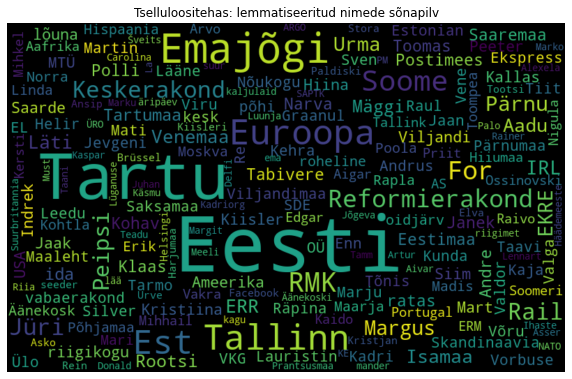

In [42]:
nimed_lemmad = []
for n in tqdm(nimed_texts):
    for sona in n:
        tekst = Text(sona).tag_layer().morph_analysis['lemma']
        nimed_lemmad.append(tekst[0][0])
        #print(tekst[0][0])

nimed_lemmad_words = ' '.join(map(str, nimed_lemmad))

wordcloud_nimed_lemmad = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimed_lemmad_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimed_lemmad, interpolation='bilinear')
plt.title(konflikt + ": lemmatiseeritud nimede sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis8_Nimed_lemmatiseeritud_sonapilv.png")
plt.axis("off")
print("Nimed sõnapilves: ", len(nimed_lemmad))

In [43]:
jaotus8 =pd.DataFrame(nimed_lemmad, columns=['nimi'])
tabel8 = jaotus8.groupby(['nimi']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel8['osakaal %']= (tabel8['esinemissagedus']/len(nimed_lemmad)*100)
tabel8_1 = tabel8.style.set_caption(konflikt + ": lemmatiseeritud nimede TOP 20")
tabel8.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel8_Nimed_lemmatiseeritud_TOP_20.xlsx")

In [44]:
tabel8_1

,nimi,esinemissagedus,osakaal %
625,Eesti,5442,13.591409
3350,Tartu,3605,9.003497
691,Emajõgi,1066,2.662338
3309,Tallinn,737,1.840659
771,Euroopa,732,1.828172
3163,Soome,471,1.176324
2778,RMK,439,1.096404
751,Est-For,395,0.986513
2858,Reformierakond,322,0.804196
2806,Rail,319,0.796703
